In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C:\Users\annek\AppData\Local\Temp\ipykernel_5324\3793166428.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


Modified timestamps for file u00009s00001_hw00002.svc:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32


Modified timestamps for file u00035s00001_hw00002.svc:
0     0
1     8
2    15
3    23
4    31
Name: timestamp, dtype: int32




C:\Users\annek\AppData\Local\Temp\ipykernel_5324\3793166428.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


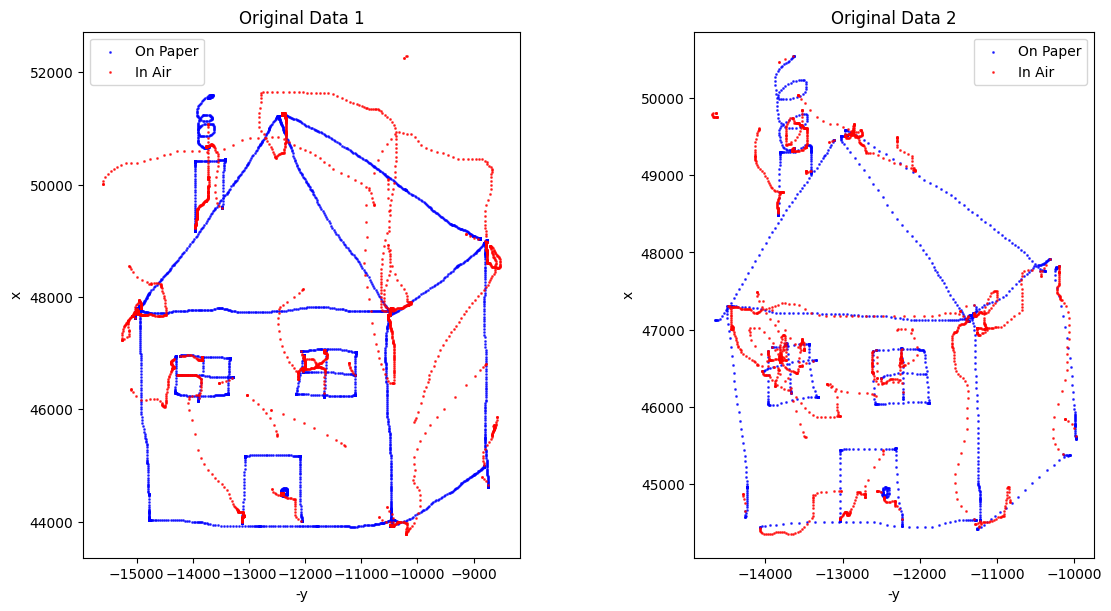

Processed data shape: (9120, 4)
Average number of data points: 4560


In [44]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3]]  # Select x, y, timestamp, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

directory = 'Task2'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=2)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [45]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # Changed to 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # Changed to 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)

# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


latent_dim = 128
beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [46]:
# Cell 4 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, variability=0.05):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        mean, logvar = model.encode(tf.convert_to_tensor(combined_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar)
        augmented_data = model.decode(z).numpy()

        # # Determine the number of data points for this augmented dataset
        # num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # # Truncate or pad the augmented data to match the number of points
        # if num_points < augmented_data.shape[0]:
        #     augmented_data = augmented_data[:num_points]
        # else:
        #     padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
        #     augmented_data = np.vstack([augmented_data, padding])

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status



C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/300: 100%|██████████| 18/18 [00:08<00:00,  2.12batch/s, Total Loss=0.73, Reconstruction Loss=0.73, KL Loss=0.00413]  


Epoch 1: Total Loss = 0.751880, Reconstruction Loss = 0.751880, KL Divergence Loss = 0.001643
MAE = 0.231019, MSE = 0.076510, NRMSE = 0.276604


Epoch 2/300: 100%|██████████| 18/18 [00:00<00:00, 64.18batch/s, Total Loss=0.217, Reconstruction Loss=0.217, KL Loss=0.0613]


Epoch 2: Total Loss = 0.548025, Reconstruction Loss = 0.548025, KL Divergence Loss = 0.023286
MAE = 0.230126, MSE = 0.076062, NRMSE = 0.275793


Epoch 3/300: 100%|██████████| 18/18 [00:00<00:00, 52.29batch/s, Total Loss=0.0804, Reconstruction Loss=0.0804, KL Loss=0.318]


Epoch 3: Total Loss = 0.092624, Reconstruction Loss = 0.092624, KL Divergence Loss = 0.205519
MAE = 0.234861, MSE = 0.077953, NRMSE = 0.279200


Epoch 4/300: 100%|██████████| 18/18 [00:00<00:00, 61.44batch/s, Total Loss=0.0753, Reconstruction Loss=0.0753, KL Loss=0.476]


Epoch 4: Total Loss = 0.075800, Reconstruction Loss = 0.075799, KL Divergence Loss = 0.427623
MAE = 0.235482, MSE = 0.078022, NRMSE = 0.279324


Epoch 5/300: 100%|██████████| 18/18 [00:00<00:00, 61.87batch/s, Total Loss=0.0689, Reconstruction Loss=0.0689, KL Loss=0.563]


Epoch 5: Total Loss = 0.071789, Reconstruction Loss = 0.071788, KL Divergence Loss = 0.514947
MAE = 0.234603, MSE = 0.077551, NRMSE = 0.278480


Epoch 6/300: 100%|██████████| 18/18 [00:00<00:00, 44.09batch/s, Total Loss=0.0549, Reconstruction Loss=0.0549, KL Loss=0.737]


Epoch 6: Total Loss = 0.060504, Reconstruction Loss = 0.060503, KL Divergence Loss = 0.663296
MAE = 0.240307, MSE = 0.081246, NRMSE = 0.285036


Epoch 7/300: 100%|██████████| 18/18 [00:00<00:00, 62.25batch/s, Total Loss=0.0514, Reconstruction Loss=0.0514, KL Loss=0.843]


Epoch 7: Total Loss = 0.053899, Reconstruction Loss = 0.053898, KL Divergence Loss = 0.806507
MAE = 0.246850, MSE = 0.085092, NRMSE = 0.291705


Epoch 8/300: 100%|██████████| 18/18 [00:00<00:00, 62.36batch/s, Total Loss=0.0412, Reconstruction Loss=0.0412, KL Loss=0.988]


Epoch 8: Total Loss = 0.046873, Reconstruction Loss = 0.046872, KL Divergence Loss = 0.930236
MAE = 0.250102, MSE = 0.087228, NRMSE = 0.295344


Epoch 9/300: 100%|██████████| 18/18 [00:00<00:00, 51.37batch/s, Total Loss=0.0302, Reconstruction Loss=0.0302, KL Loss=1.18]


Epoch 9: Total Loss = 0.036498, Reconstruction Loss = 0.036497, KL Divergence Loss = 1.094932
MAE = 0.255791, MSE = 0.091251, NRMSE = 0.302077


Epoch 10/300: 100%|██████████| 18/18 [00:00<00:00, 65.42batch/s, Total Loss=0.0156, Reconstruction Loss=0.0156, KL Loss=1.4] 


Epoch 10: Total Loss = 0.022130, Reconstruction Loss = 0.022128, KL Divergence Loss = 1.297958
MAE = 0.259871, MSE = 0.094489, NRMSE = 0.307391


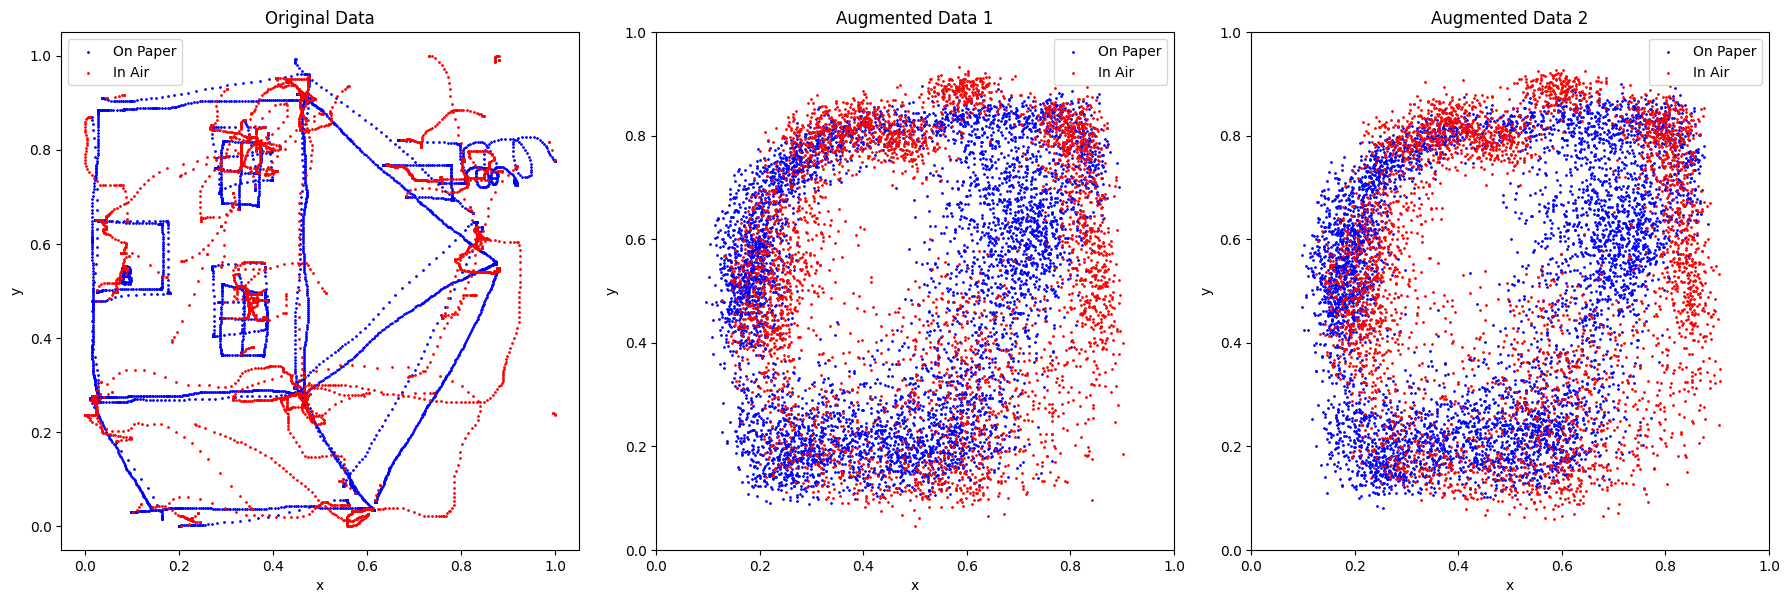

Epoch 11/300: 100%|██████████| 18/18 [00:00<00:00, 46.99batch/s, Total Loss=0.0117, Reconstruction Loss=0.0117, KL Loss=1.78]


Epoch 11: Total Loss = 0.013247, Reconstruction Loss = 0.013245, KL Divergence Loss = 1.634963
MAE = 0.255945, MSE = 0.091748, NRMSE = 0.302899


Epoch 12/300: 100%|██████████| 18/18 [00:00<00:00, 67.44batch/s, Total Loss=0.00999, Reconstruction Loss=0.00999, KL Loss=2.12]


Epoch 12: Total Loss = 0.011058, Reconstruction Loss = 0.011056, KL Divergence Loss = 1.970929
MAE = 0.253746, MSE = 0.090054, NRMSE = 0.300090


Epoch 13/300: 100%|██████████| 18/18 [00:00<00:00, 53.80batch/s, Total Loss=0.00966, Reconstruction Loss=0.00965, KL Loss=2.31]


Epoch 13: Total Loss = 0.009840, Reconstruction Loss = 0.009838, KL Divergence Loss = 2.240221
MAE = 0.251809, MSE = 0.088691, NRMSE = 0.297810


Epoch 14/300: 100%|██████████| 18/18 [00:00<00:00, 47.96batch/s, Total Loss=0.00805, Reconstruction Loss=0.00805, KL Loss=2.57]


Epoch 14: Total Loss = 0.009320, Reconstruction Loss = 0.009318, KL Divergence Loss = 2.474535
MAE = 0.249779, MSE = 0.087730, NRMSE = 0.296192


Epoch 15/300: 100%|██████████| 18/18 [00:00<00:00, 57.93batch/s, Total Loss=0.00822, Reconstruction Loss=0.00821, KL Loss=2.83]


Epoch 15: Total Loss = 0.008631, Reconstruction Loss = 0.008628, KL Divergence Loss = 2.662577
MAE = 0.248464, MSE = 0.086784, NRMSE = 0.294591


Epoch 16/300: 100%|██████████| 18/18 [00:00<00:00, 45.26batch/s, Total Loss=0.00882, Reconstruction Loss=0.00882, KL Loss=2.85]


Epoch 16: Total Loss = 0.008383, Reconstruction Loss = 0.008381, KL Divergence Loss = 2.827754
MAE = 0.246098, MSE = 0.085073, NRMSE = 0.291673


Epoch 17/300: 100%|██████████| 18/18 [00:00<00:00, 54.11batch/s, Total Loss=0.0075, Reconstruction Loss=0.0075, KL Loss=2.95]  


Epoch 17: Total Loss = 0.007805, Reconstruction Loss = 0.007802, KL Divergence Loss = 2.954938
MAE = 0.245412, MSE = 0.084805, NRMSE = 0.291213


Epoch 18/300: 100%|██████████| 18/18 [00:00<00:00, 53.51batch/s, Total Loss=0.00683, Reconstruction Loss=0.00683, KL Loss=3.19]


Epoch 18: Total Loss = 0.007064, Reconstruction Loss = 0.007060, KL Divergence Loss = 3.084810
MAE = 0.244694, MSE = 0.084506, NRMSE = 0.290700


Epoch 19/300: 100%|██████████| 18/18 [00:00<00:00, 41.26batch/s, Total Loss=0.00539, Reconstruction Loss=0.00539, KL Loss=3.24]


Epoch 19: Total Loss = 0.006565, Reconstruction Loss = 0.006562, KL Divergence Loss = 3.211517
MAE = 0.244066, MSE = 0.084325, NRMSE = 0.290387


Epoch 20/300: 100%|██████████| 18/18 [00:00<00:00, 54.84batch/s, Total Loss=0.00522, Reconstruction Loss=0.00521, KL Loss=3.42]


Epoch 20: Total Loss = 0.005960, Reconstruction Loss = 0.005957, KL Divergence Loss = 3.336493
MAE = 0.243602, MSE = 0.083981, NRMSE = 0.289795


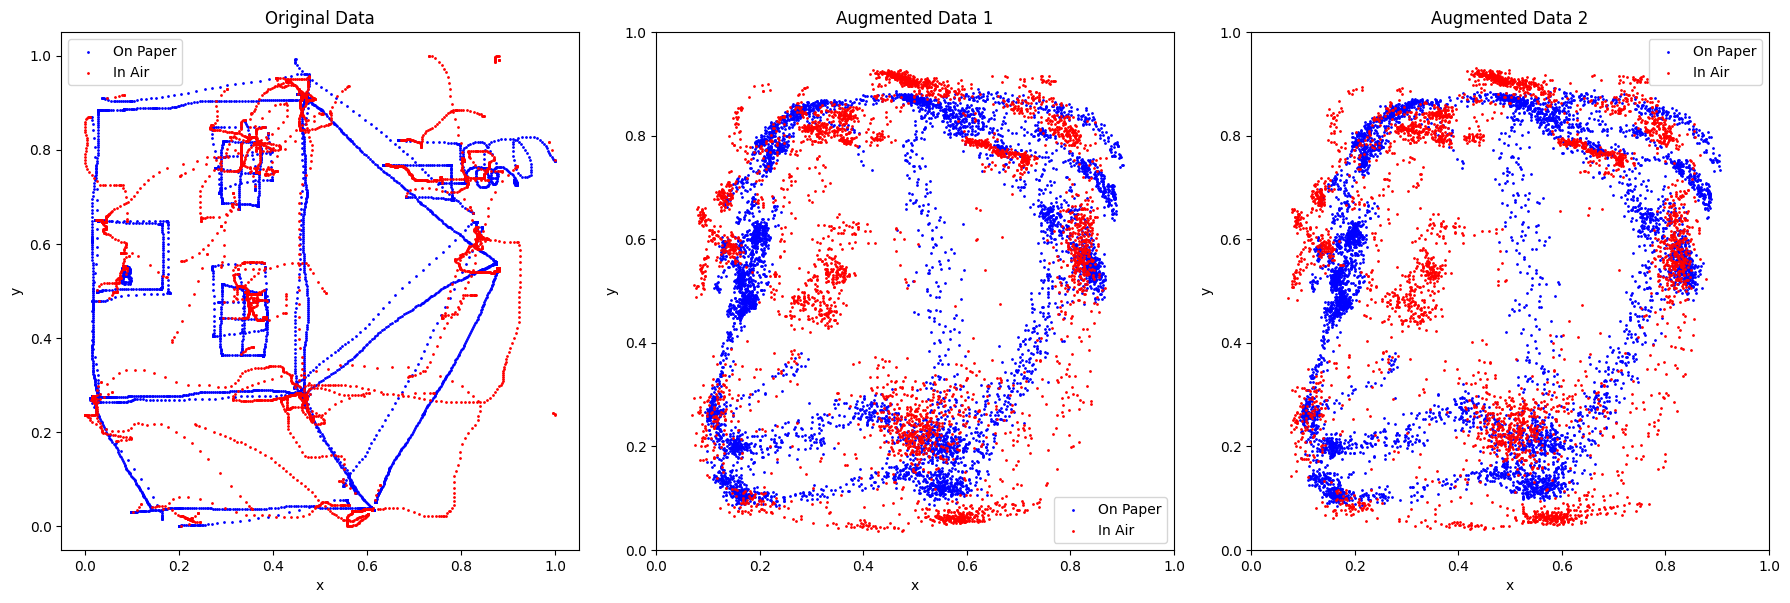

Epoch 21/300: 100%|██████████| 18/18 [00:00<00:00, 59.97batch/s, Total Loss=0.00524, Reconstruction Loss=0.00524, KL Loss=3.54]


Epoch 21: Total Loss = 0.005474, Reconstruction Loss = 0.005471, KL Divergence Loss = 3.464919
MAE = 0.244541, MSE = 0.084666, NRMSE = 0.290975


Epoch 22/300: 100%|██████████| 18/18 [00:00<00:00, 62.28batch/s, Total Loss=0.00482, Reconstruction Loss=0.00481, KL Loss=3.52]


Epoch 22: Total Loss = 0.005108, Reconstruction Loss = 0.005105, KL Divergence Loss = 3.599399
MAE = 0.244113, MSE = 0.084506, NRMSE = 0.290699


Epoch 23/300: 100%|██████████| 18/18 [00:00<00:00, 42.50batch/s, Total Loss=0.00444, Reconstruction Loss=0.00443, KL Loss=3.71]


Epoch 23: Total Loss = 0.004646, Reconstruction Loss = 0.004643, KL Divergence Loss = 3.721060
MAE = 0.244138, MSE = 0.084786, NRMSE = 0.291180


Epoch 24/300: 100%|██████████| 18/18 [00:00<00:00, 59.74batch/s, Total Loss=0.00384, Reconstruction Loss=0.00384, KL Loss=3.97]


Epoch 24: Total Loss = 0.004353, Reconstruction Loss = 0.004349, KL Divergence Loss = 3.839046
MAE = 0.244141, MSE = 0.085039, NRMSE = 0.291615


Epoch 25/300: 100%|██████████| 18/18 [00:00<00:00, 54.15batch/s, Total Loss=0.00381, Reconstruction Loss=0.00381, KL Loss=3.93]


Epoch 25: Total Loss = 0.003959, Reconstruction Loss = 0.003955, KL Divergence Loss = 3.941256
MAE = 0.244361, MSE = 0.085259, NRMSE = 0.291992


Epoch 26/300: 100%|██████████| 18/18 [00:00<00:00, 62.57batch/s, Total Loss=0.00325, Reconstruction Loss=0.00325, KL Loss=4.16]


Epoch 26: Total Loss = 0.003501, Reconstruction Loss = 0.003497, KL Divergence Loss = 4.052186
MAE = 0.245425, MSE = 0.085822, NRMSE = 0.292954


Epoch 27/300: 100%|██████████| 18/18 [00:00<00:00, 58.86batch/s, Total Loss=0.0028, Reconstruction Loss=0.0028, KL Loss=4.2]   


Epoch 27: Total Loss = 0.003021, Reconstruction Loss = 0.003017, KL Divergence Loss = 4.167882
MAE = 0.245187, MSE = 0.085996, NRMSE = 0.293250


Epoch 28/300: 100%|██████████| 18/18 [00:00<00:00, 47.86batch/s, Total Loss=0.00251, Reconstruction Loss=0.0025, KL Loss=4.43] 


Epoch 28: Total Loss = 0.002685, Reconstruction Loss = 0.002681, KL Divergence Loss = 4.274061
MAE = 0.246382, MSE = 0.086524, NRMSE = 0.294150


Epoch 29/300: 100%|██████████| 18/18 [00:00<00:00, 63.64batch/s, Total Loss=0.00202, Reconstruction Loss=0.00201, KL Loss=4.32]


Epoch 29: Total Loss = 0.002199, Reconstruction Loss = 0.002195, KL Divergence Loss = 4.358261
MAE = 0.246926, MSE = 0.086989, NRMSE = 0.294939


Epoch 30/300: 100%|██████████| 18/18 [00:00<00:00, 55.77batch/s, Total Loss=0.00159, Reconstruction Loss=0.00158, KL Loss=4.47]


Epoch 30: Total Loss = 0.001880, Reconstruction Loss = 0.001876, KL Divergence Loss = 4.433338
MAE = 0.247442, MSE = 0.087610, NRMSE = 0.295991


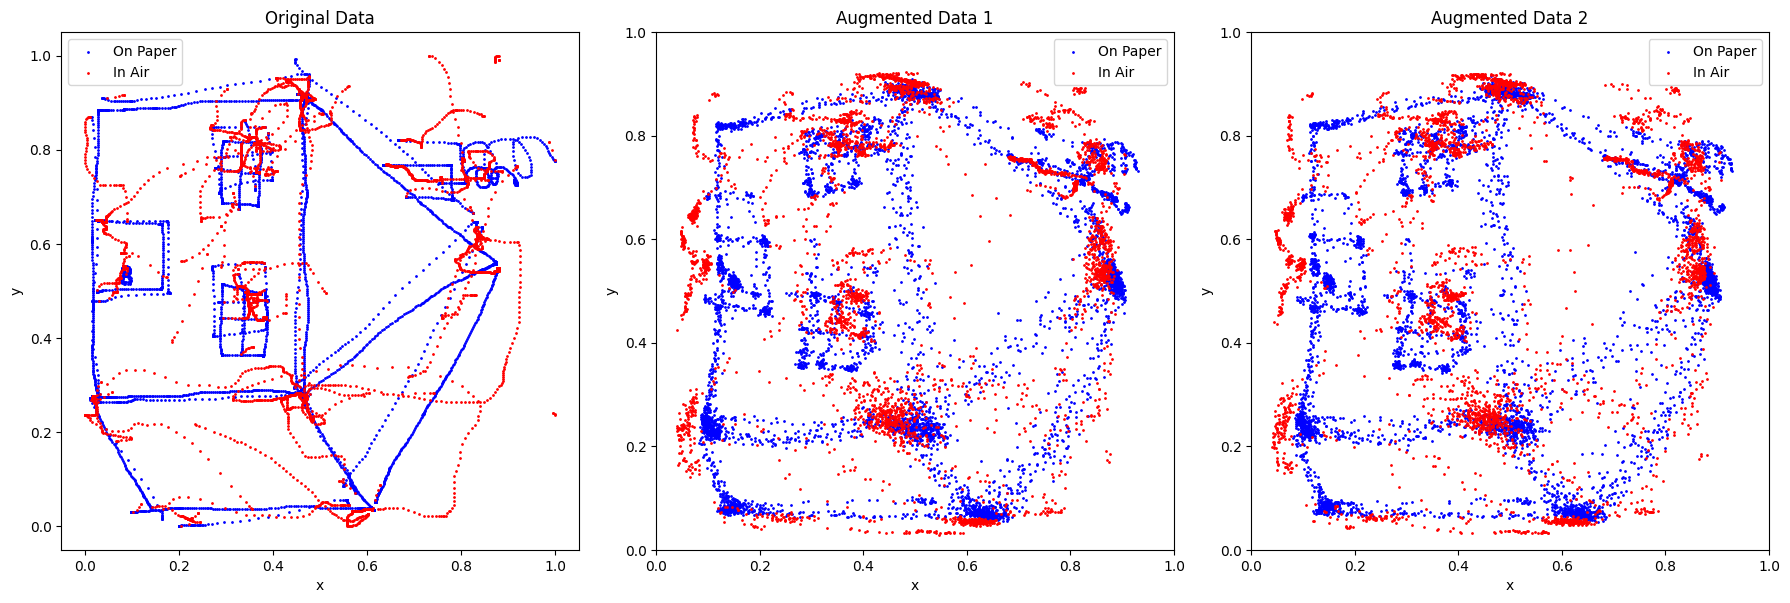

Epoch 31/300: 100%|██████████| 18/18 [00:00<00:00, 50.61batch/s, Total Loss=0.00153, Reconstruction Loss=0.00152, KL Loss=4.57]


Epoch 31: Total Loss = 0.001556, Reconstruction Loss = 0.001552, KL Divergence Loss = 4.500632
MAE = 0.247562, MSE = 0.087699, NRMSE = 0.296141


Epoch 32/300: 100%|██████████| 18/18 [00:00<00:00, 56.77batch/s, Total Loss=0.00111, Reconstruction Loss=0.0011, KL Loss=4.55]   


Epoch 32: Total Loss = 0.001146, Reconstruction Loss = 0.001141, KL Divergence Loss = 4.573968
MAE = 0.247216, MSE = 0.086933, NRMSE = 0.294844


Epoch 33/300: 100%|██████████| 18/18 [00:00<00:00, 63.64batch/s, Total Loss=0.000854, Reconstruction Loss=0.00085, KL Loss=4.6]  


Epoch 33: Total Loss = 0.001018, Reconstruction Loss = 0.001013, KL Divergence Loss = 4.665167
MAE = 0.248757, MSE = 0.088433, NRMSE = 0.297377


Epoch 34/300: 100%|██████████| 18/18 [00:00<00:00, 42.41batch/s, Total Loss=0.00085, Reconstruction Loss=0.000845, KL Loss=4.77] 


Epoch 34: Total Loss = 0.000913, Reconstruction Loss = 0.000908, KL Divergence Loss = 4.756032
MAE = 0.248402, MSE = 0.088245, NRMSE = 0.297060


Epoch 35/300: 100%|██████████| 18/18 [00:00<00:00, 57.08batch/s, Total Loss=0.000734, Reconstruction Loss=0.000729, KL Loss=4.9] 


Epoch 35: Total Loss = 0.000810, Reconstruction Loss = 0.000805, KL Divergence Loss = 4.845853
MAE = 0.248752, MSE = 0.088030, NRMSE = 0.296698


Epoch 36/300: 100%|██████████| 18/18 [00:00<00:00, 44.35batch/s, Total Loss=0.000735, Reconstruction Loss=0.00073, KL Loss=5.09] 


Epoch 36: Total Loss = 0.000771, Reconstruction Loss = 0.000766, KL Divergence Loss = 4.932501
MAE = 0.248289, MSE = 0.088229, NRMSE = 0.297033


Epoch 37/300: 100%|██████████| 18/18 [00:00<00:00, 62.21batch/s, Total Loss=0.000756, Reconstruction Loss=0.000751, KL Loss=5.11]


Epoch 37: Total Loss = 0.000786, Reconstruction Loss = 0.000781, KL Divergence Loss = 5.004717
MAE = 0.247765, MSE = 0.087435, NRMSE = 0.295694


Epoch 38/300: 100%|██████████| 18/18 [00:00<00:00, 52.99batch/s, Total Loss=0.000911, Reconstruction Loss=0.000906, KL Loss=5.2] 


Epoch 38: Total Loss = 0.000773, Reconstruction Loss = 0.000768, KL Divergence Loss = 5.067209
MAE = 0.248271, MSE = 0.088198, NRMSE = 0.296981


Epoch 39/300: 100%|██████████| 18/18 [00:00<00:00, 53.51batch/s, Total Loss=0.000709, Reconstruction Loss=0.000704, KL Loss=5.05]


Epoch 39: Total Loss = 0.000829, Reconstruction Loss = 0.000824, KL Divergence Loss = 5.099511
MAE = 0.248688, MSE = 0.088186, NRMSE = 0.296962


Epoch 40/300: 100%|██████████| 18/18 [00:00<00:00, 60.70batch/s, Total Loss=0.0006, Reconstruction Loss=0.000595, KL Loss=5.13]  


Epoch 40: Total Loss = 0.000652, Reconstruction Loss = 0.000647, KL Divergence Loss = 5.131117
MAE = 0.247834, MSE = 0.087703, NRMSE = 0.296148


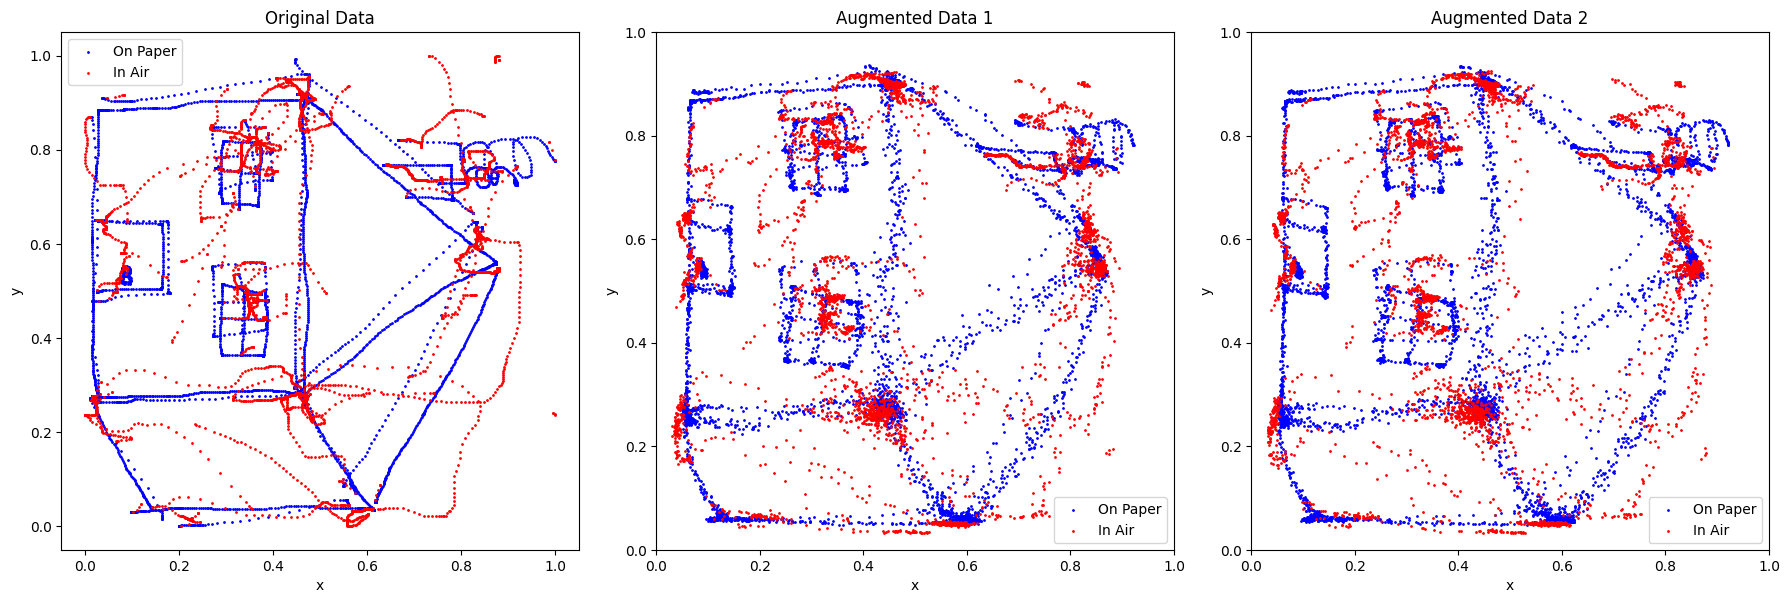

Epoch 41/300: 100%|██████████| 18/18 [00:00<00:00, 58.77batch/s, Total Loss=0.00056, Reconstruction Loss=0.000555, KL Loss=5.06] 


Epoch 41: Total Loss = 0.000564, Reconstruction Loss = 0.000559, KL Divergence Loss = 5.176000
MAE = 0.248744, MSE = 0.088217, NRMSE = 0.297013


Epoch 42/300: 100%|██████████| 18/18 [00:00<00:00, 50.06batch/s, Total Loss=0.000543, Reconstruction Loss=0.000537, KL Loss=5.32]


Epoch 42: Total Loss = 0.000577, Reconstruction Loss = 0.000572, KL Divergence Loss = 5.226469
MAE = 0.248491, MSE = 0.088281, NRMSE = 0.297120


Epoch 43/300: 100%|██████████| 18/18 [00:00<00:00, 52.34batch/s, Total Loss=0.000716, Reconstruction Loss=0.000711, KL Loss=5.13]


Epoch 43: Total Loss = 0.000539, Reconstruction Loss = 0.000534, KL Divergence Loss = 5.274259
MAE = 0.248542, MSE = 0.087850, NRMSE = 0.296394


Epoch 44/300: 100%|██████████| 18/18 [00:00<00:00, 59.55batch/s, Total Loss=0.000489, Reconstruction Loss=0.000484, KL Loss=5.41]


Epoch 44: Total Loss = 0.000488, Reconstruction Loss = 0.000482, KL Divergence Loss = 5.310888
MAE = 0.248955, MSE = 0.088587, NRMSE = 0.297635


Epoch 45/300: 100%|██████████| 18/18 [00:00<00:00, 46.58batch/s, Total Loss=0.000462, Reconstruction Loss=0.000457, KL Loss=5.32]


Epoch 45: Total Loss = 0.000524, Reconstruction Loss = 0.000518, KL Divergence Loss = 5.351424
MAE = 0.249300, MSE = 0.088630, NRMSE = 0.297709


Epoch 46/300: 100%|██████████| 18/18 [00:00<00:00, 58.35batch/s, Total Loss=0.000712, Reconstruction Loss=0.000706, KL Loss=5.62]


Epoch 46: Total Loss = 0.000539, Reconstruction Loss = 0.000534, KL Divergence Loss = 5.385553
MAE = 0.248219, MSE = 0.087713, NRMSE = 0.296163


Epoch 47/300: 100%|██████████| 18/18 [00:00<00:00, 41.50batch/s, Total Loss=0.000389, Reconstruction Loss=0.000384, KL Loss=5.36]


Epoch 47: Total Loss = 0.000448, Reconstruction Loss = 0.000443, KL Divergence Loss = 5.402834
MAE = 0.248454, MSE = 0.088123, NRMSE = 0.296856


Epoch 48/300: 100%|██████████| 18/18 [00:00<00:00, 63.61batch/s, Total Loss=0.000632, Reconstruction Loss=0.000627, KL Loss=5.49]


Epoch 48: Total Loss = 0.000444, Reconstruction Loss = 0.000439, KL Divergence Loss = 5.438464
MAE = 0.249928, MSE = 0.088979, NRMSE = 0.298294


Epoch 49/300: 100%|██████████| 18/18 [00:00<00:00, 62.89batch/s, Total Loss=0.000414, Reconstruction Loss=0.000409, KL Loss=5.33]


Epoch 49: Total Loss = 0.000550, Reconstruction Loss = 0.000544, KL Divergence Loss = 5.456661
MAE = 0.248352, MSE = 0.088383, NRMSE = 0.297293


Epoch 50/300: 100%|██████████| 18/18 [00:00<00:00, 45.11batch/s, Total Loss=0.00034, Reconstruction Loss=0.000335, KL Loss=5.61] 


Epoch 50: Total Loss = 0.000385, Reconstruction Loss = 0.000379, KL Divergence Loss = 5.469747
MAE = 0.249841, MSE = 0.088887, NRMSE = 0.298140


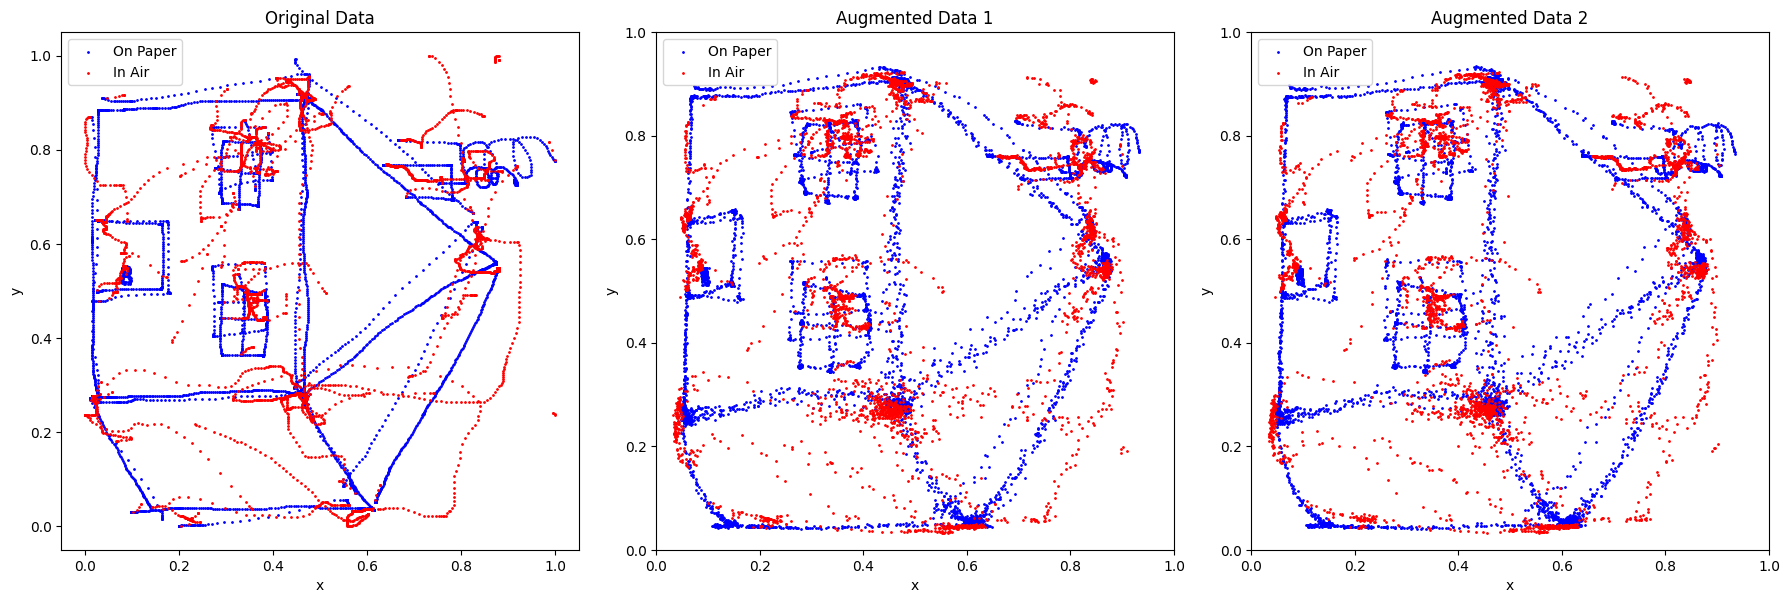

Epoch 51/300: 100%|██████████| 18/18 [00:00<00:00, 42.05batch/s, Total Loss=0.000425, Reconstruction Loss=0.00042, KL Loss=5.47] 


Epoch 51: Total Loss = 0.000394, Reconstruction Loss = 0.000388, KL Divergence Loss = 5.503977
MAE = 0.248190, MSE = 0.088197, NRMSE = 0.296980


Epoch 52/300: 100%|██████████| 18/18 [00:00<00:00, 45.87batch/s, Total Loss=0.000347, Reconstruction Loss=0.000341, KL Loss=5.59]


Epoch 52: Total Loss = 0.000424, Reconstruction Loss = 0.000418, KL Divergence Loss = 5.534392
MAE = 0.247192, MSE = 0.087346, NRMSE = 0.295544


Epoch 53/300: 100%|██████████| 18/18 [00:00<00:00, 55.07batch/s, Total Loss=0.000353, Reconstruction Loss=0.000348, KL Loss=5.55]


Epoch 53: Total Loss = 0.000341, Reconstruction Loss = 0.000335, KL Divergence Loss = 5.560338
MAE = 0.248451, MSE = 0.088192, NRMSE = 0.296971


Epoch 54/300: 100%|██████████| 18/18 [00:00<00:00, 59.18batch/s, Total Loss=0.000419, Reconstruction Loss=0.000414, KL Loss=5.61]


Epoch 54: Total Loss = 0.000345, Reconstruction Loss = 0.000339, KL Divergence Loss = 5.596956
MAE = 0.248052, MSE = 0.087933, NRMSE = 0.296536


Epoch 55/300: 100%|██████████| 18/18 [00:00<00:00, 44.92batch/s, Total Loss=0.000333, Reconstruction Loss=0.000327, KL Loss=5.59]


Epoch 55: Total Loss = 0.000331, Reconstruction Loss = 0.000325, KL Divergence Loss = 5.627360
MAE = 0.246640, MSE = 0.087533, NRMSE = 0.295860


Epoch 56/300: 100%|██████████| 18/18 [00:00<00:00, 52.09batch/s, Total Loss=0.000461, Reconstruction Loss=0.000455, KL Loss=5.61]


Epoch 56: Total Loss = 0.000428, Reconstruction Loss = 0.000422, KL Divergence Loss = 5.649438
MAE = 0.247455, MSE = 0.087575, NRMSE = 0.295930


Epoch 57/300: 100%|██████████| 18/18 [00:00<00:00, 52.83batch/s, Total Loss=0.000755, Reconstruction Loss=0.000749, KL Loss=5.67]


Epoch 57: Total Loss = 0.000529, Reconstruction Loss = 0.000524, KL Divergence Loss = 5.639730
MAE = 0.247287, MSE = 0.087522, NRMSE = 0.295841


Epoch 58/300: 100%|██████████| 18/18 [00:00<00:00, 57.39batch/s, Total Loss=0.000364, Reconstruction Loss=0.000359, KL Loss=5.56]


Epoch 58: Total Loss = 0.000429, Reconstruction Loss = 0.000424, KL Divergence Loss = 5.630371
MAE = 0.248461, MSE = 0.088165, NRMSE = 0.296926


Epoch 59/300: 100%|██████████| 18/18 [00:00<00:00, 49.76batch/s, Total Loss=0.000287, Reconstruction Loss=0.000282, KL Loss=5.68]


Epoch 59: Total Loss = 0.000331, Reconstruction Loss = 0.000325, KL Divergence Loss = 5.638182
MAE = 0.248899, MSE = 0.088365, NRMSE = 0.297263


Epoch 60/300: 100%|██████████| 18/18 [00:00<00:00, 61.28batch/s, Total Loss=0.000246, Reconstruction Loss=0.00024, KL Loss=5.66] 


Epoch 60: Total Loss = 0.000271, Reconstruction Loss = 0.000265, KL Divergence Loss = 5.668616
MAE = 0.247531, MSE = 0.087708, NRMSE = 0.296156


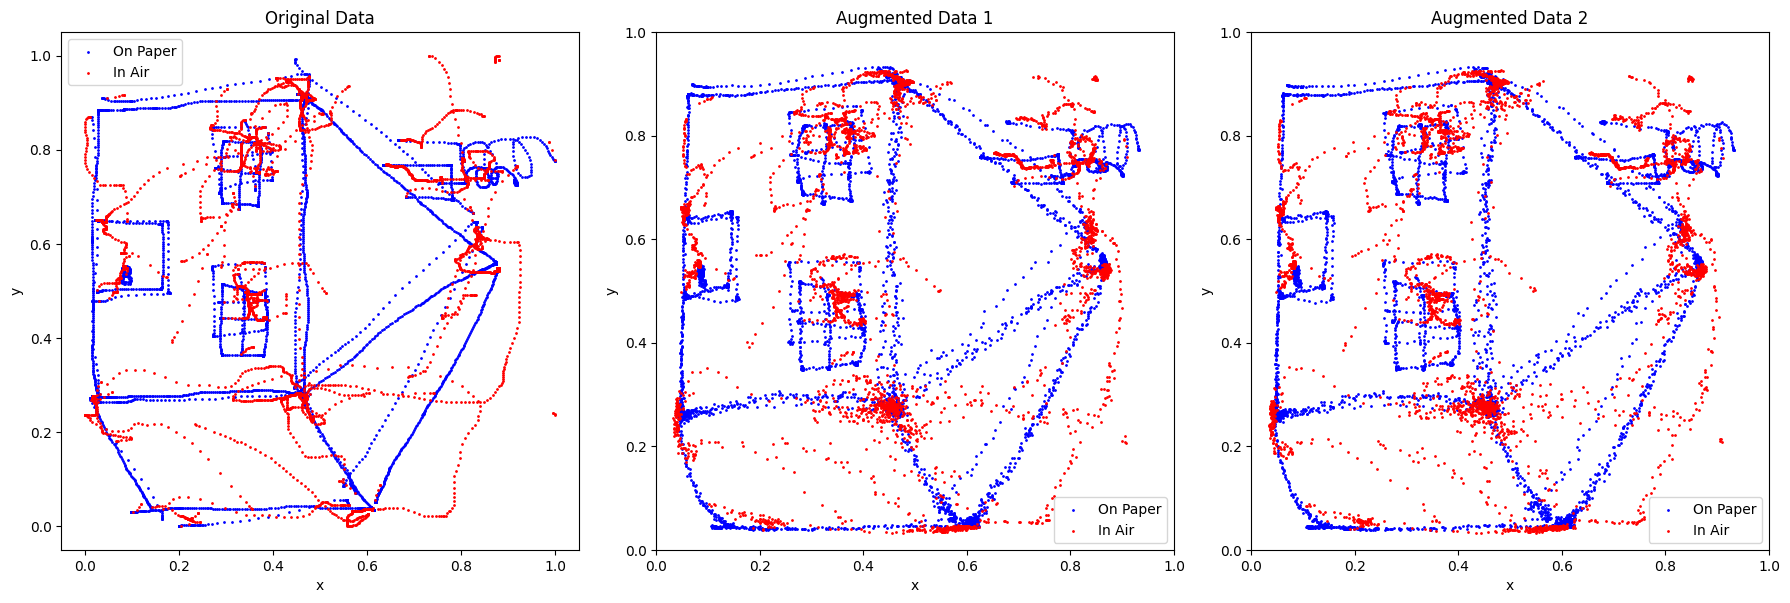

Epoch 61/300: 100%|██████████| 18/18 [00:00<00:00, 57.51batch/s, Total Loss=0.000257, Reconstruction Loss=0.000252, KL Loss=5.7] 


Epoch 61: Total Loss = 0.000267, Reconstruction Loss = 0.000261, KL Divergence Loss = 5.703000
MAE = 0.247800, MSE = 0.087800, NRMSE = 0.296310


Epoch 62/300: 100%|██████████| 18/18 [00:00<00:00, 58.35batch/s, Total Loss=0.000412, Reconstruction Loss=0.000406, KL Loss=5.8] 


Epoch 62: Total Loss = 0.000460, Reconstruction Loss = 0.000455, KL Divergence Loss = 5.730539
MAE = 0.247855, MSE = 0.087400, NRMSE = 0.295635


Epoch 63/300: 100%|██████████| 18/18 [00:00<00:00, 45.01batch/s, Total Loss=0.000226, Reconstruction Loss=0.00022, KL Loss=5.71] 


Epoch 63: Total Loss = 0.000338, Reconstruction Loss = 0.000333, KL Divergence Loss = 5.724715
MAE = 0.247649, MSE = 0.087549, NRMSE = 0.295887


Epoch 64/300: 100%|██████████| 18/18 [00:00<00:00, 58.66batch/s, Total Loss=0.000266, Reconstruction Loss=0.00026, KL Loss=5.67] 


Epoch 64: Total Loss = 0.000270, Reconstruction Loss = 0.000265, KL Divergence Loss = 5.748007
MAE = 0.248669, MSE = 0.088477, NRMSE = 0.297451


Epoch 65/300: 100%|██████████| 18/18 [00:00<00:00, 42.62batch/s, Total Loss=0.000305, Reconstruction Loss=0.000299, KL Loss=5.84]


Epoch 65: Total Loss = 0.000329, Reconstruction Loss = 0.000323, KL Divergence Loss = 5.768156
MAE = 0.247871, MSE = 0.088083, NRMSE = 0.296787


Epoch 66/300: 100%|██████████| 18/18 [00:00<00:00, 51.56batch/s, Total Loss=0.000355, Reconstruction Loss=0.000349, KL Loss=5.76]


Epoch 66: Total Loss = 0.000360, Reconstruction Loss = 0.000355, KL Divergence Loss = 5.781787
MAE = 0.246740, MSE = 0.087249, NRMSE = 0.295379


Epoch 67/300: 100%|██████████| 18/18 [00:00<00:00, 38.43batch/s, Total Loss=0.000278, Reconstruction Loss=0.000272, KL Loss=5.75]


Epoch 67: Total Loss = 0.000253, Reconstruction Loss = 0.000247, KL Divergence Loss = 5.790051
MAE = 0.247861, MSE = 0.087770, NRMSE = 0.296261


Epoch 68/300: 100%|██████████| 18/18 [00:00<00:00, 55.44batch/s, Total Loss=0.000279, Reconstruction Loss=0.000273, KL Loss=5.84]


Epoch 68: Total Loss = 0.000315, Reconstruction Loss = 0.000310, KL Divergence Loss = 5.812733
MAE = 0.246567, MSE = 0.087176, NRMSE = 0.295257


Epoch 69/300: 100%|██████████| 18/18 [00:00<00:00, 45.36batch/s, Total Loss=0.000238, Reconstruction Loss=0.000232, KL Loss=5.78]


Epoch 69: Total Loss = 0.000309, Reconstruction Loss = 0.000303, KL Divergence Loss = 5.819009
MAE = 0.247679, MSE = 0.087799, NRMSE = 0.296309


Epoch 70/300: 100%|██████████| 18/18 [00:00<00:00, 58.66batch/s, Total Loss=0.000196, Reconstruction Loss=0.00019, KL Loss=5.88] 


Epoch 70: Total Loss = 0.000219, Reconstruction Loss = 0.000214, KL Divergence Loss = 5.838228
MAE = 0.246990, MSE = 0.087406, NRMSE = 0.295645


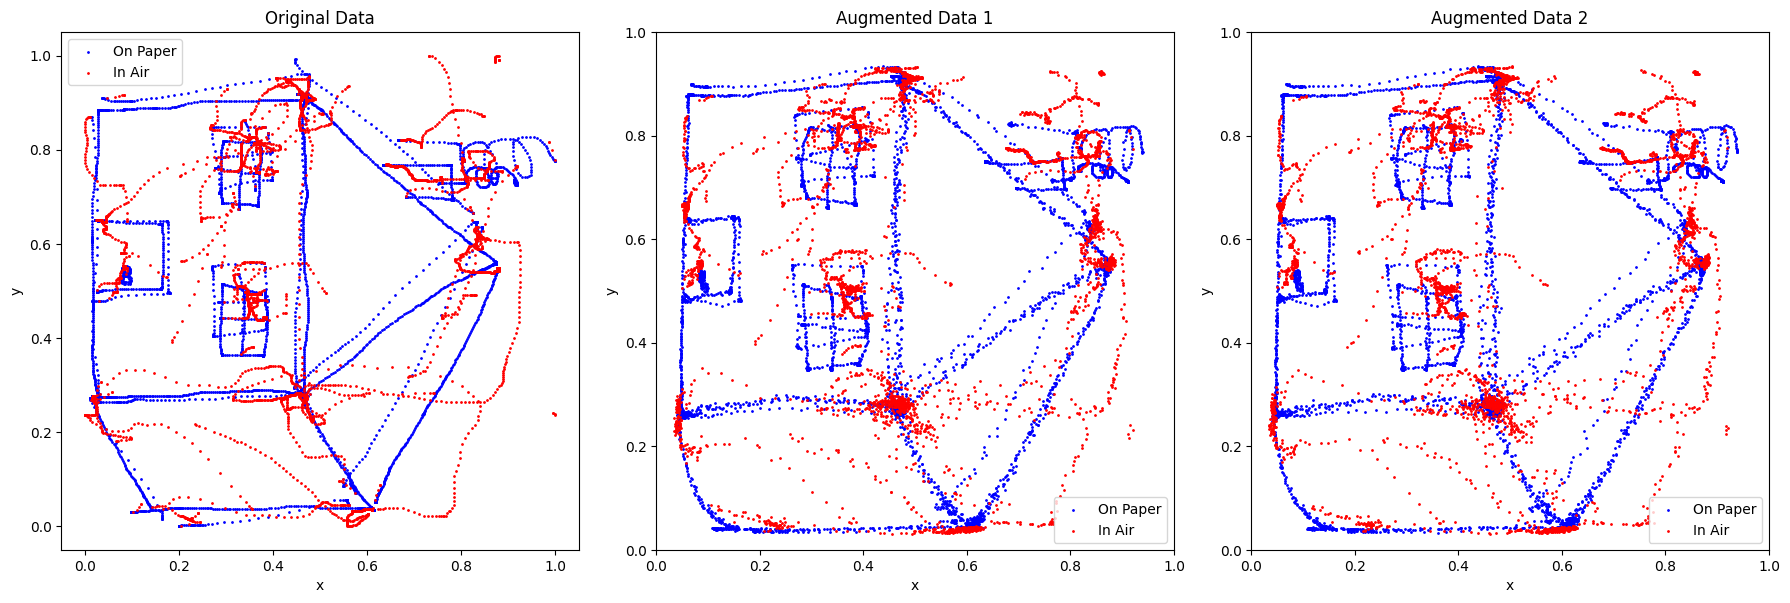

Epoch 71/300: 100%|██████████| 18/18 [00:00<00:00, 61.93batch/s, Total Loss=0.00021, Reconstruction Loss=0.000205, KL Loss=5.64] 


Epoch 71: Total Loss = 0.000339, Reconstruction Loss = 0.000333, KL Divergence Loss = 5.852727
MAE = 0.249128, MSE = 0.088347, NRMSE = 0.297232


Epoch 72/300: 100%|██████████| 18/18 [00:00<00:00, 52.60batch/s, Total Loss=0.000285, Reconstruction Loss=0.000279, KL Loss=5.92]


Epoch 72: Total Loss = 0.000209, Reconstruction Loss = 0.000203, KL Divergence Loss = 5.872512
MAE = 0.247496, MSE = 0.087917, NRMSE = 0.296508


Epoch 73/300: 100%|██████████| 18/18 [00:00<00:00, 61.03batch/s, Total Loss=0.000374, Reconstruction Loss=0.000368, KL Loss=5.84]


Epoch 73: Total Loss = 0.000319, Reconstruction Loss = 0.000313, KL Divergence Loss = 5.896159
MAE = 0.246379, MSE = 0.086965, NRMSE = 0.294899


Epoch 74/300: 100%|██████████| 18/18 [00:00<00:00, 61.61batch/s, Total Loss=0.000233, Reconstruction Loss=0.000227, KL Loss=5.72]


Epoch 74: Total Loss = 0.000262, Reconstruction Loss = 0.000256, KL Divergence Loss = 5.903640
MAE = 0.247332, MSE = 0.087682, NRMSE = 0.296112


Epoch 75/300: 100%|██████████| 18/18 [00:00<00:00, 48.58batch/s, Total Loss=0.000201, Reconstruction Loss=0.000195, KL Loss=6.03]


Epoch 75: Total Loss = 0.000227, Reconstruction Loss = 0.000221, KL Divergence Loss = 5.927203
MAE = 0.247203, MSE = 0.087326, NRMSE = 0.295509


Epoch 76/300: 100%|██████████| 18/18 [00:00<00:00, 61.02batch/s, Total Loss=0.000474, Reconstruction Loss=0.000468, KL Loss=5.95]


Epoch 76: Total Loss = 0.000256, Reconstruction Loss = 0.000250, KL Divergence Loss = 5.953691
MAE = 0.247159, MSE = 0.087768, NRMSE = 0.296257


Epoch 77/300: 100%|██████████| 18/18 [00:00<00:00, 50.12batch/s, Total Loss=0.000213, Reconstruction Loss=0.000207, KL Loss=5.87]


Epoch 77: Total Loss = 0.000304, Reconstruction Loss = 0.000298, KL Divergence Loss = 5.952453
MAE = 0.248842, MSE = 0.088118, NRMSE = 0.296846


Epoch 78/300: 100%|██████████| 18/18 [00:00<00:00, 60.16batch/s, Total Loss=0.000212, Reconstruction Loss=0.000206, KL Loss=6.05]


Epoch 78: Total Loss = 0.000262, Reconstruction Loss = 0.000256, KL Divergence Loss = 5.968956
MAE = 0.248316, MSE = 0.088133, NRMSE = 0.296873


Epoch 79/300: 100%|██████████| 18/18 [00:00<00:00, 47.22batch/s, Total Loss=0.000466, Reconstruction Loss=0.00046, KL Loss=6.05] 


Epoch 79: Total Loss = 0.000298, Reconstruction Loss = 0.000292, KL Divergence Loss = 5.976545
MAE = 0.246593, MSE = 0.087277, NRMSE = 0.295427


Epoch 80/300: 100%|██████████| 18/18 [00:00<00:00, 61.92batch/s, Total Loss=0.000234, Reconstruction Loss=0.000228, KL Loss=5.94]


Epoch 80: Total Loss = 0.000217, Reconstruction Loss = 0.000211, KL Divergence Loss = 5.983884
MAE = 0.248417, MSE = 0.088349, NRMSE = 0.297236


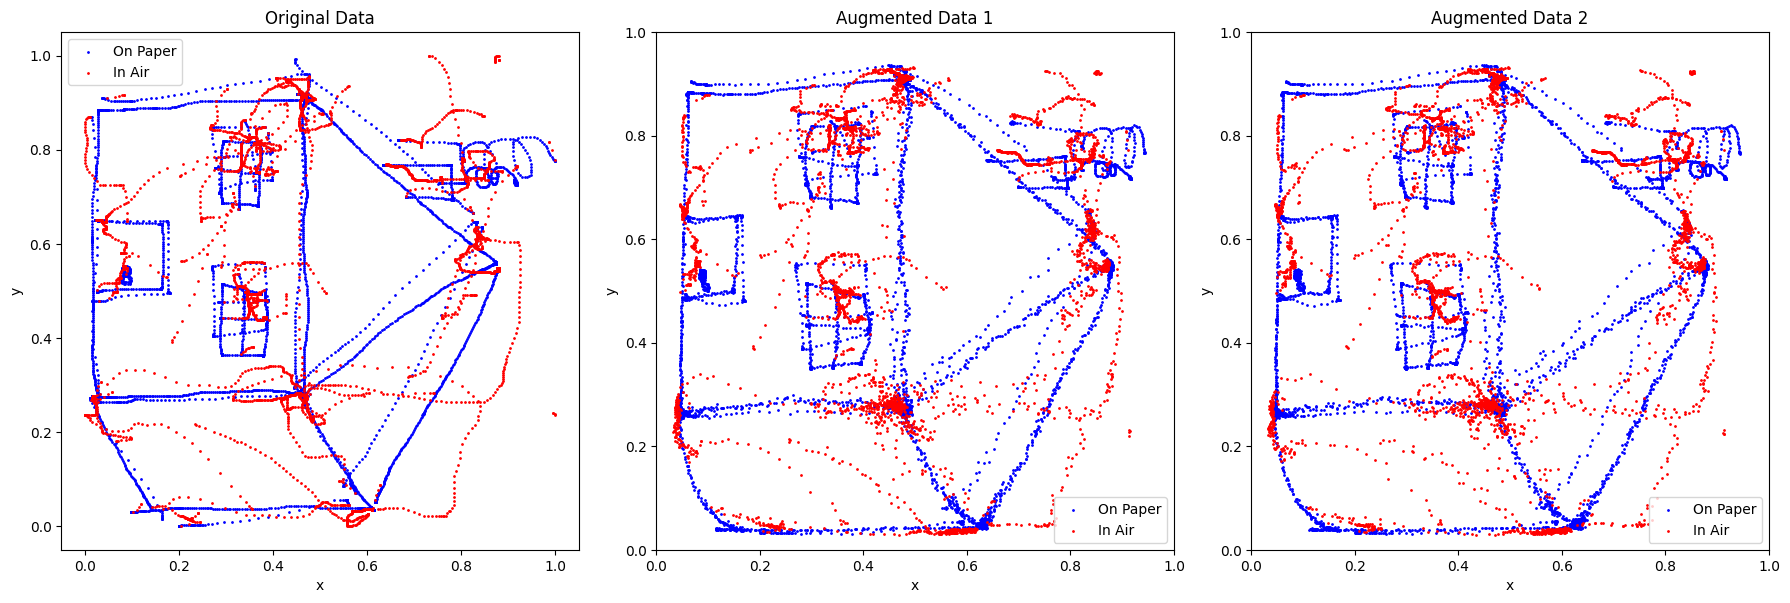

Epoch 81/300: 100%|██████████| 18/18 [00:00<00:00, 53.61batch/s, Total Loss=0.000184, Reconstruction Loss=0.000177, KL Loss=6.11]


Epoch 81: Total Loss = 0.000226, Reconstruction Loss = 0.000220, KL Divergence Loss = 6.006365
MAE = 0.247852, MSE = 0.087628, NRMSE = 0.296021


Epoch 82/300: 100%|██████████| 18/18 [00:00<00:00, 50.27batch/s, Total Loss=0.000214, Reconstruction Loss=0.000208, KL Loss=5.91]


Epoch 82: Total Loss = 0.000192, Reconstruction Loss = 0.000186, KL Divergence Loss = 6.021733
MAE = 0.248822, MSE = 0.088462, NRMSE = 0.297426


Epoch 83/300: 100%|██████████| 18/18 [00:00<00:00, 57.07batch/s, Total Loss=0.000203, Reconstruction Loss=0.000197, KL Loss=6.05]


Epoch 83: Total Loss = 0.000289, Reconstruction Loss = 0.000283, KL Divergence Loss = 6.037355
MAE = 0.248527, MSE = 0.088242, NRMSE = 0.297055


Epoch 84/300: 100%|██████████| 18/18 [00:00<00:00, 51.52batch/s, Total Loss=0.000242, Reconstruction Loss=0.000236, KL Loss=5.91]


Epoch 84: Total Loss = 0.000340, Reconstruction Loss = 0.000334, KL Divergence Loss = 6.033476
MAE = 0.248195, MSE = 0.088231, NRMSE = 0.297037


Epoch 85/300: 100%|██████████| 18/18 [00:00<00:00, 65.69batch/s, Total Loss=0.000234, Reconstruction Loss=0.000228, KL Loss=6.1] 


Epoch 85: Total Loss = 0.000211, Reconstruction Loss = 0.000205, KL Divergence Loss = 6.035221
MAE = 0.248491, MSE = 0.088377, NRMSE = 0.297283


Epoch 86/300: 100%|██████████| 18/18 [00:00<00:00, 51.35batch/s, Total Loss=0.000182, Reconstruction Loss=0.000176, KL Loss=6.09]


Epoch 86: Total Loss = 0.000190, Reconstruction Loss = 0.000184, KL Divergence Loss = 6.052989
MAE = 0.246201, MSE = 0.086940, NRMSE = 0.294856


Epoch 87/300: 100%|██████████| 18/18 [00:00<00:00, 62.59batch/s, Total Loss=0.000253, Reconstruction Loss=0.000247, KL Loss=6.04]


Epoch 87: Total Loss = 0.000225, Reconstruction Loss = 0.000219, KL Divergence Loss = 6.075059
MAE = 0.247298, MSE = 0.087928, NRMSE = 0.296527


Epoch 88/300: 100%|██████████| 18/18 [00:00<00:00, 49.83batch/s, Total Loss=0.000671, Reconstruction Loss=0.000665, KL Loss=6.2] 


Epoch 88: Total Loss = 0.000307, Reconstruction Loss = 0.000301, KL Divergence Loss = 6.086019
MAE = 0.246965, MSE = 0.087452, NRMSE = 0.295723


Epoch 89/300: 100%|██████████| 18/18 [00:00<00:00, 58.96batch/s, Total Loss=0.000208, Reconstruction Loss=0.000202, KL Loss=5.92]


Epoch 89: Total Loss = 0.000353, Reconstruction Loss = 0.000347, KL Divergence Loss = 6.061197
MAE = 0.247542, MSE = 0.087919, NRMSE = 0.296511


Epoch 90/300: 100%|██████████| 18/18 [00:00<00:00, 54.03batch/s, Total Loss=0.00017, Reconstruction Loss=0.000164, KL Loss=6.26] 


Epoch 90: Total Loss = 0.000228, Reconstruction Loss = 0.000222, KL Divergence Loss = 6.062129
MAE = 0.247809, MSE = 0.088011, NRMSE = 0.296667


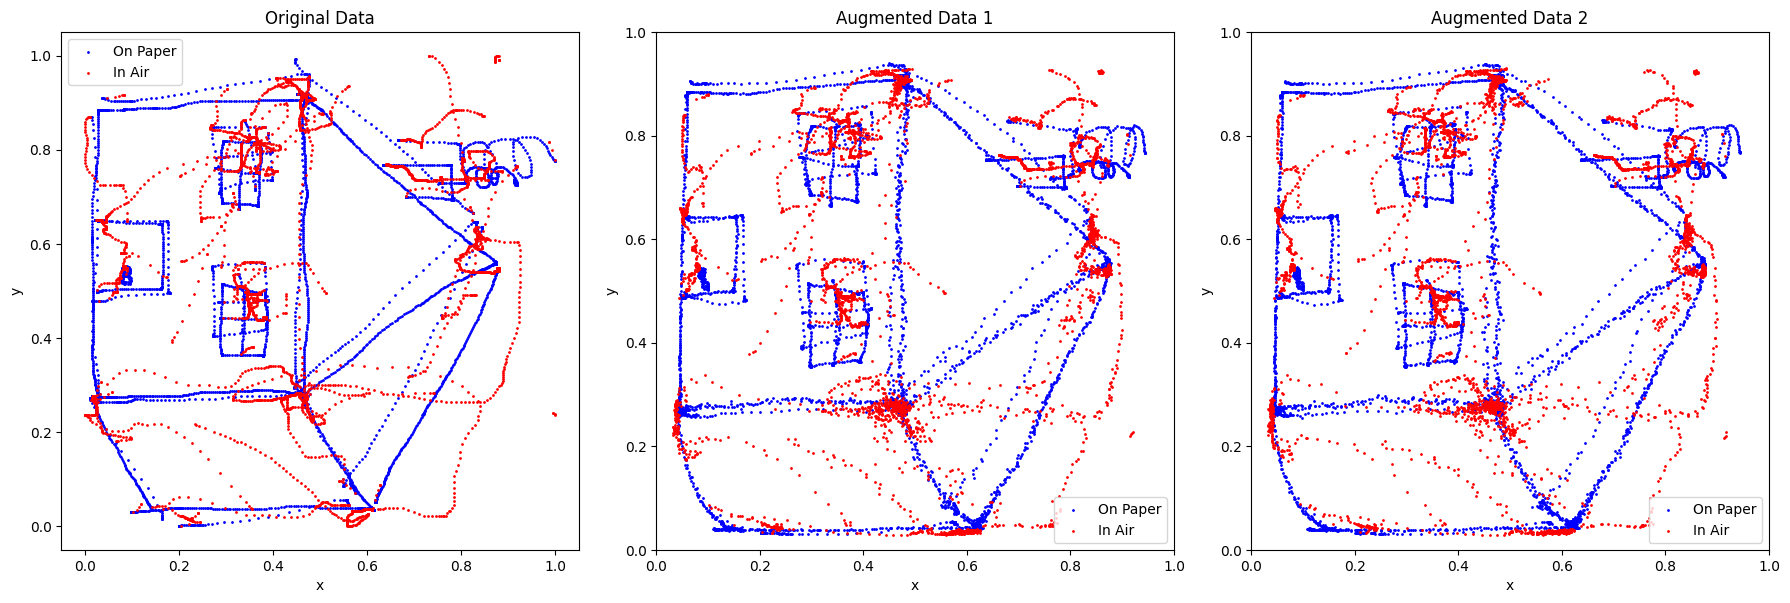

Epoch 91/300: 100%|██████████| 18/18 [00:00<00:00, 59.90batch/s, Total Loss=0.000147, Reconstruction Loss=0.000141, KL Loss=6.2] 


Epoch 91: Total Loss = 0.000196, Reconstruction Loss = 0.000190, KL Divergence Loss = 6.068081
MAE = 0.247425, MSE = 0.087770, NRMSE = 0.296260


Epoch 92/300: 100%|██████████| 18/18 [00:00<00:00, 51.90batch/s, Total Loss=0.000218, Reconstruction Loss=0.000211, KL Loss=6.15]


Epoch 92: Total Loss = 0.000219, Reconstruction Loss = 0.000213, KL Divergence Loss = 6.084888
MAE = 0.247309, MSE = 0.087741, NRMSE = 0.296212


Epoch 93/300: 100%|██████████| 18/18 [00:00<00:00, 58.72batch/s, Total Loss=0.000269, Reconstruction Loss=0.000263, KL Loss=6.15]


Epoch 93: Total Loss = 0.000231, Reconstruction Loss = 0.000225, KL Divergence Loss = 6.098970
MAE = 0.247254, MSE = 0.087750, NRMSE = 0.296226


Epoch 94/300: 100%|██████████| 18/18 [00:00<00:00, 49.33batch/s, Total Loss=0.000183, Reconstruction Loss=0.000177, KL Loss=6.1] 


Epoch 94: Total Loss = 0.000247, Reconstruction Loss = 0.000241, KL Divergence Loss = 6.101668
MAE = 0.246337, MSE = 0.087388, NRMSE = 0.295614


Epoch 95/300: 100%|██████████| 18/18 [00:00<00:00, 60.76batch/s, Total Loss=0.000305, Reconstruction Loss=0.000299, KL Loss=6.14]


Epoch 95: Total Loss = 0.000197, Reconstruction Loss = 0.000191, KL Divergence Loss = 6.113159
MAE = 0.247242, MSE = 0.087568, NRMSE = 0.295919


Epoch 96/300: 100%|██████████| 18/18 [00:00<00:00, 52.28batch/s, Total Loss=0.000162, Reconstruction Loss=0.000156, KL Loss=6.11]


Epoch 96: Total Loss = 0.000209, Reconstruction Loss = 0.000202, KL Divergence Loss = 6.120655
MAE = 0.246985, MSE = 0.087875, NRMSE = 0.296436


Epoch 97/300: 100%|██████████| 18/18 [00:00<00:00, 58.34batch/s, Total Loss=0.000155, Reconstruction Loss=0.000149, KL Loss=6.09]


Epoch 97: Total Loss = 0.000263, Reconstruction Loss = 0.000257, KL Divergence Loss = 6.126885
MAE = 0.246986, MSE = 0.087324, NRMSE = 0.295506


Epoch 98/300: 100%|██████████| 18/18 [00:00<00:00, 52.47batch/s, Total Loss=0.000359, Reconstruction Loss=0.000353, KL Loss=6.12]


Epoch 98: Total Loss = 0.000233, Reconstruction Loss = 0.000227, KL Divergence Loss = 6.130121
MAE = 0.247770, MSE = 0.087776, NRMSE = 0.296271


Epoch 99/300: 100%|██████████| 18/18 [00:00<00:00, 69.25batch/s, Total Loss=0.000262, Reconstruction Loss=0.000256, KL Loss=6.22]


Epoch 99: Total Loss = 0.000214, Reconstruction Loss = 0.000208, KL Divergence Loss = 6.134981
MAE = 0.248347, MSE = 0.088213, NRMSE = 0.297007


Epoch 100/300: 100%|██████████| 18/18 [00:00<00:00, 46.65batch/s, Total Loss=0.000294, Reconstruction Loss=0.000288, KL Loss=6.11]


Epoch 100: Total Loss = 0.000269, Reconstruction Loss = 0.000263, KL Divergence Loss = 6.135489
MAE = 0.248064, MSE = 0.088152, NRMSE = 0.296904


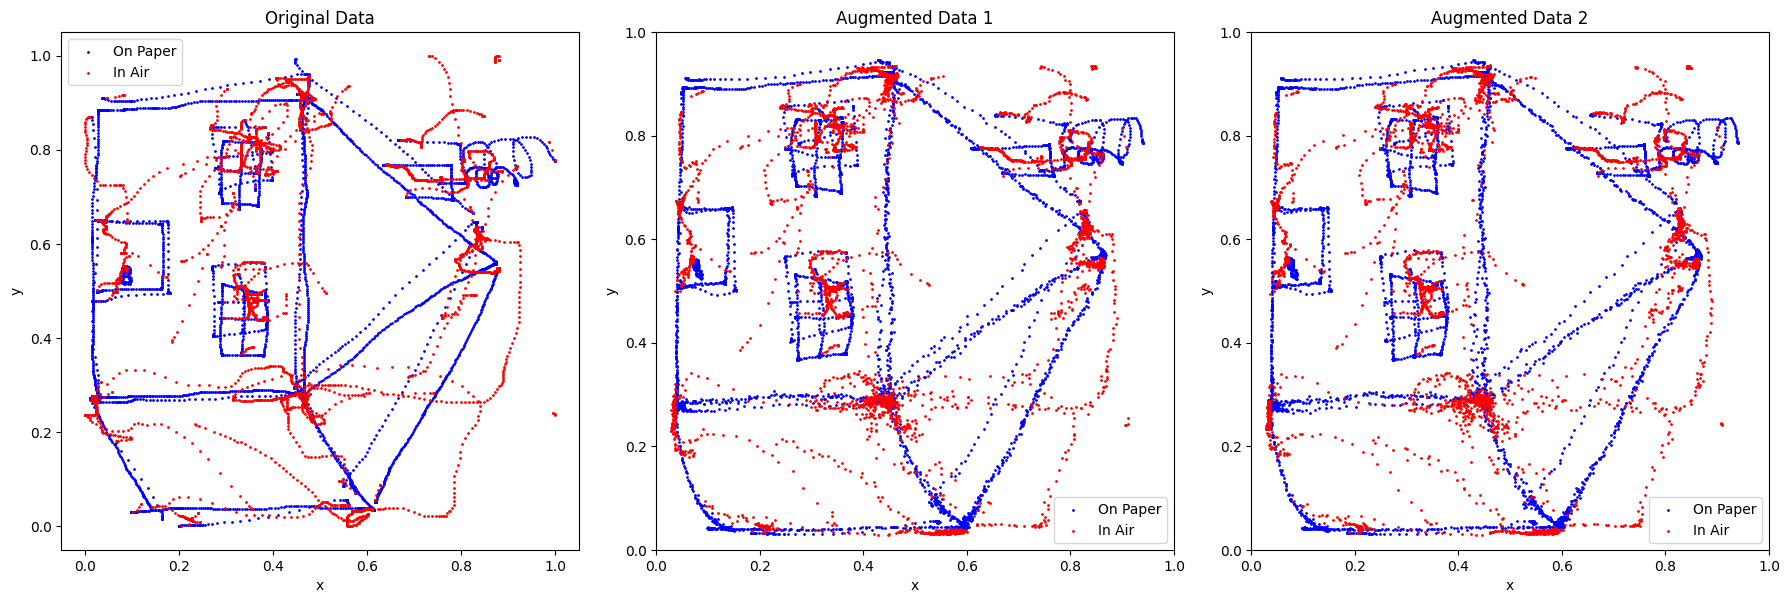

Epoch 101/300: 100%|██████████| 18/18 [00:00<00:00, 65.37batch/s, Total Loss=0.00016, Reconstruction Loss=0.000154, KL Loss=6.11] 


Epoch 101: Total Loss = 0.000229, Reconstruction Loss = 0.000223, KL Divergence Loss = 6.137962
MAE = 0.248371, MSE = 0.088271, NRMSE = 0.297105


Epoch 102/300: 100%|██████████| 18/18 [00:00<00:00, 52.42batch/s, Total Loss=0.000134, Reconstruction Loss=0.000128, KL Loss=6.25]


Epoch 102: Total Loss = 0.000167, Reconstruction Loss = 0.000161, KL Divergence Loss = 6.146041
MAE = 0.248306, MSE = 0.088247, NRMSE = 0.297065


Epoch 103/300: 100%|██████████| 18/18 [00:00<00:00, 64.57batch/s, Total Loss=0.000302, Reconstruction Loss=0.000296, KL Loss=6.11]


Epoch 103: Total Loss = 0.000201, Reconstruction Loss = 0.000195, KL Divergence Loss = 6.160576
MAE = 0.248018, MSE = 0.088021, NRMSE = 0.296684


Epoch 104/300: 100%|██████████| 18/18 [00:00<00:00, 53.69batch/s, Total Loss=0.000179, Reconstruction Loss=0.000173, KL Loss=6.19]


Epoch 104: Total Loss = 0.000236, Reconstruction Loss = 0.000229, KL Divergence Loss = 6.161757
MAE = 0.248224, MSE = 0.088057, NRMSE = 0.296745


Epoch 105/300: 100%|██████████| 18/18 [00:00<00:00, 67.96batch/s, Total Loss=0.000199, Reconstruction Loss=0.000193, KL Loss=6.19]


Epoch 105: Total Loss = 0.000160, Reconstruction Loss = 0.000154, KL Divergence Loss = 6.172557
MAE = 0.247158, MSE = 0.087583, NRMSE = 0.295944


Epoch 106/300: 100%|██████████| 18/18 [00:00<00:00, 53.13batch/s, Total Loss=0.000174, Reconstruction Loss=0.000168, KL Loss=6]   


Epoch 106: Total Loss = 0.000152, Reconstruction Loss = 0.000146, KL Divergence Loss = 6.186163
MAE = 0.247557, MSE = 0.088121, NRMSE = 0.296852


Epoch 107/300: 100%|██████████| 18/18 [00:00<00:00, 66.68batch/s, Total Loss=0.000175, Reconstruction Loss=0.000169, KL Loss=6.26]


Epoch 107: Total Loss = 0.000171, Reconstruction Loss = 0.000165, KL Divergence Loss = 6.206547
MAE = 0.247487, MSE = 0.087735, NRMSE = 0.296201


Epoch 108/300: 100%|██████████| 18/18 [00:00<00:00, 50.19batch/s, Total Loss=0.000274, Reconstruction Loss=0.000268, KL Loss=6.33]


Epoch 108: Total Loss = 0.000208, Reconstruction Loss = 0.000202, KL Divergence Loss = 6.221008
MAE = 0.246625, MSE = 0.087121, NRMSE = 0.295163


Epoch 109/300: 100%|██████████| 18/18 [00:00<00:00, 65.50batch/s, Total Loss=0.000406, Reconstruction Loss=0.0004, KL Loss=6.19]  


Epoch 109: Total Loss = 0.000287, Reconstruction Loss = 0.000281, KL Divergence Loss = 6.213718
MAE = 0.246694, MSE = 0.087253, NRMSE = 0.295387


Epoch 110/300: 100%|██████████| 18/18 [00:00<00:00, 52.96batch/s, Total Loss=0.000178, Reconstruction Loss=0.000171, KL Loss=6.23]


Epoch 110: Total Loss = 0.000243, Reconstruction Loss = 0.000236, KL Divergence Loss = 6.193461
MAE = 0.248101, MSE = 0.088268, NRMSE = 0.297099


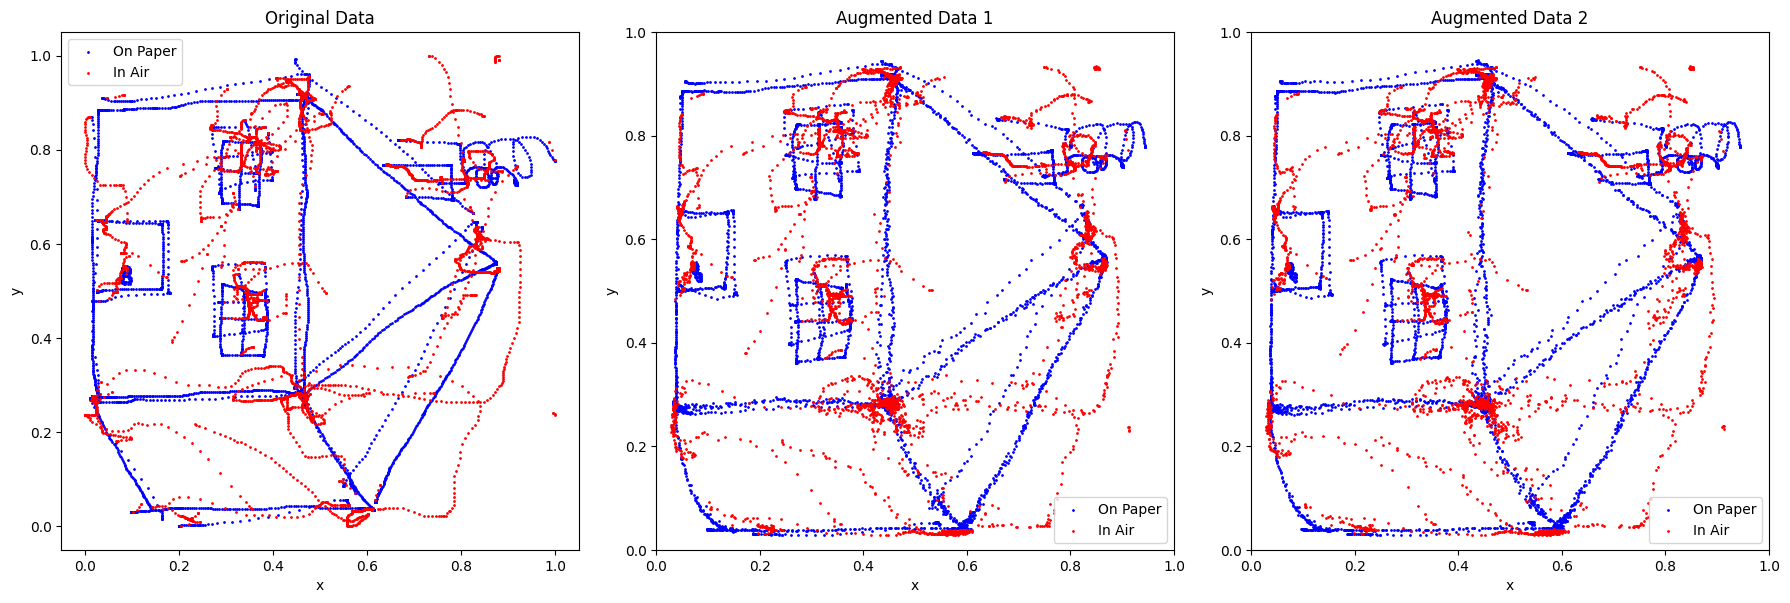

Epoch 111/300: 100%|██████████| 18/18 [00:00<00:00, 62.02batch/s, Total Loss=0.000171, Reconstruction Loss=0.000164, KL Loss=6.11]


Epoch 111: Total Loss = 0.000173, Reconstruction Loss = 0.000166, KL Divergence Loss = 6.190464
MAE = 0.246951, MSE = 0.087601, NRMSE = 0.295974


Epoch 112/300: 100%|██████████| 18/18 [00:00<00:00, 52.65batch/s, Total Loss=0.000192, Reconstruction Loss=0.000186, KL Loss=6.23]


Epoch 112: Total Loss = 0.000171, Reconstruction Loss = 0.000165, KL Divergence Loss = 6.203199
MAE = 0.248279, MSE = 0.088158, NRMSE = 0.296914


Epoch 113/300: 100%|██████████| 18/18 [00:00<00:00, 68.15batch/s, Total Loss=0.000135, Reconstruction Loss=0.000129, KL Loss=6.2] 


Epoch 113: Total Loss = 0.000181, Reconstruction Loss = 0.000175, KL Divergence Loss = 6.216795
MAE = 0.248058, MSE = 0.087755, NRMSE = 0.296235


Epoch 114/300: 100%|██████████| 18/18 [00:00<00:00, 52.89batch/s, Total Loss=0.000301, Reconstruction Loss=0.000295, KL Loss=6.09]


Epoch 114: Total Loss = 0.000261, Reconstruction Loss = 0.000254, KL Divergence Loss = 6.213991
MAE = 0.247014, MSE = 0.087657, NRMSE = 0.296070


Epoch 115/300: 100%|██████████| 18/18 [00:00<00:00, 67.65batch/s, Total Loss=0.000126, Reconstruction Loss=0.00012, KL Loss=6.36] 


Epoch 115: Total Loss = 0.000141, Reconstruction Loss = 0.000135, KL Divergence Loss = 6.215264
MAE = 0.248998, MSE = 0.088782, NRMSE = 0.297963


Epoch 116/300: 100%|██████████| 18/18 [00:00<00:00, 53.31batch/s, Total Loss=0.000161, Reconstruction Loss=0.000154, KL Loss=6.21]


Epoch 116: Total Loss = 0.000174, Reconstruction Loss = 0.000168, KL Divergence Loss = 6.227354
MAE = 0.247912, MSE = 0.088153, NRMSE = 0.296906


Epoch 117/300: 100%|██████████| 18/18 [00:00<00:00, 61.69batch/s, Total Loss=0.000144, Reconstruction Loss=0.000138, KL Loss=6.27]


Epoch 117: Total Loss = 0.000151, Reconstruction Loss = 0.000144, KL Divergence Loss = 6.242289
MAE = 0.247290, MSE = 0.087805, NRMSE = 0.296320


Epoch 118/300: 100%|██████████| 18/18 [00:00<00:00, 45.88batch/s, Total Loss=0.000495, Reconstruction Loss=0.000489, KL Loss=6.29]


Epoch 118: Total Loss = 0.000358, Reconstruction Loss = 0.000352, KL Divergence Loss = 6.245795
MAE = 0.248795, MSE = 0.088492, NRMSE = 0.297476


Epoch 119/300: 100%|██████████| 18/18 [00:00<00:00, 67.40batch/s, Total Loss=0.00018, Reconstruction Loss=0.000174, KL Loss=6]    


Epoch 119: Total Loss = 0.000233, Reconstruction Loss = 0.000227, KL Divergence Loss = 6.198909
MAE = 0.248316, MSE = 0.088242, NRMSE = 0.297056


Epoch 120/300: 100%|██████████| 18/18 [00:00<00:00, 50.80batch/s, Total Loss=0.00023, Reconstruction Loss=0.000224, KL Loss=6.12] 


Epoch 120: Total Loss = 0.000178, Reconstruction Loss = 0.000172, KL Divergence Loss = 6.191618
MAE = 0.246311, MSE = 0.087482, NRMSE = 0.295773


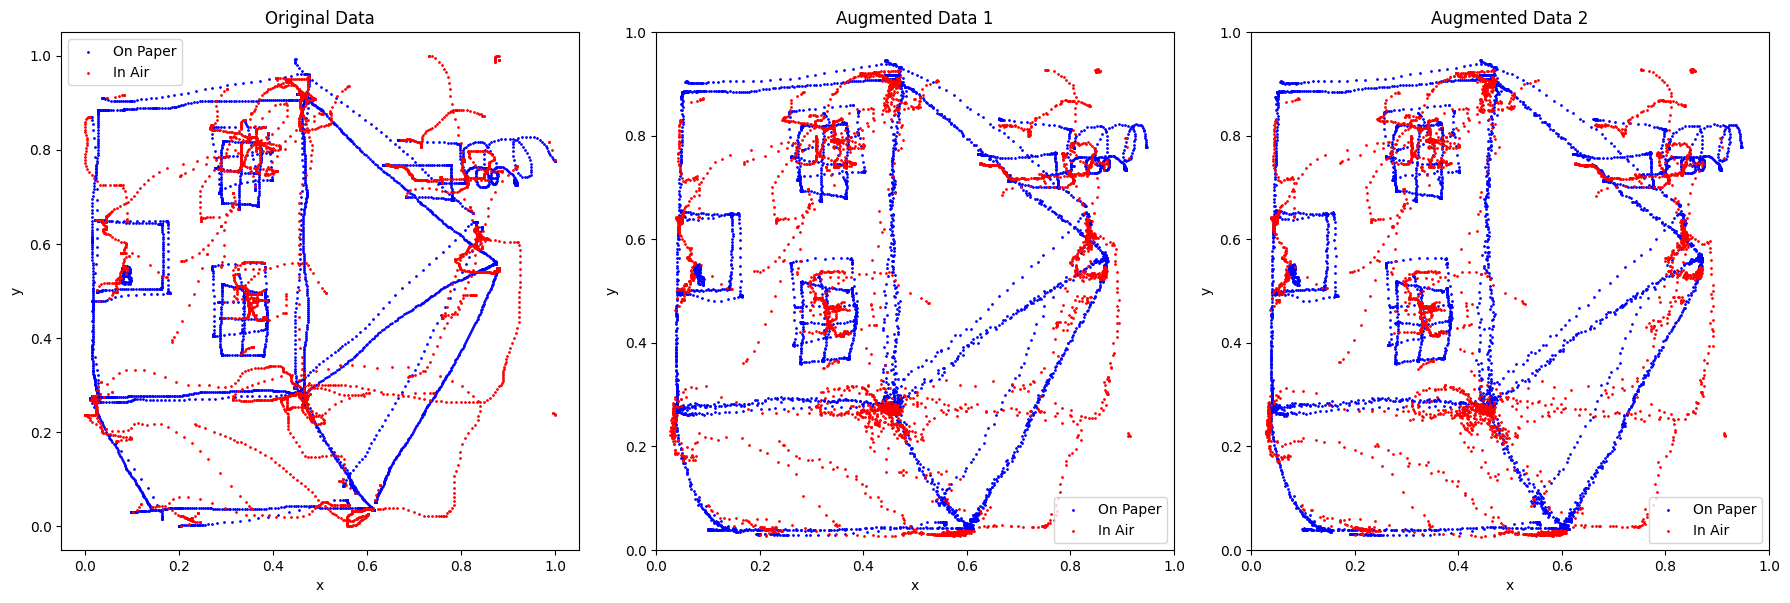

Epoch 121/300: 100%|██████████| 18/18 [00:00<00:00, 61.52batch/s, Total Loss=0.00013, Reconstruction Loss=0.000123, KL Loss=6.19] 


Epoch 121: Total Loss = 0.000141, Reconstruction Loss = 0.000135, KL Divergence Loss = 6.203043
MAE = 0.247093, MSE = 0.087487, NRMSE = 0.295782


Epoch 122/300: 100%|██████████| 18/18 [00:00<00:00, 50.25batch/s, Total Loss=0.000228, Reconstruction Loss=0.000222, KL Loss=6.16]


Epoch 122: Total Loss = 0.000148, Reconstruction Loss = 0.000142, KL Divergence Loss = 6.228854
MAE = 0.247490, MSE = 0.087945, NRMSE = 0.296556


Epoch 123/300: 100%|██████████| 18/18 [00:00<00:00, 65.11batch/s, Total Loss=0.000123, Reconstruction Loss=0.000117, KL Loss=6.27]


Epoch 123: Total Loss = 0.000147, Reconstruction Loss = 0.000141, KL Divergence Loss = 6.242446
MAE = 0.247190, MSE = 0.087796, NRMSE = 0.296303


Epoch 124/300: 100%|██████████| 18/18 [00:00<00:00, 52.60batch/s, Total Loss=0.000148, Reconstruction Loss=0.000142, KL Loss=6.31]


Epoch 124: Total Loss = 0.000159, Reconstruction Loss = 0.000153, KL Divergence Loss = 6.260256
MAE = 0.248416, MSE = 0.088425, NRMSE = 0.297363


Epoch 125/300: 100%|██████████| 18/18 [00:00<00:00, 66.82batch/s, Total Loss=0.000141, Reconstruction Loss=0.000135, KL Loss=6.37]


Epoch 125: Total Loss = 0.000208, Reconstruction Loss = 0.000202, KL Divergence Loss = 6.267787
MAE = 0.247999, MSE = 0.088146, NRMSE = 0.296894


Epoch 126/300: 100%|██████████| 18/18 [00:00<00:00, 51.62batch/s, Total Loss=0.000164, Reconstruction Loss=0.000157, KL Loss=6.3] 


Epoch 126: Total Loss = 0.000191, Reconstruction Loss = 0.000185, KL Divergence Loss = 6.258456
MAE = 0.247902, MSE = 0.088202, NRMSE = 0.296988


Epoch 127/300: 100%|██████████| 18/18 [00:00<00:00, 66.76batch/s, Total Loss=0.000298, Reconstruction Loss=0.000292, KL Loss=6.21]


Epoch 127: Total Loss = 0.000219, Reconstruction Loss = 0.000213, KL Divergence Loss = 6.254952
MAE = 0.248228, MSE = 0.088534, NRMSE = 0.297546


Epoch 128/300: 100%|██████████| 18/18 [00:00<00:00, 51.75batch/s, Total Loss=0.000161, Reconstruction Loss=0.000155, KL Loss=6.35]


Epoch 128: Total Loss = 0.000171, Reconstruction Loss = 0.000165, KL Divergence Loss = 6.251295
MAE = 0.247569, MSE = 0.087937, NRMSE = 0.296541


Epoch 129/300: 100%|██████████| 18/18 [00:00<00:00, 67.20batch/s, Total Loss=0.000154, Reconstruction Loss=0.000148, KL Loss=6.33]


Epoch 129: Total Loss = 0.000163, Reconstruction Loss = 0.000157, KL Divergence Loss = 6.253379
MAE = 0.247784, MSE = 0.088091, NRMSE = 0.296801


Epoch 130/300: 100%|██████████| 18/18 [00:00<00:00, 50.86batch/s, Total Loss=0.000206, Reconstruction Loss=0.0002, KL Loss=6.18]  


Epoch 130: Total Loss = 0.000174, Reconstruction Loss = 0.000168, KL Divergence Loss = 6.258612
MAE = 0.248192, MSE = 0.088342, NRMSE = 0.297223


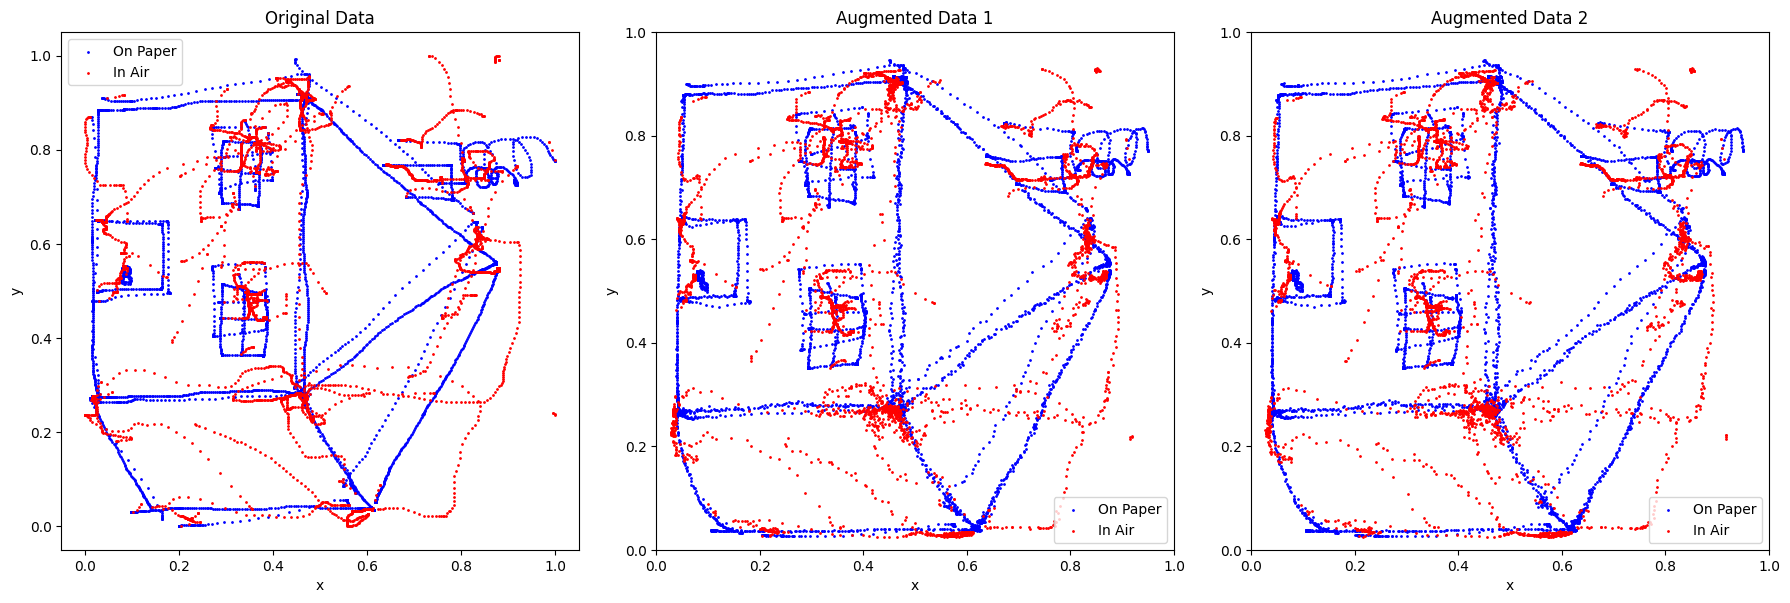

Epoch 131/300: 100%|██████████| 18/18 [00:00<00:00, 59.84batch/s, Total Loss=0.000157, Reconstruction Loss=0.000151, KL Loss=6.22]


Epoch 131: Total Loss = 0.000204, Reconstruction Loss = 0.000198, KL Divergence Loss = 6.261832
MAE = 0.248562, MSE = 0.088314, NRMSE = 0.297177


Epoch 132/300: 100%|██████████| 18/18 [00:00<00:00, 51.87batch/s, Total Loss=0.000155, Reconstruction Loss=0.000148, KL Loss=6.32]


Epoch 132: Total Loss = 0.000245, Reconstruction Loss = 0.000239, KL Divergence Loss = 6.254039
MAE = 0.249262, MSE = 0.089013, NRMSE = 0.298350


Epoch 133/300: 100%|██████████| 18/18 [00:00<00:00, 63.05batch/s, Total Loss=0.000187, Reconstruction Loss=0.00018, KL Loss=6.3]  


Epoch 133: Total Loss = 0.000220, Reconstruction Loss = 0.000214, KL Divergence Loss = 6.242405
MAE = 0.247101, MSE = 0.087892, NRMSE = 0.296465


Epoch 134/300: 100%|██████████| 18/18 [00:00<00:00, 43.52batch/s, Total Loss=0.000138, Reconstruction Loss=0.000131, KL Loss=6.21]


Epoch 134: Total Loss = 0.000161, Reconstruction Loss = 0.000155, KL Divergence Loss = 6.234728
MAE = 0.246961, MSE = 0.087285, NRMSE = 0.295440


Epoch 135/300: 100%|██████████| 18/18 [00:00<00:00, 67.67batch/s, Total Loss=0.000153, Reconstruction Loss=0.000146, KL Loss=6.31]


Epoch 135: Total Loss = 0.000136, Reconstruction Loss = 0.000130, KL Divergence Loss = 6.242997
MAE = 0.248893, MSE = 0.088584, NRMSE = 0.297630


Epoch 136/300: 100%|██████████| 18/18 [00:00<00:00, 50.21batch/s, Total Loss=0.000139, Reconstruction Loss=0.000133, KL Loss=6.43]


Epoch 136: Total Loss = 0.000140, Reconstruction Loss = 0.000134, KL Divergence Loss = 6.257959
MAE = 0.248235, MSE = 0.088330, NRMSE = 0.297204


Epoch 137/300: 100%|██████████| 18/18 [00:00<00:00, 67.51batch/s, Total Loss=0.000177, Reconstruction Loss=0.000171, KL Loss=6.26]


Epoch 137: Total Loss = 0.000146, Reconstruction Loss = 0.000140, KL Divergence Loss = 6.271551
MAE = 0.247971, MSE = 0.088133, NRMSE = 0.296871


Epoch 138/300: 100%|██████████| 18/18 [00:00<00:00, 48.80batch/s, Total Loss=0.000191, Reconstruction Loss=0.000184, KL Loss=6.2] 


Epoch 138: Total Loss = 0.000201, Reconstruction Loss = 0.000194, KL Divergence Loss = 6.277980
MAE = 0.247589, MSE = 0.087964, NRMSE = 0.296587


Epoch 139/300: 100%|██████████| 18/18 [00:00<00:00, 61.79batch/s, Total Loss=0.000142, Reconstruction Loss=0.000136, KL Loss=6.34]


Epoch 139: Total Loss = 0.000183, Reconstruction Loss = 0.000176, KL Divergence Loss = 6.273191
MAE = 0.247197, MSE = 0.088111, NRMSE = 0.296834


Epoch 140/300: 100%|██████████| 18/18 [00:00<00:00, 52.74batch/s, Total Loss=0.000142, Reconstruction Loss=0.000136, KL Loss=6.23]


Epoch 140: Total Loss = 0.000184, Reconstruction Loss = 0.000178, KL Divergence Loss = 6.271330
MAE = 0.248198, MSE = 0.088442, NRMSE = 0.297392


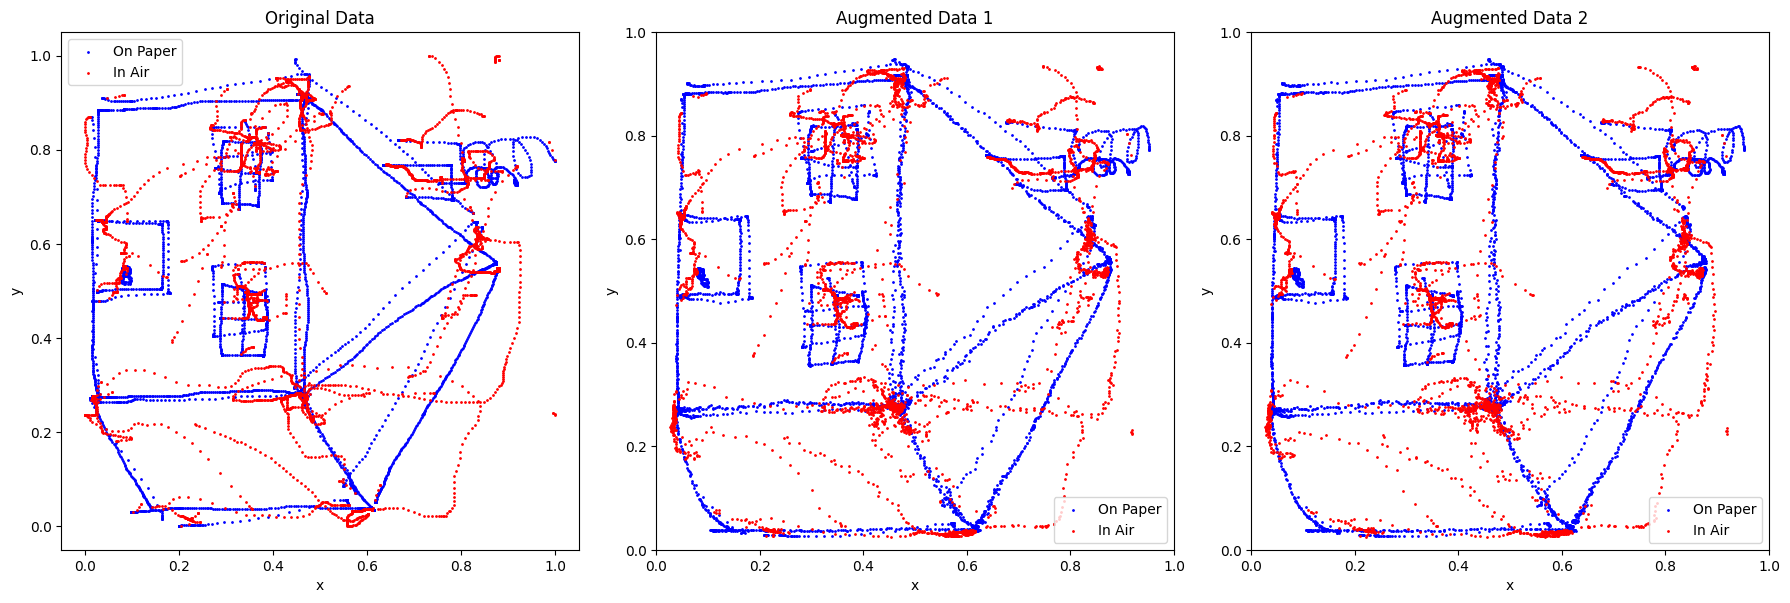

Epoch 141/300: 100%|██████████| 18/18 [00:00<00:00, 46.82batch/s, Total Loss=0.000304, Reconstruction Loss=0.000297, KL Loss=6.31]


Epoch 141: Total Loss = 0.000151, Reconstruction Loss = 0.000145, KL Divergence Loss = 6.277622
MAE = 0.247907, MSE = 0.088013, NRMSE = 0.296669


Epoch 142/300: 100%|██████████| 18/18 [00:00<00:00, 47.07batch/s, Total Loss=0.000154, Reconstruction Loss=0.000147, KL Loss=6.29]


Epoch 142: Total Loss = 0.000158, Reconstruction Loss = 0.000152, KL Divergence Loss = 6.281602
MAE = 0.247198, MSE = 0.087778, NRMSE = 0.296273


Epoch 143/300: 100%|██████████| 18/18 [00:00<00:00, 59.47batch/s, Total Loss=0.000173, Reconstruction Loss=0.000167, KL Loss=6.33]


Epoch 143: Total Loss = 0.000217, Reconstruction Loss = 0.000211, KL Divergence Loss = 6.283672
MAE = 0.248702, MSE = 0.088580, NRMSE = 0.297624


Epoch 144/300: 100%|██████████| 18/18 [00:00<00:00, 42.62batch/s, Total Loss=0.00015, Reconstruction Loss=0.000144, KL Loss=6.32] 


Epoch 144: Total Loss = 0.000183, Reconstruction Loss = 0.000177, KL Divergence Loss = 6.269777
MAE = 0.249276, MSE = 0.088990, NRMSE = 0.298312


Epoch 145/300: 100%|██████████| 18/18 [00:00<00:00, 62.82batch/s, Total Loss=0.000101, Reconstruction Loss=9.47e-5, KL Loss=6.28] 


Epoch 145: Total Loss = 0.000173, Reconstruction Loss = 0.000167, KL Divergence Loss = 6.263141
MAE = 0.248198, MSE = 0.088059, NRMSE = 0.296747


Epoch 146/300: 100%|██████████| 18/18 [00:00<00:00, 45.64batch/s, Total Loss=0.000153, Reconstruction Loss=0.000146, KL Loss=6.18]


Epoch 146: Total Loss = 0.000147, Reconstruction Loss = 0.000140, KL Divergence Loss = 6.267533
MAE = 0.247293, MSE = 0.087793, NRMSE = 0.296298


Epoch 147/300: 100%|██████████| 18/18 [00:00<00:00, 47.05batch/s, Total Loss=9.88e-5, Reconstruction Loss=9.26e-5, KL Loss=6.21]  


Epoch 147: Total Loss = 0.000137, Reconstruction Loss = 0.000131, KL Divergence Loss = 6.273465
MAE = 0.247285, MSE = 0.087948, NRMSE = 0.296561


Epoch 148/300: 100%|██████████| 18/18 [00:00<00:00, 63.59batch/s, Total Loss=0.000164, Reconstruction Loss=0.000158, KL Loss=6.2] 


Epoch 148: Total Loss = 0.000117, Reconstruction Loss = 0.000110, KL Divergence Loss = 6.288749
MAE = 0.247829, MSE = 0.087994, NRMSE = 0.296638


Epoch 149/300: 100%|██████████| 18/18 [00:00<00:00, 49.07batch/s, Total Loss=9.53e-5, Reconstruction Loss=8.89e-5, KL Loss=6.39]  


Epoch 149: Total Loss = 0.000133, Reconstruction Loss = 0.000127, KL Divergence Loss = 6.299733
MAE = 0.247728, MSE = 0.088210, NRMSE = 0.297002


Epoch 150/300: 100%|██████████| 18/18 [00:00<00:00, 57.01batch/s, Total Loss=0.000137, Reconstruction Loss=0.000131, KL Loss=6.28]


Epoch 150: Total Loss = 0.000155, Reconstruction Loss = 0.000149, KL Divergence Loss = 6.310661
MAE = 0.248168, MSE = 0.088243, NRMSE = 0.297058


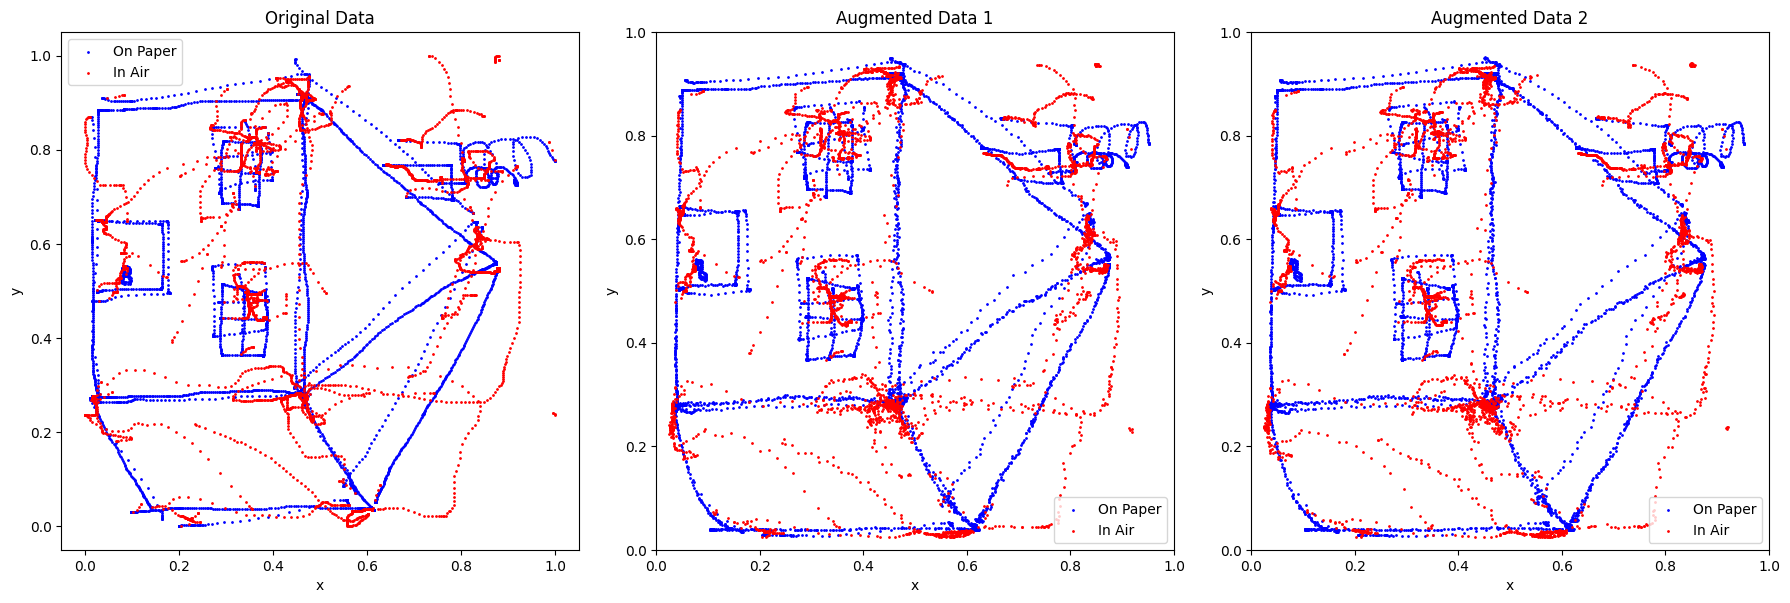

Epoch 151/300: 100%|██████████| 18/18 [00:00<00:00, 50.87batch/s, Total Loss=0.000145, Reconstruction Loss=0.000139, KL Loss=6.29]


Epoch 151: Total Loss = 0.000143, Reconstruction Loss = 0.000136, KL Divergence Loss = 6.319208
MAE = 0.249582, MSE = 0.089446, NRMSE = 0.299076


Epoch 152/300: 100%|██████████| 18/18 [00:00<00:00, 55.34batch/s, Total Loss=0.000138, Reconstruction Loss=0.000131, KL Loss=6.31]


Epoch 152: Total Loss = 0.000157, Reconstruction Loss = 0.000150, KL Divergence Loss = 6.320795
MAE = 0.249324, MSE = 0.088920, NRMSE = 0.298195


Epoch 153/300: 100%|██████████| 18/18 [00:00<00:00, 48.16batch/s, Total Loss=0.000114, Reconstruction Loss=0.000107, KL Loss=6.31]


Epoch 153: Total Loss = 0.000146, Reconstruction Loss = 0.000140, KL Divergence Loss = 6.321261
MAE = 0.247255, MSE = 0.087705, NRMSE = 0.296150


Epoch 154/300: 100%|██████████| 18/18 [00:00<00:00, 52.70batch/s, Total Loss=0.000392, Reconstruction Loss=0.000386, KL Loss=6.3] 


Epoch 154: Total Loss = 0.000223, Reconstruction Loss = 0.000216, KL Divergence Loss = 6.325366
MAE = 0.248043, MSE = 0.088175, NRMSE = 0.296943


Epoch 155/300: 100%|██████████| 18/18 [00:00<00:00, 56.59batch/s, Total Loss=0.000311, Reconstruction Loss=0.000305, KL Loss=6.35]


Epoch 155: Total Loss = 0.000206, Reconstruction Loss = 0.000200, KL Divergence Loss = 6.304863
MAE = 0.248297, MSE = 0.088325, NRMSE = 0.297195


Epoch 156/300: 100%|██████████| 18/18 [00:00<00:00, 44.99batch/s, Total Loss=0.000183, Reconstruction Loss=0.000177, KL Loss=6.21]


Epoch 156: Total Loss = 0.000251, Reconstruction Loss = 0.000245, KL Divergence Loss = 6.283479
MAE = 0.249435, MSE = 0.089102, NRMSE = 0.298500


Epoch 157/300: 100%|██████████| 18/18 [00:00<00:00, 62.12batch/s, Total Loss=0.000118, Reconstruction Loss=0.000112, KL Loss=6.34]


Epoch 157: Total Loss = 0.000148, Reconstruction Loss = 0.000142, KL Divergence Loss = 6.269407
MAE = 0.247603, MSE = 0.088305, NRMSE = 0.297161


Epoch 158/300: 100%|██████████| 18/18 [00:00<00:00, 48.88batch/s, Total Loss=0.000112, Reconstruction Loss=0.000106, KL Loss=6.4] 


Epoch 158: Total Loss = 0.000134, Reconstruction Loss = 0.000128, KL Divergence Loss = 6.277657
MAE = 0.247433, MSE = 0.088081, NRMSE = 0.296784


Epoch 159/300: 100%|██████████| 18/18 [00:00<00:00, 58.72batch/s, Total Loss=0.0001, Reconstruction Loss=9.42e-5, KL Loss=6.22]   


Epoch 159: Total Loss = 0.000110, Reconstruction Loss = 0.000103, KL Divergence Loss = 6.287787
MAE = 0.247786, MSE = 0.088277, NRMSE = 0.297115


Epoch 160/300: 100%|██████████| 18/18 [00:00<00:00, 48.20batch/s, Total Loss=0.000116, Reconstruction Loss=0.00011, KL Loss=6.31] 


Epoch 160: Total Loss = 0.000113, Reconstruction Loss = 0.000106, KL Divergence Loss = 6.306379
MAE = 0.247884, MSE = 0.088243, NRMSE = 0.297057


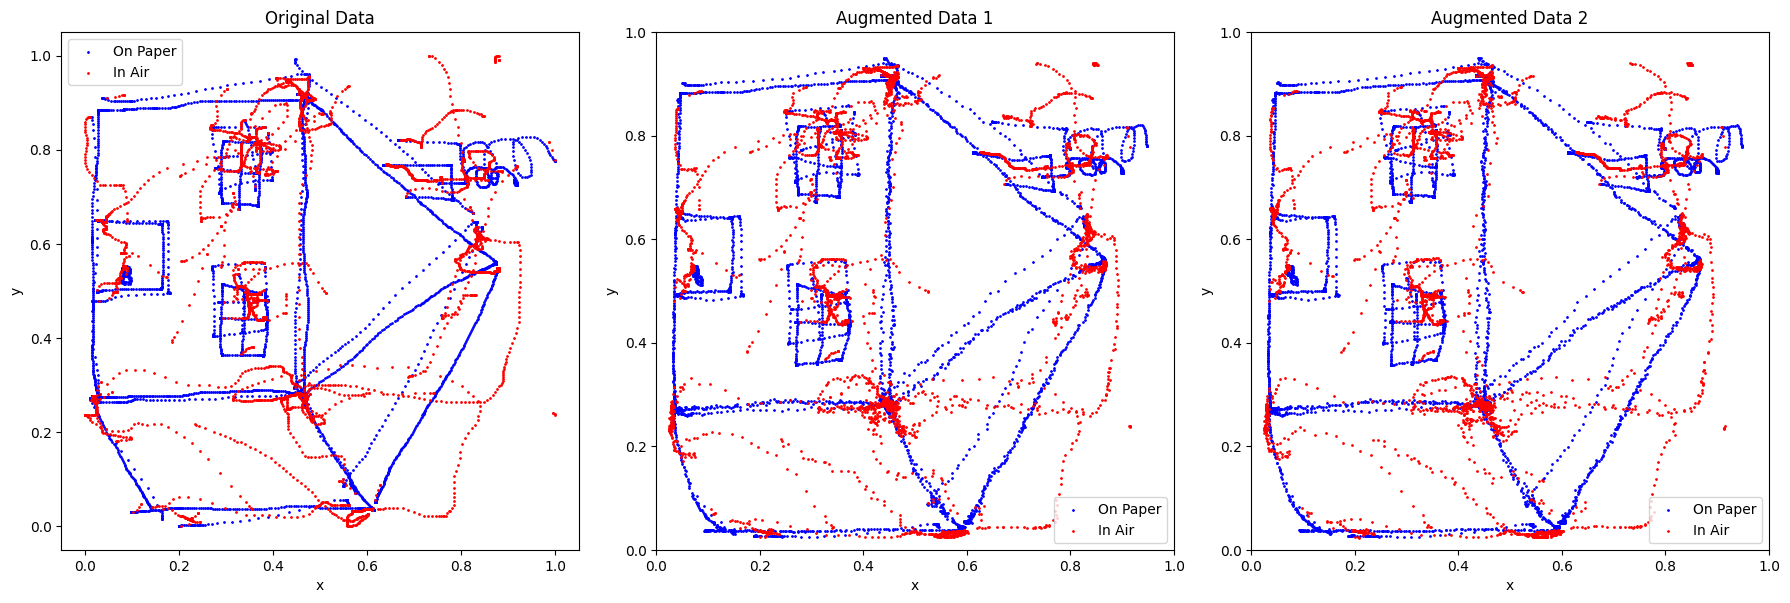

Epoch 161/300: 100%|██████████| 18/18 [00:00<00:00, 60.08batch/s, Total Loss=0.000397, Reconstruction Loss=0.00039, KL Loss=6.42] 


Epoch 161: Total Loss = 0.000168, Reconstruction Loss = 0.000162, KL Divergence Loss = 6.323246
MAE = 0.248515, MSE = 0.088603, NRMSE = 0.297663


Epoch 162/300: 100%|██████████| 18/18 [00:00<00:00, 63.57batch/s, Total Loss=0.000353, Reconstruction Loss=0.000347, KL Loss=6.18]


Epoch 162: Total Loss = 0.000345, Reconstruction Loss = 0.000339, KL Divergence Loss = 6.300189
MAE = 0.249292, MSE = 0.088930, NRMSE = 0.298211


Epoch 163/300: 100%|██████████| 18/18 [00:00<00:00, 65.43batch/s, Total Loss=0.000205, Reconstruction Loss=0.000199, KL Loss=6.19]


Epoch 163: Total Loss = 0.000313, Reconstruction Loss = 0.000306, KL Divergence Loss = 6.237795
MAE = 0.246576, MSE = 0.087458, NRMSE = 0.295733


Epoch 164/300: 100%|██████████| 18/18 [00:00<00:00, 56.12batch/s, Total Loss=0.000113, Reconstruction Loss=0.000107, KL Loss=6.15]


Epoch 164: Total Loss = 0.000176, Reconstruction Loss = 0.000170, KL Divergence Loss = 6.203794
MAE = 0.250118, MSE = 0.089558, NRMSE = 0.299262


Epoch 165/300: 100%|██████████| 18/18 [00:00<00:00, 51.72batch/s, Total Loss=0.000122, Reconstruction Loss=0.000116, KL Loss=6.18]


Epoch 165: Total Loss = 0.000120, Reconstruction Loss = 0.000113, KL Divergence Loss = 6.209222
MAE = 0.249188, MSE = 0.089073, NRMSE = 0.298451


Epoch 166/300: 100%|██████████| 18/18 [00:00<00:00, 49.61batch/s, Total Loss=0.000122, Reconstruction Loss=0.000116, KL Loss=6.34]


Epoch 166: Total Loss = 0.000109, Reconstruction Loss = 0.000103, KL Divergence Loss = 6.233561
MAE = 0.248215, MSE = 0.088485, NRMSE = 0.297464


Epoch 167/300: 100%|██████████| 18/18 [00:00<00:00, 63.59batch/s, Total Loss=0.00013, Reconstruction Loss=0.000123, KL Loss=6.37] 


Epoch 167: Total Loss = 0.000107, Reconstruction Loss = 0.000101, KL Divergence Loss = 6.254343
MAE = 0.247796, MSE = 0.088074, NRMSE = 0.296773


Epoch 168/300: 100%|██████████| 18/18 [00:00<00:00, 50.54batch/s, Total Loss=0.000126, Reconstruction Loss=0.00012, KL Loss=6.38] 


Epoch 168: Total Loss = 0.000109, Reconstruction Loss = 0.000103, KL Divergence Loss = 6.273850
MAE = 0.250264, MSE = 0.089489, NRMSE = 0.299148


Epoch 169/300: 100%|██████████| 18/18 [00:00<00:00, 62.47batch/s, Total Loss=9.08e-5, Reconstruction Loss=8.47e-5, KL Loss=6.17]  


Epoch 169: Total Loss = 0.000132, Reconstruction Loss = 0.000126, KL Divergence Loss = 6.280858
MAE = 0.247894, MSE = 0.088123, NRMSE = 0.296855


Epoch 170/300: 100%|██████████| 18/18 [00:00<00:00, 48.03batch/s, Total Loss=0.000104, Reconstruction Loss=9.76e-5, KL Loss=6.22] 


Epoch 170: Total Loss = 0.000110, Reconstruction Loss = 0.000104, KL Divergence Loss = 6.295350
MAE = 0.249171, MSE = 0.089137, NRMSE = 0.298559


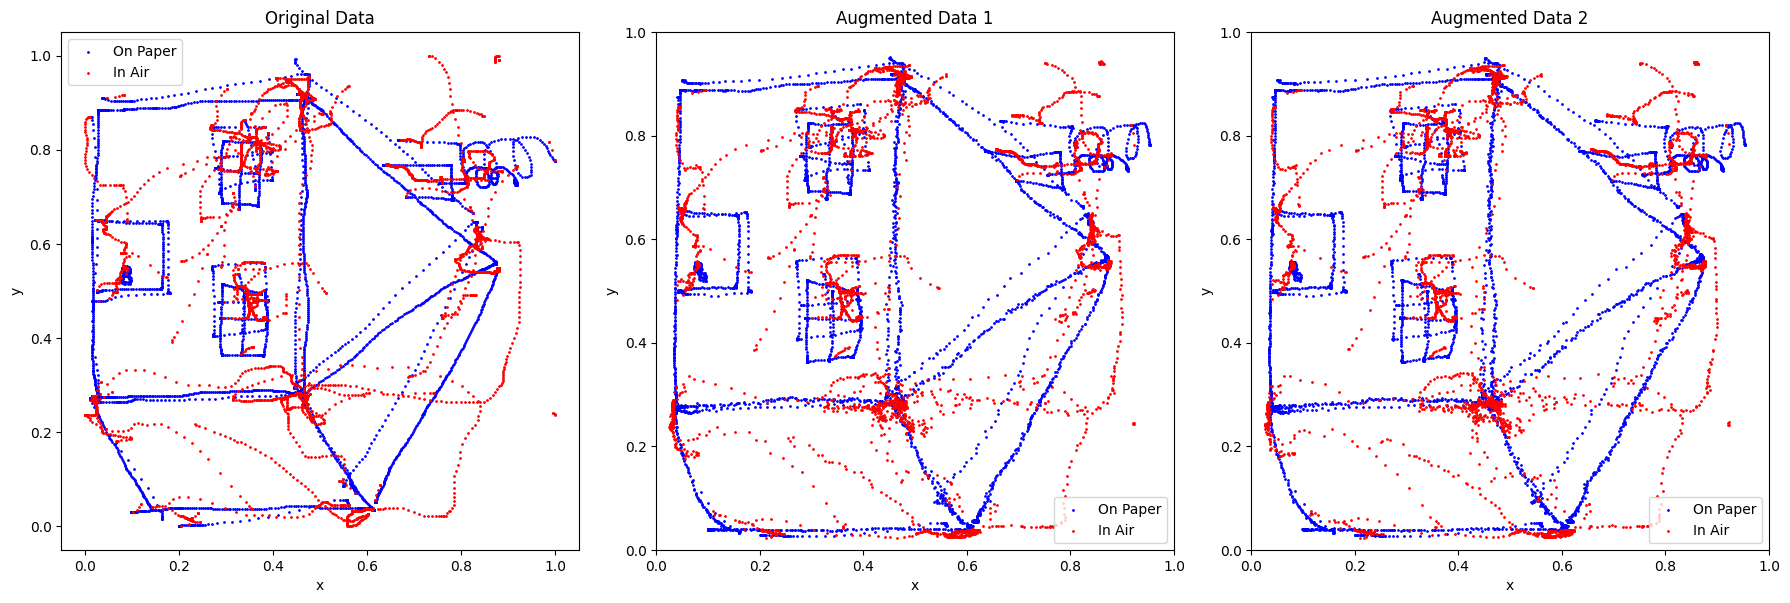

Epoch 171/300: 100%|██████████| 18/18 [00:00<00:00, 55.96batch/s, Total Loss=0.000118, Reconstruction Loss=0.000112, KL Loss=6.21]


Epoch 171: Total Loss = 0.000121, Reconstruction Loss = 0.000115, KL Divergence Loss = 6.304785
MAE = 0.248089, MSE = 0.088555, NRMSE = 0.297581


Epoch 172/300: 100%|██████████| 18/18 [00:00<00:00, 49.16batch/s, Total Loss=0.000146, Reconstruction Loss=0.00014, KL Loss=6.51] 


Epoch 172: Total Loss = 0.000139, Reconstruction Loss = 0.000133, KL Divergence Loss = 6.317978
MAE = 0.247524, MSE = 0.087825, NRMSE = 0.296353


Epoch 173/300: 100%|██████████| 18/18 [00:00<00:00, 62.05batch/s, Total Loss=0.000132, Reconstruction Loss=0.000126, KL Loss=6.32]


Epoch 173: Total Loss = 0.000163, Reconstruction Loss = 0.000156, KL Divergence Loss = 6.308280
MAE = 0.247413, MSE = 0.087897, NRMSE = 0.296475


Epoch 174/300: 100%|██████████| 18/18 [00:00<00:00, 48.32batch/s, Total Loss=0.000176, Reconstruction Loss=0.00017, KL Loss=6.24] 


Epoch 174: Total Loss = 0.000157, Reconstruction Loss = 0.000150, KL Divergence Loss = 6.307875
MAE = 0.248406, MSE = 0.088833, NRMSE = 0.298048


Epoch 175/300: 100%|██████████| 18/18 [00:00<00:00, 61.64batch/s, Total Loss=7.67e-5, Reconstruction Loss=7.04e-5, KL Loss=6.3]   


Epoch 175: Total Loss = 0.000110, Reconstruction Loss = 0.000104, KL Divergence Loss = 6.306000
MAE = 0.248943, MSE = 0.088734, NRMSE = 0.297882


Epoch 176/300: 100%|██████████| 18/18 [00:00<00:00, 49.70batch/s, Total Loss=0.000177, Reconstruction Loss=0.000171, KL Loss=6.35]


Epoch 176: Total Loss = 0.000109, Reconstruction Loss = 0.000103, KL Divergence Loss = 6.319957
MAE = 0.248881, MSE = 0.088831, NRMSE = 0.298045


Epoch 177/300: 100%|██████████| 18/18 [00:00<00:00, 59.09batch/s, Total Loss=0.000101, Reconstruction Loss=9.51e-5, KL Loss=6.29] 


Epoch 177: Total Loss = 0.000184, Reconstruction Loss = 0.000178, KL Divergence Loss = 6.318792
MAE = 0.248680, MSE = 0.088841, NRMSE = 0.298062


Epoch 178/300: 100%|██████████| 18/18 [00:00<00:00, 50.43batch/s, Total Loss=9.25e-5, Reconstruction Loss=8.6e-5, KL Loss=6.47] 


Epoch 178: Total Loss = 0.000089, Reconstruction Loss = 0.000083, KL Divergence Loss = 6.323442
MAE = 0.248546, MSE = 0.088603, NRMSE = 0.297663


Epoch 179/300: 100%|██████████| 18/18 [00:00<00:00, 60.73batch/s, Total Loss=9.27e-5, Reconstruction Loss=8.66e-5, KL Loss=6.17]  


Epoch 179: Total Loss = 0.000104, Reconstruction Loss = 0.000098, KL Divergence Loss = 6.334328
MAE = 0.249365, MSE = 0.089155, NRMSE = 0.298588


Epoch 180/300: 100%|██████████| 18/18 [00:00<00:00, 48.35batch/s, Total Loss=0.000176, Reconstruction Loss=0.000169, KL Loss=6.28]


Epoch 180: Total Loss = 0.000198, Reconstruction Loss = 0.000191, KL Divergence Loss = 6.340937
MAE = 0.249563, MSE = 0.088932, NRMSE = 0.298215


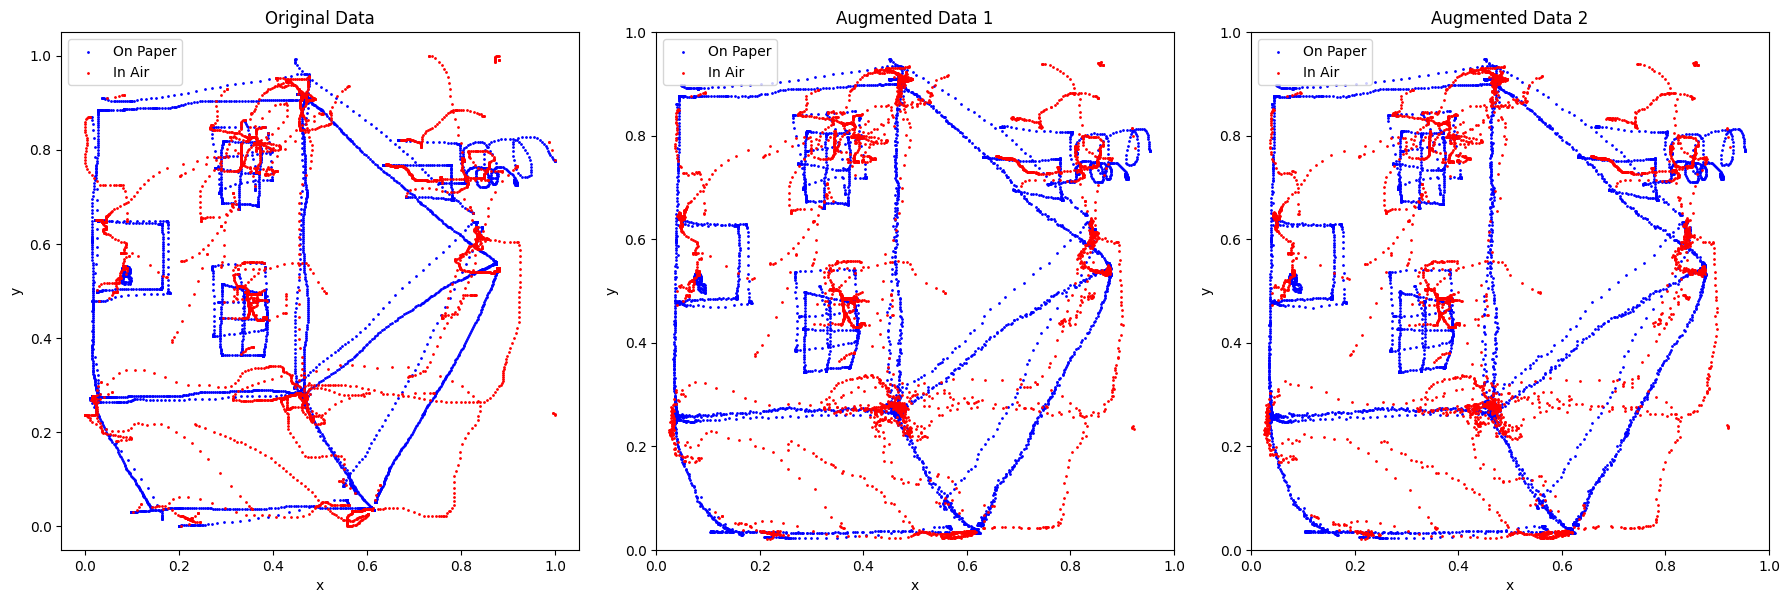

Epoch 181/300: 100%|██████████| 18/18 [00:00<00:00, 60.09batch/s, Total Loss=0.000879, Reconstruction Loss=0.000872, KL Loss=6.29]


Epoch 181: Total Loss = 0.000309, Reconstruction Loss = 0.000303, KL Divergence Loss = 6.319631
MAE = 0.248963, MSE = 0.089258, NRMSE = 0.298761


Epoch 182/300: 100%|██████████| 18/18 [00:00<00:00, 63.80batch/s, Total Loss=0.000131, Reconstruction Loss=0.000125, KL Loss=6.11]


Epoch 182: Total Loss = 0.000326, Reconstruction Loss = 0.000320, KL Divergence Loss = 6.248881
MAE = 0.247764, MSE = 0.087813, NRMSE = 0.296333


Epoch 183/300: 100%|██████████| 18/18 [00:00<00:00, 47.93batch/s, Total Loss=0.000105, Reconstruction Loss=9.9e-5, KL Loss=6.25]  


Epoch 183: Total Loss = 0.000126, Reconstruction Loss = 0.000120, KL Divergence Loss = 6.218356
MAE = 0.247759, MSE = 0.088201, NRMSE = 0.296986


Epoch 184/300: 100%|██████████| 18/18 [00:00<00:00, 64.67batch/s, Total Loss=0.000101, Reconstruction Loss=9.5e-5, KL Loss=6.2]   


Epoch 184: Total Loss = 0.000101, Reconstruction Loss = 0.000095, KL Divergence Loss = 6.235632
MAE = 0.249135, MSE = 0.089019, NRMSE = 0.298360


Epoch 185/300: 100%|██████████| 18/18 [00:00<00:00, 47.03batch/s, Total Loss=0.00011, Reconstruction Loss=0.000103, KL Loss=6.24] 


Epoch 185: Total Loss = 0.000092, Reconstruction Loss = 0.000086, KL Divergence Loss = 6.259797
MAE = 0.248471, MSE = 0.088840, NRMSE = 0.298061


Epoch 186/300: 100%|██████████| 18/18 [00:00<00:00, 62.32batch/s, Total Loss=0.000157, Reconstruction Loss=0.00015, KL Loss=6.28] 


Epoch 186: Total Loss = 0.000115, Reconstruction Loss = 0.000109, KL Divergence Loss = 6.280162
MAE = 0.248629, MSE = 0.089048, NRMSE = 0.298409


Epoch 187/300: 100%|██████████| 18/18 [00:00<00:00, 43.21batch/s, Total Loss=0.000121, Reconstruction Loss=0.000115, KL Loss=6.26]


Epoch 187: Total Loss = 0.000111, Reconstruction Loss = 0.000104, KL Divergence Loss = 6.289285
MAE = 0.248700, MSE = 0.088767, NRMSE = 0.297938


Epoch 188/300: 100%|██████████| 18/18 [00:00<00:00, 65.35batch/s, Total Loss=0.000207, Reconstruction Loss=0.000201, KL Loss=6.38]


Epoch 188: Total Loss = 0.000118, Reconstruction Loss = 0.000111, KL Divergence Loss = 6.301216
MAE = 0.249982, MSE = 0.089596, NRMSE = 0.299327


Epoch 189/300: 100%|██████████| 18/18 [00:00<00:00, 50.98batch/s, Total Loss=0.00015, Reconstruction Loss=0.000144, KL Loss=6.28] 


Epoch 189: Total Loss = 0.000206, Reconstruction Loss = 0.000200, KL Divergence Loss = 6.290379
MAE = 0.249650, MSE = 0.089536, NRMSE = 0.299226


Epoch 190/300: 100%|██████████| 18/18 [00:00<00:00, 56.88batch/s, Total Loss=0.00014, Reconstruction Loss=0.000134, KL Loss=6.22] 


Epoch 190: Total Loss = 0.000149, Reconstruction Loss = 0.000143, KL Divergence Loss = 6.276968
MAE = 0.249519, MSE = 0.089268, NRMSE = 0.298777


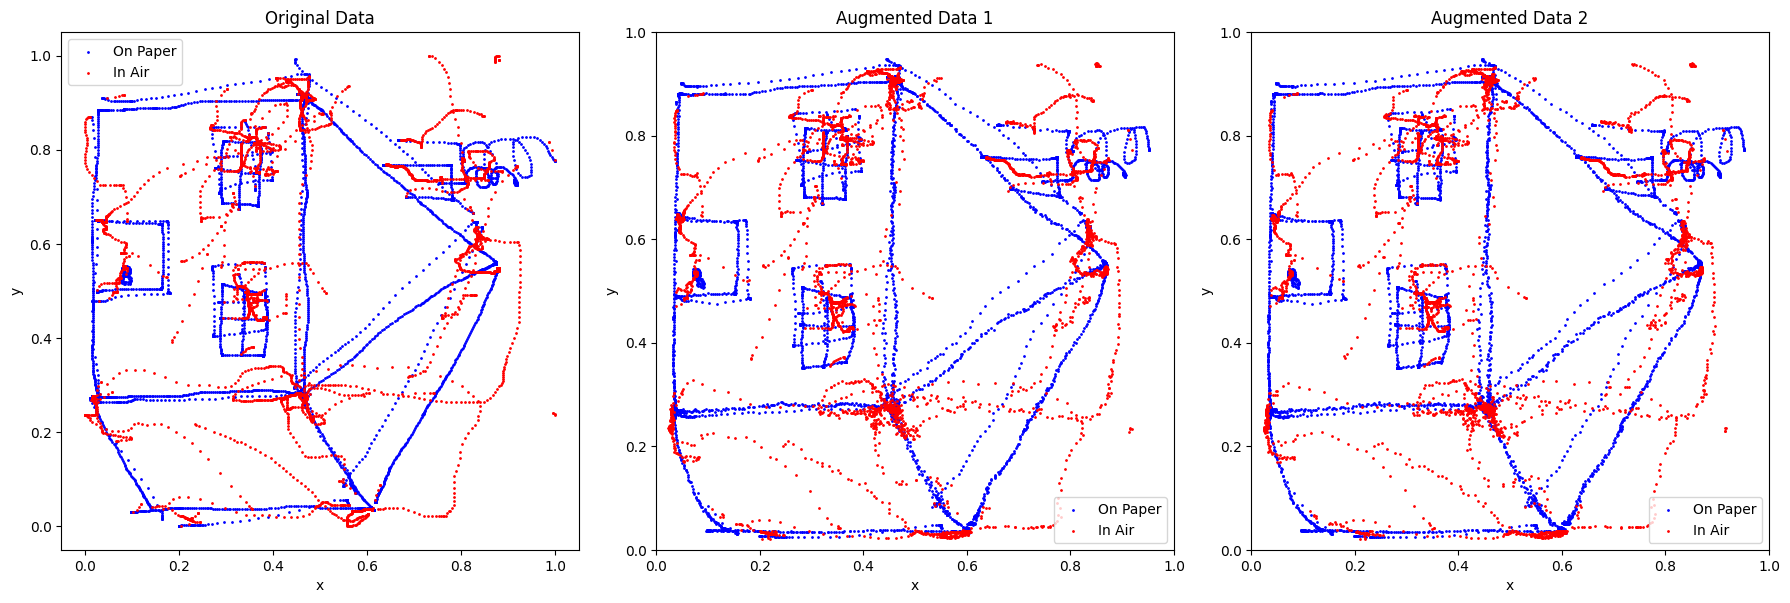

Epoch 191/300: 100%|██████████| 18/18 [00:00<00:00, 62.24batch/s, Total Loss=0.00012, Reconstruction Loss=0.000114, KL Loss=6.19] 


Epoch 191: Total Loss = 0.000122, Reconstruction Loss = 0.000116, KL Divergence Loss = 6.275026
MAE = 0.249169, MSE = 0.089205, NRMSE = 0.298672


Epoch 192/300: 100%|██████████| 18/18 [00:00<00:00, 50.60batch/s, Total Loss=0.000166, Reconstruction Loss=0.00016, KL Loss=6.29] 


Epoch 192: Total Loss = 0.000154, Reconstruction Loss = 0.000148, KL Divergence Loss = 6.280318
MAE = 0.249626, MSE = 0.089391, NRMSE = 0.298984


Epoch 193/300: 100%|██████████| 18/18 [00:00<00:00, 63.63batch/s, Total Loss=0.000228, Reconstruction Loss=0.000222, KL Loss=6.25]


Epoch 193: Total Loss = 0.000160, Reconstruction Loss = 0.000153, KL Divergence Loss = 6.279667
MAE = 0.248644, MSE = 0.088559, NRMSE = 0.297588


Epoch 194/300: 100%|██████████| 18/18 [00:00<00:00, 51.76batch/s, Total Loss=0.000238, Reconstruction Loss=0.000231, KL Loss=6.38]


Epoch 194: Total Loss = 0.000206, Reconstruction Loss = 0.000200, KL Divergence Loss = 6.268524
MAE = 0.249138, MSE = 0.089165, NRMSE = 0.298605


Epoch 195/300: 100%|██████████| 18/18 [00:00<00:00, 65.11batch/s, Total Loss=8.82e-5, Reconstruction Loss=8.21e-5, KL Loss=6.16]  


Epoch 195: Total Loss = 0.000130, Reconstruction Loss = 0.000124, KL Divergence Loss = 6.247146
MAE = 0.248939, MSE = 0.089031, NRMSE = 0.298380


Epoch 196/300: 100%|██████████| 18/18 [00:00<00:00, 49.56batch/s, Total Loss=0.000104, Reconstruction Loss=9.72e-5, KL Loss=6.29] 


Epoch 196: Total Loss = 0.000096, Reconstruction Loss = 0.000090, KL Divergence Loss = 6.253145
MAE = 0.247940, MSE = 0.088513, NRMSE = 0.297511


Epoch 197/300: 100%|██████████| 18/18 [00:00<00:00, 61.92batch/s, Total Loss=0.000122, Reconstruction Loss=0.000115, KL Loss=6.28]


Epoch 197: Total Loss = 0.000098, Reconstruction Loss = 0.000092, KL Divergence Loss = 6.268599
MAE = 0.249587, MSE = 0.089588, NRMSE = 0.299313


Epoch 198/300: 100%|██████████| 18/18 [00:00<00:00, 50.03batch/s, Total Loss=0.000115, Reconstruction Loss=0.000109, KL Loss=6.23]


Epoch 198: Total Loss = 0.000094, Reconstruction Loss = 0.000088, KL Divergence Loss = 6.284398
MAE = 0.248841, MSE = 0.088985, NRMSE = 0.298303


Epoch 199/300: 100%|██████████| 18/18 [00:00<00:00, 61.59batch/s, Total Loss=0.000135, Reconstruction Loss=0.000129, KL Loss=6.27]


Epoch 199: Total Loss = 0.000094, Reconstruction Loss = 0.000088, KL Divergence Loss = 6.297636
MAE = 0.249706, MSE = 0.089709, NRMSE = 0.299514


Epoch 200/300: 100%|██████████| 18/18 [00:00<00:00, 55.99batch/s, Total Loss=0.000126, Reconstruction Loss=0.00012, KL Loss=6.21] 


Epoch 200: Total Loss = 0.000201, Reconstruction Loss = 0.000195, KL Divergence Loss = 6.296469
MAE = 0.249377, MSE = 0.089220, NRMSE = 0.298698


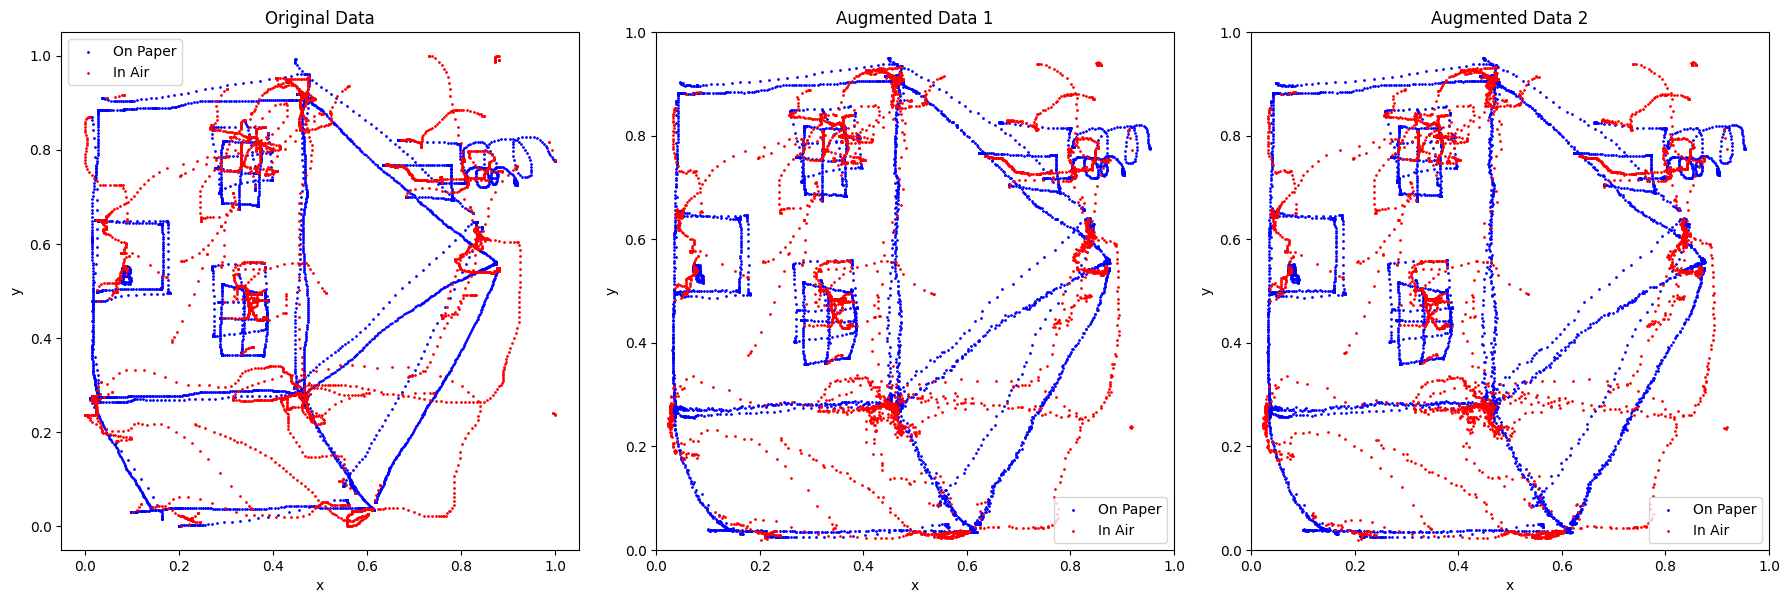

Epoch 201/300: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batch, Total Loss=-0.139, Reconstruction Loss=0.000324, KL Loss=6.3] 


LSTM training at epoch 201: Discriminator Loss = [1.4239471]
Epoch 201: Total Loss = -0.139328, Reconstruction Loss = 0.000320, KL Divergence Loss = 6.260942
MAE = 0.249727, MSE = 0.089640, NRMSE = 0.299399


Epoch 202/300: 100%|██████████| 18/18 [00:00<00:00, 49.73batch/s, Total Loss=0.000187, Reconstruction Loss=0.000181, KL Loss=6.08]


Epoch 202: Total Loss = 0.000274, Reconstruction Loss = 0.000267, KL Divergence Loss = 6.195256
MAE = 0.248962, MSE = 0.089158, NRMSE = 0.298593


Epoch 203/300: 100%|██████████| 18/18 [00:00<00:00, 50.28batch/s, Total Loss=0.000161, Reconstruction Loss=0.000155, KL Loss=6.08]


Epoch 203: Total Loss = 0.000165, Reconstruction Loss = 0.000159, KL Divergence Loss = 6.158360
MAE = 0.248776, MSE = 0.088797, NRMSE = 0.297989


Epoch 204/300: 100%|██████████| 18/18 [00:00<00:00, 43.27batch/s, Total Loss=0.000119, Reconstruction Loss=0.000113, KL Loss=6.16]


Epoch 204: Total Loss = 0.000148, Reconstruction Loss = 0.000142, KL Divergence Loss = 6.160735
MAE = 0.249689, MSE = 0.089665, NRMSE = 0.299442


Epoch 205/300: 100%|██████████| 18/18 [00:00<00:00, 51.34batch/s, Total Loss=7.64e-5, Reconstruction Loss=7.02e-5, KL Loss=6.27] 


Epoch 205: Total Loss = 0.000090, Reconstruction Loss = 0.000084, KL Divergence Loss = 6.170537
MAE = 0.248886, MSE = 0.088943, NRMSE = 0.298233


Epoch 206/300: 100%|██████████| 18/18 [00:00<00:00, 43.93batch/s, Total Loss=7.68e-5, Reconstruction Loss=7.06e-5, KL Loss=6.18]


Epoch 206: Total Loss = 0.000081, Reconstruction Loss = 0.000074, KL Divergence Loss = 6.194372
MAE = 0.249186, MSE = 0.088949, NRMSE = 0.298243


Epoch 207/300: 100%|██████████| 18/18 [00:00<00:00, 56.41batch/s, Total Loss=0.000146, Reconstruction Loss=0.00014, KL Loss=6.31] 


Epoch 207: Total Loss = 0.000112, Reconstruction Loss = 0.000106, KL Divergence Loss = 6.218648
MAE = 0.249122, MSE = 0.089148, NRMSE = 0.298577


Epoch 208/300: 100%|██████████| 18/18 [00:00<00:00, 44.65batch/s, Total Loss=8.72e-5, Reconstruction Loss=8.1e-5, KL Loss=6.22]   


Epoch 208: Total Loss = 0.000118, Reconstruction Loss = 0.000111, KL Divergence Loss = 6.222370
MAE = 0.249314, MSE = 0.089010, NRMSE = 0.298346


Epoch 209/300: 100%|██████████| 18/18 [00:00<00:00, 47.30batch/s, Total Loss=7.71e-5, Reconstruction Loss=7.09e-5, KL Loss=6.25]  


Epoch 209: Total Loss = 0.000090, Reconstruction Loss = 0.000083, KL Divergence Loss = 6.231072
MAE = 0.249131, MSE = 0.089124, NRMSE = 0.298537


Epoch 210/300: 100%|██████████| 18/18 [00:00<00:00, 60.14batch/s, Total Loss=6.85e-5, Reconstruction Loss=6.23e-5, KL Loss=6.24]  


Epoch 210: Total Loss = 0.000115, Reconstruction Loss = 0.000109, KL Divergence Loss = 6.244963
MAE = 0.249305, MSE = 0.089433, NRMSE = 0.299053


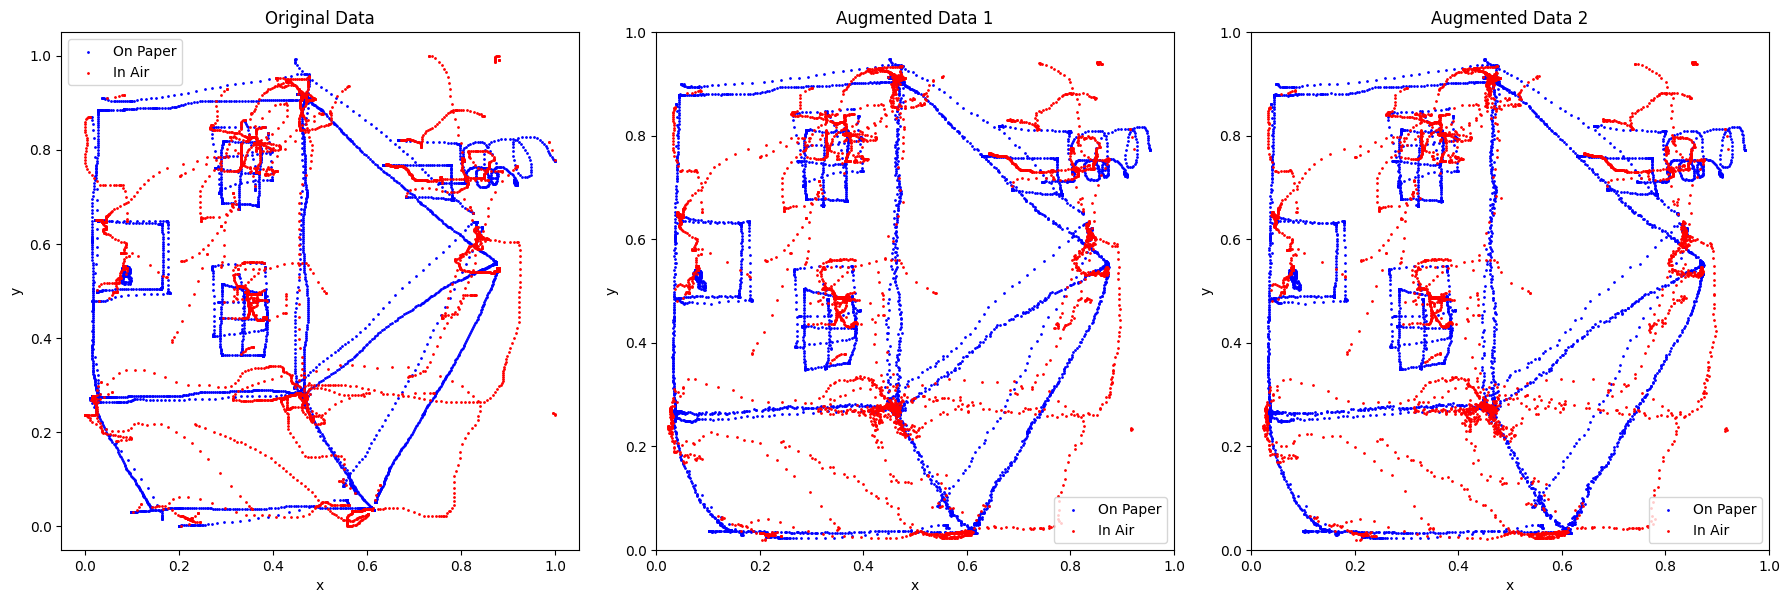

Epoch 211/300: 100%|██████████| 18/18 [00:00<00:00, 59.96batch/s, Total Loss=9.17e-5, Reconstruction Loss=8.55e-5, KL Loss=6.27]


Epoch 211: Total Loss = 0.000093, Reconstruction Loss = 0.000086, KL Divergence Loss = 6.250500
MAE = 0.248330, MSE = 0.089005, NRMSE = 0.298337


Epoch 212/300: 100%|██████████| 18/18 [00:00<00:00, 45.07batch/s, Total Loss=8.26e-5, Reconstruction Loss=7.63e-5, KL Loss=6.27]  


Epoch 212: Total Loss = 0.000105, Reconstruction Loss = 0.000099, KL Divergence Loss = 6.260036
MAE = 0.247867, MSE = 0.088357, NRMSE = 0.297249


Epoch 213/300: 100%|██████████| 18/18 [00:00<00:00, 58.17batch/s, Total Loss=8.07e-5, Reconstruction Loss=7.44e-5, KL Loss=6.31]  


Epoch 213: Total Loss = 0.000099, Reconstruction Loss = 0.000093, KL Divergence Loss = 6.271097
MAE = 0.249757, MSE = 0.089521, NRMSE = 0.299201


Epoch 214/300: 100%|██████████| 18/18 [00:00<00:00, 47.10batch/s, Total Loss=0.000245, Reconstruction Loss=0.000239, KL Loss=6.34]


Epoch 214: Total Loss = 0.000108, Reconstruction Loss = 0.000102, KL Divergence Loss = 6.277437
MAE = 0.249007, MSE = 0.088822, NRMSE = 0.298031


Epoch 215/300: 100%|██████████| 18/18 [00:00<00:00, 60.20batch/s, Total Loss=0.000266, Reconstruction Loss=0.00026, KL Loss=6.23] 


Epoch 215: Total Loss = 0.000492, Reconstruction Loss = 0.000486, KL Divergence Loss = 6.225082
MAE = 0.249254, MSE = 0.089158, NRMSE = 0.298594


Epoch 216/300: 100%|██████████| 18/18 [00:00<00:00, 41.84batch/s, Total Loss=0.000219, Reconstruction Loss=0.000213, KL Loss=6.19]


Epoch 216: Total Loss = 0.000210, Reconstruction Loss = 0.000204, KL Divergence Loss = 6.140590
MAE = 0.248606, MSE = 0.089156, NRMSE = 0.298590


Epoch 217/300: 100%|██████████| 18/18 [00:00<00:00, 58.70batch/s, Total Loss=9.21e-5, Reconstruction Loss=8.59e-5, KL Loss=6.11]  


Epoch 217: Total Loss = 0.000117, Reconstruction Loss = 0.000111, KL Divergence Loss = 6.125337
MAE = 0.249374, MSE = 0.089336, NRMSE = 0.298891


Epoch 218/300: 100%|██████████| 18/18 [00:00<00:00, 47.98batch/s, Total Loss=8.39e-5, Reconstruction Loss=7.77e-5, KL Loss=6.2] 


Epoch 218: Total Loss = 0.000091, Reconstruction Loss = 0.000084, KL Divergence Loss = 6.144777
MAE = 0.249925, MSE = 0.089960, NRMSE = 0.299934


Epoch 219/300: 100%|██████████| 18/18 [00:00<00:00, 61.70batch/s, Total Loss=7.29e-5, Reconstruction Loss=6.66e-5, KL Loss=6.25]


Epoch 219: Total Loss = 0.000079, Reconstruction Loss = 0.000072, KL Divergence Loss = 6.168694
MAE = 0.249339, MSE = 0.089590, NRMSE = 0.299316


Epoch 220/300: 100%|██████████| 18/18 [00:00<00:00, 56.86batch/s, Total Loss=7.74e-5, Reconstruction Loss=7.12e-5, KL Loss=6.25]


Epoch 220: Total Loss = 0.000075, Reconstruction Loss = 0.000069, KL Divergence Loss = 6.189956
MAE = 0.249941, MSE = 0.089722, NRMSE = 0.299536


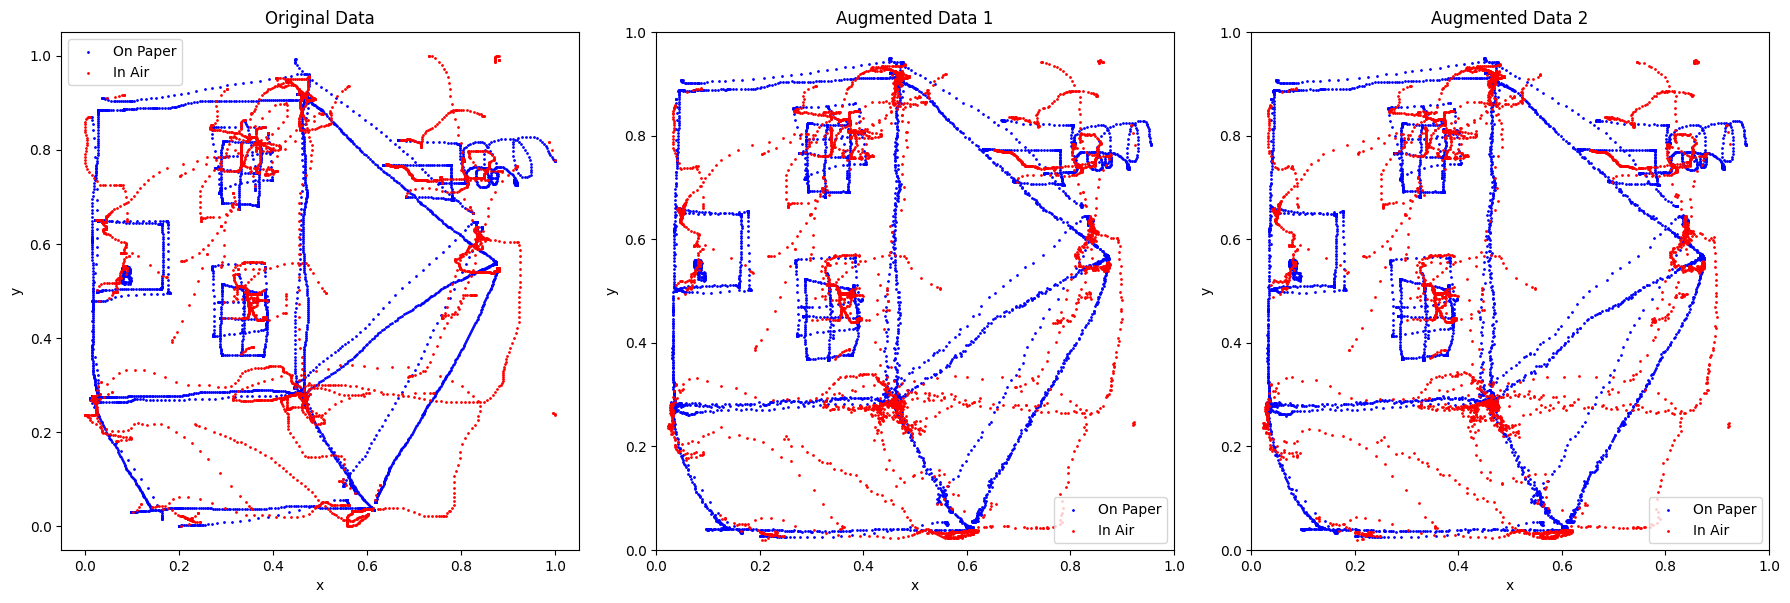

Epoch 221/300: 100%|██████████| 18/18 [00:05<00:00,  3.21batch/s, Total Loss=-0.139, Reconstruction Loss=0.000402, KL Loss=6.24]


LSTM training at epoch 221: Discriminator Loss = [1.3738503]
Epoch 221: Total Loss = -0.138555, Reconstruction Loss = 0.000285, KL Divergence Loss = 6.197892
MAE = 0.249398, MSE = 0.089292, NRMSE = 0.298818


Epoch 222/300: 100%|██████████| 18/18 [00:00<00:00, 58.56batch/s, Total Loss=0.000107, Reconstruction Loss=0.000101, KL Loss=6.09]


Epoch 222: Total Loss = 0.000201, Reconstruction Loss = 0.000195, KL Divergence Loss = 6.156461
MAE = 0.249825, MSE = 0.089576, NRMSE = 0.299292


Epoch 223/300: 100%|██████████| 18/18 [00:00<00:00, 45.94batch/s, Total Loss=0.000113, Reconstruction Loss=0.000107, KL Loss=6.19]


Epoch 223: Total Loss = 0.000104, Reconstruction Loss = 0.000098, KL Divergence Loss = 6.139409
MAE = 0.250264, MSE = 0.090119, NRMSE = 0.300198


Epoch 224/300: 100%|██████████| 18/18 [00:00<00:00, 52.45batch/s, Total Loss=6.78e-5, Reconstruction Loss=6.16e-5, KL Loss=6.22]  


Epoch 224: Total Loss = 0.000084, Reconstruction Loss = 0.000078, KL Divergence Loss = 6.150894
MAE = 0.250063, MSE = 0.089600, NRMSE = 0.299332


Epoch 225/300: 100%|██████████| 18/18 [00:00<00:00, 44.90batch/s, Total Loss=9.16e-5, Reconstruction Loss=8.54e-5, KL Loss=6.22]


Epoch 225: Total Loss = 0.000076, Reconstruction Loss = 0.000070, KL Divergence Loss = 6.170814
MAE = 0.249729, MSE = 0.089658, NRMSE = 0.299429


Epoch 226/300: 100%|██████████| 18/18 [00:00<00:00, 55.57batch/s, Total Loss=7.29e-5, Reconstruction Loss=6.67e-5, KL Loss=6.15] 


Epoch 226: Total Loss = 0.000083, Reconstruction Loss = 0.000077, KL Divergence Loss = 6.190783
MAE = 0.250164, MSE = 0.089876, NRMSE = 0.299793


Epoch 227/300: 100%|██████████| 18/18 [00:00<00:00, 58.66batch/s, Total Loss=0.000109, Reconstruction Loss=0.000103, KL Loss=6.23]


Epoch 227: Total Loss = 0.000101, Reconstruction Loss = 0.000095, KL Divergence Loss = 6.204773
MAE = 0.250262, MSE = 0.090162, NRMSE = 0.300270


Epoch 228/300: 100%|██████████| 18/18 [00:00<00:00, 57.00batch/s, Total Loss=8.13e-5, Reconstruction Loss=7.51e-5, KL Loss=6.14]  


Epoch 228: Total Loss = 0.000096, Reconstruction Loss = 0.000089, KL Divergence Loss = 6.209181
MAE = 0.249121, MSE = 0.089291, NRMSE = 0.298816


Epoch 229/300: 100%|██████████| 18/18 [00:00<00:00, 41.77batch/s, Total Loss=8.27e-5, Reconstruction Loss=7.64e-5, KL Loss=6.28]  


Epoch 229: Total Loss = 0.000095, Reconstruction Loss = 0.000088, KL Divergence Loss = 6.216583
MAE = 0.250416, MSE = 0.090232, NRMSE = 0.300387


Epoch 230/300: 100%|██████████| 18/18 [00:00<00:00, 55.44batch/s, Total Loss=0.000129, Reconstruction Loss=0.000122, KL Loss=6.33]


Epoch 230: Total Loss = 0.000126, Reconstruction Loss = 0.000120, KL Divergence Loss = 6.220696
MAE = 0.250420, MSE = 0.090241, NRMSE = 0.300402


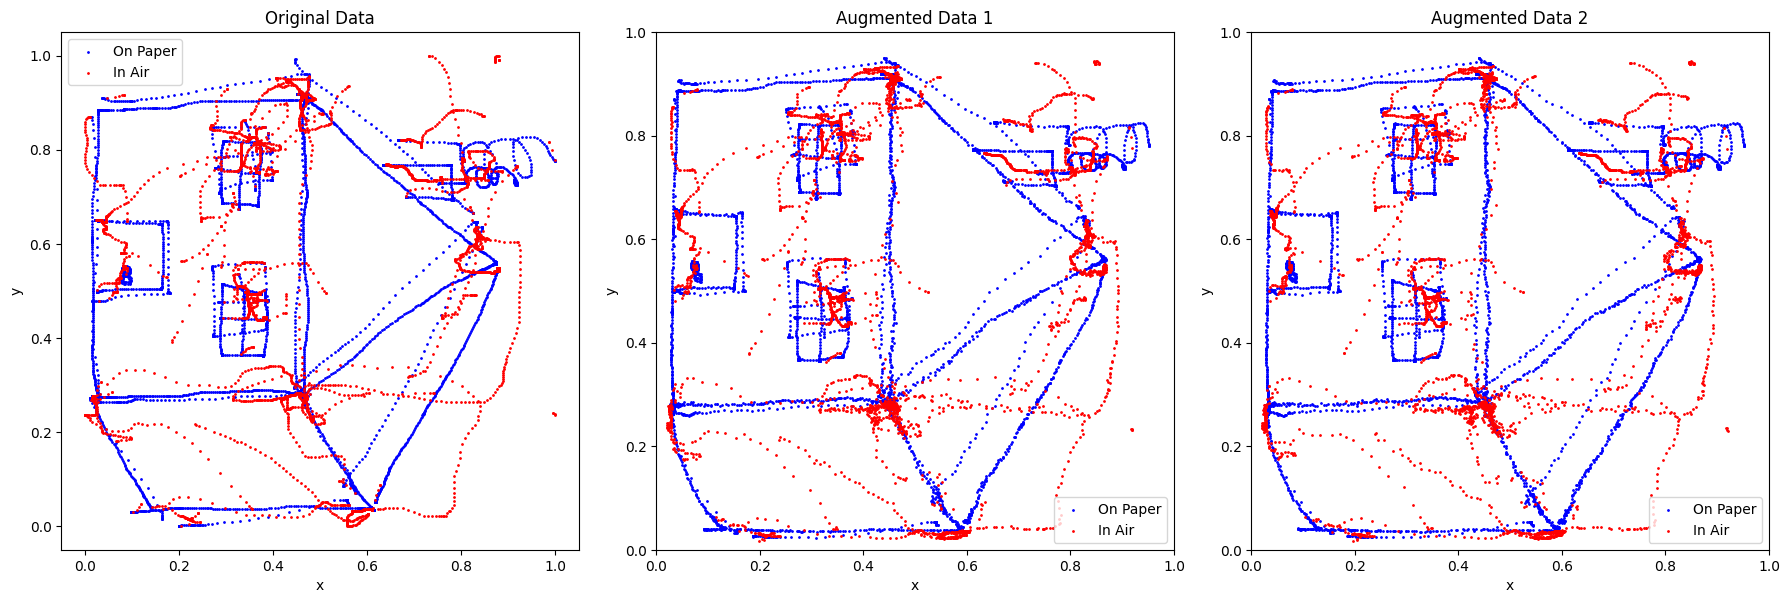

Epoch 231/300: 100%|██████████| 18/18 [00:00<00:00, 57.06batch/s, Total Loss=7.54e-5, Reconstruction Loss=6.91e-5, KL Loss=6.24] 


Epoch 231: Total Loss = 0.000091, Reconstruction Loss = 0.000084, KL Divergence Loss = 6.218956
MAE = 0.251010, MSE = 0.090766, NRMSE = 0.301274


Epoch 232/300: 100%|██████████| 18/18 [00:00<00:00, 46.96batch/s, Total Loss=0.000112, Reconstruction Loss=0.000106, KL Loss=6.3] 


Epoch 232: Total Loss = 0.000085, Reconstruction Loss = 0.000079, KL Divergence Loss = 6.231373
MAE = 0.249170, MSE = 0.089436, NRMSE = 0.299059


Epoch 233/300: 100%|██████████| 18/18 [00:00<00:00, 48.20batch/s, Total Loss=7.81e-5, Reconstruction Loss=7.17e-5, KL Loss=6.4]   


Epoch 233: Total Loss = 0.000102, Reconstruction Loss = 0.000095, KL Divergence Loss = 6.238821
MAE = 0.251237, MSE = 0.090717, NRMSE = 0.301192


Epoch 234/300: 100%|██████████| 18/18 [00:00<00:00, 47.20batch/s, Total Loss=0.000279, Reconstruction Loss=0.000272, KL Loss=6.21]


Epoch 234: Total Loss = 0.000132, Reconstruction Loss = 0.000126, KL Divergence Loss = 6.243692
MAE = 0.250053, MSE = 0.089636, NRMSE = 0.299393


Epoch 235/300: 100%|██████████| 18/18 [00:00<00:00, 58.20batch/s, Total Loss=0.000106, Reconstruction Loss=9.94e-5, KL Loss=6.16] 


Epoch 235: Total Loss = 0.000138, Reconstruction Loss = 0.000132, KL Divergence Loss = 6.231331
MAE = 0.249451, MSE = 0.089631, NRMSE = 0.299385


Epoch 236/300: 100%|██████████| 18/18 [00:00<00:00, 56.69batch/s, Total Loss=8.9e-5, Reconstruction Loss=8.28e-5, KL Loss=6.18]  


Epoch 236: Total Loss = 0.000094, Reconstruction Loss = 0.000088, KL Divergence Loss = 6.223907
MAE = 0.250369, MSE = 0.090063, NRMSE = 0.300104


Epoch 237/300: 100%|██████████| 18/18 [00:00<00:00, 42.56batch/s, Total Loss=0.000156, Reconstruction Loss=0.00015, KL Loss=6.34] 


Epoch 237: Total Loss = 0.000116, Reconstruction Loss = 0.000110, KL Divergence Loss = 6.230808
MAE = 0.249400, MSE = 0.089605, NRMSE = 0.299342


Epoch 238/300: 100%|██████████| 18/18 [00:00<00:00, 61.71batch/s, Total Loss=0.000121, Reconstruction Loss=0.000115, KL Loss=6.22]


Epoch 238: Total Loss = 0.000142, Reconstruction Loss = 0.000136, KL Divergence Loss = 6.226742
MAE = 0.249699, MSE = 0.089635, NRMSE = 0.299392


Epoch 239/300: 100%|██████████| 18/18 [00:00<00:00, 61.77batch/s, Total Loss=0.000128, Reconstruction Loss=0.000122, KL Loss=6.2] 


Epoch 239: Total Loss = 0.000116, Reconstruction Loss = 0.000109, KL Divergence Loss = 6.220223
MAE = 0.250926, MSE = 0.090433, NRMSE = 0.300721


Epoch 240/300: 100%|██████████| 18/18 [00:00<00:00, 68.85batch/s, Total Loss=0.000115, Reconstruction Loss=0.000109, KL Loss=6.17]


Epoch 240: Total Loss = 0.000110, Reconstruction Loss = 0.000104, KL Divergence Loss = 6.216897
MAE = 0.250564, MSE = 0.089997, NRMSE = 0.299994


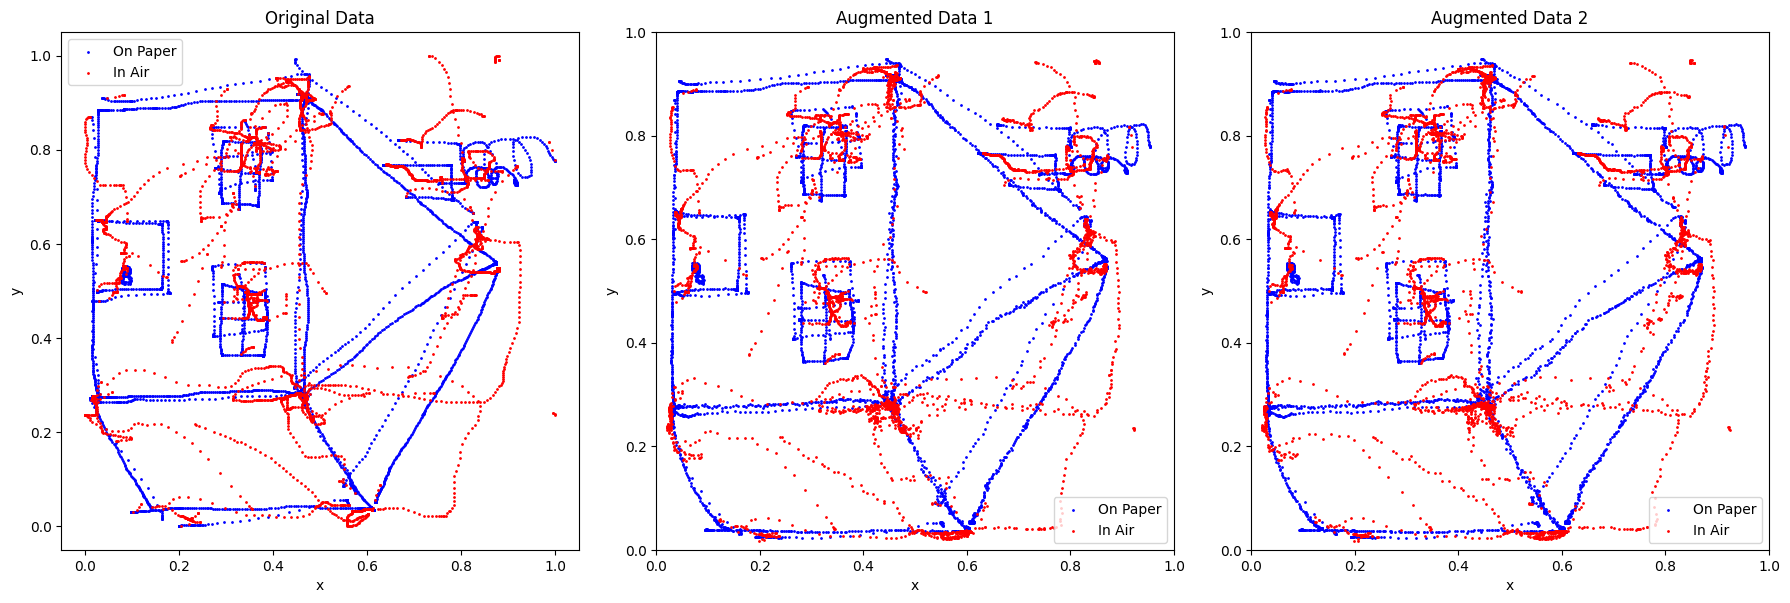

Epoch 241/300: 100%|██████████| 18/18 [00:05<00:00,  3.56batch/s, Total Loss=-0.138, Reconstruction Loss=0.000959, KL Loss=6.08]


LSTM training at epoch 241: Discriminator Loss = [1.3216987]
Epoch 241: Total Loss = -0.137978, Reconstruction Loss = 0.000821, KL Divergence Loss = 6.155777
MAE = 0.249057, MSE = 0.089029, NRMSE = 0.298378


Epoch 242/300: 100%|██████████| 18/18 [00:00<00:00, 63.72batch/s, Total Loss=0.000284, Reconstruction Loss=0.000278, KL Loss=5.85]


Epoch 242: Total Loss = 0.000588, Reconstruction Loss = 0.000582, KL Divergence Loss = 5.958543
MAE = 0.251320, MSE = 0.090536, NRMSE = 0.300891


Epoch 243/300: 100%|██████████| 18/18 [00:00<00:00, 62.30batch/s, Total Loss=0.000117, Reconstruction Loss=0.000111, KL Loss=5.92]


Epoch 243: Total Loss = 0.000162, Reconstruction Loss = 0.000156, KL Divergence Loss = 5.862885
MAE = 0.249197, MSE = 0.089305, NRMSE = 0.298839


Epoch 244/300: 100%|██████████| 18/18 [00:00<00:00, 51.53batch/s, Total Loss=8.92e-5, Reconstruction Loss=8.34e-5, KL Loss=5.89] 


Epoch 244: Total Loss = 0.000093, Reconstruction Loss = 0.000087, KL Divergence Loss = 5.882163
MAE = 0.250143, MSE = 0.090240, NRMSE = 0.300400


Epoch 245/300: 100%|██████████| 18/18 [00:00<00:00, 66.16batch/s, Total Loss=7.72e-5, Reconstruction Loss=7.13e-5, KL Loss=5.96]


Epoch 245: Total Loss = 0.000081, Reconstruction Loss = 0.000075, KL Divergence Loss = 5.926528
MAE = 0.250559, MSE = 0.090095, NRMSE = 0.300159


Epoch 246/300: 100%|██████████| 18/18 [00:00<00:00, 55.67batch/s, Total Loss=8.89e-5, Reconstruction Loss=8.29e-5, KL Loss=6]   


Epoch 246: Total Loss = 0.000072, Reconstruction Loss = 0.000066, KL Divergence Loss = 5.962156
MAE = 0.248503, MSE = 0.088758, NRMSE = 0.297922


Epoch 247/300: 100%|██████████| 18/18 [00:00<00:00, 61.99batch/s, Total Loss=5.86e-5, Reconstruction Loss=5.27e-5, KL Loss=5.89]


Epoch 247: Total Loss = 0.000072, Reconstruction Loss = 0.000066, KL Divergence Loss = 5.993559
MAE = 0.250223, MSE = 0.090213, NRMSE = 0.300354


Epoch 248/300: 100%|██████████| 18/18 [00:00<00:00, 52.03batch/s, Total Loss=7.38e-5, Reconstruction Loss=6.78e-5, KL Loss=6]   


Epoch 248: Total Loss = 0.000069, Reconstruction Loss = 0.000063, KL Divergence Loss = 6.025732
MAE = 0.250569, MSE = 0.090219, NRMSE = 0.300365


Epoch 249/300: 100%|██████████| 18/18 [00:00<00:00, 67.49batch/s, Total Loss=6.73e-5, Reconstruction Loss=6.11e-5, KL Loss=6.23]


Epoch 249: Total Loss = 0.000070, Reconstruction Loss = 0.000064, KL Divergence Loss = 6.054636
MAE = 0.251705, MSE = 0.091129, NRMSE = 0.301876


Epoch 250/300: 100%|██████████| 18/18 [00:00<00:00, 64.62batch/s, Total Loss=7.59e-5, Reconstruction Loss=6.98e-5, KL Loss=6.09]


Epoch 250: Total Loss = 0.000066, Reconstruction Loss = 0.000060, KL Divergence Loss = 6.076257
MAE = 0.251223, MSE = 0.090295, NRMSE = 0.300492


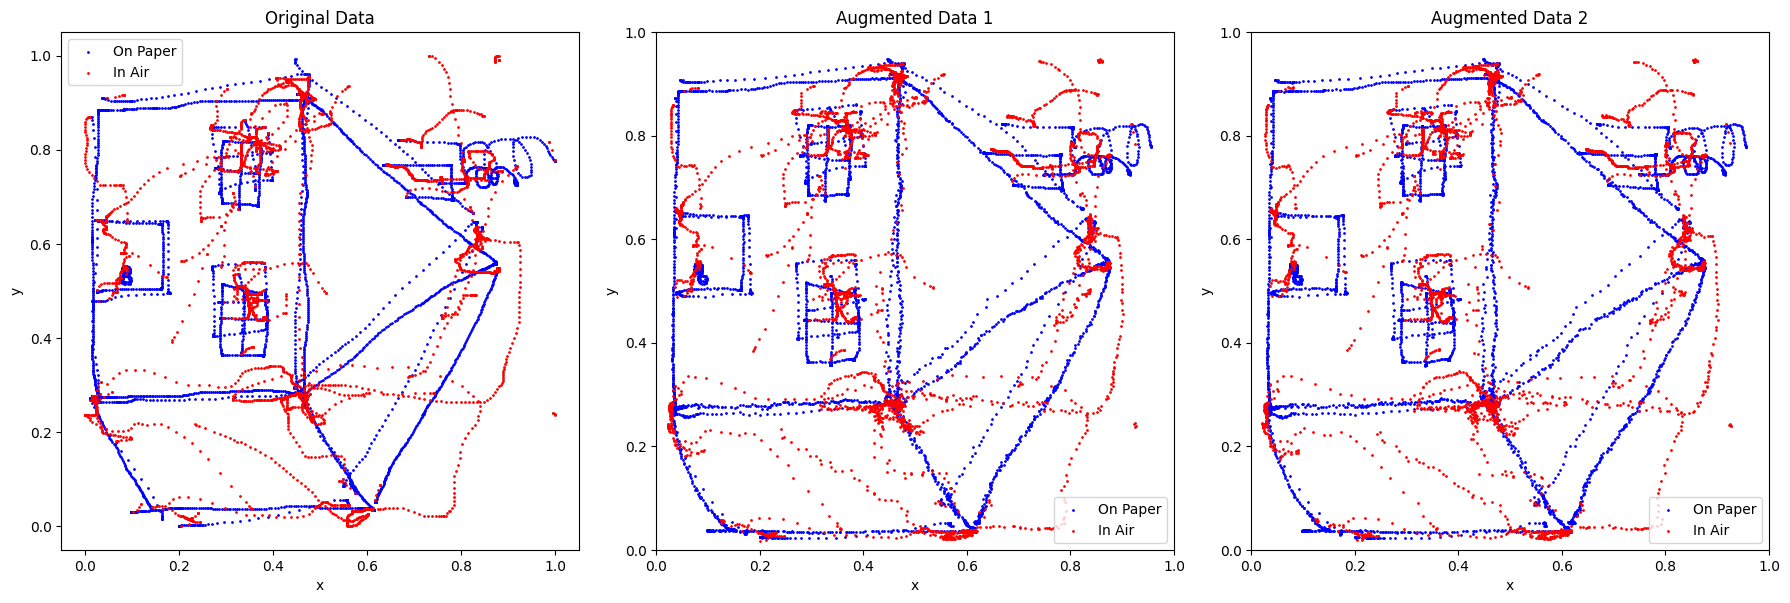

Epoch 251/300: 100%|██████████| 18/18 [00:00<00:00, 63.62batch/s, Total Loss=6.74e-5, Reconstruction Loss=6.11e-5, KL Loss=6.3] 


Epoch 251: Total Loss = 0.000066, Reconstruction Loss = 0.000060, KL Divergence Loss = 6.099582
MAE = 0.249732, MSE = 0.090062, NRMSE = 0.300103


Epoch 252/300: 100%|██████████| 18/18 [00:00<00:00, 51.91batch/s, Total Loss=9.77e-5, Reconstruction Loss=9.16e-5, KL Loss=6.06]


Epoch 252: Total Loss = 0.000069, Reconstruction Loss = 0.000063, KL Divergence Loss = 6.115241
MAE = 0.251622, MSE = 0.091077, NRMSE = 0.301789


Epoch 253/300: 100%|██████████| 18/18 [00:00<00:00, 53.21batch/s, Total Loss=0.00012, Reconstruction Loss=0.000114, KL Loss=6.19] 


Epoch 253: Total Loss = 0.000086, Reconstruction Loss = 0.000080, KL Divergence Loss = 6.132053
MAE = 0.250072, MSE = 0.090139, NRMSE = 0.300232


Epoch 254/300: 100%|██████████| 18/18 [00:00<00:00, 68.82batch/s, Total Loss=8.68e-5, Reconstruction Loss=8.05e-5, KL Loss=6.23]  


Epoch 254: Total Loss = 0.000113, Reconstruction Loss = 0.000107, KL Divergence Loss = 6.135070
MAE = 0.250310, MSE = 0.090453, NRMSE = 0.300754


Epoch 255/300: 100%|██████████| 18/18 [00:00<00:00, 54.04batch/s, Total Loss=8.28e-5, Reconstruction Loss=7.66e-5, KL Loss=6.18]  


Epoch 255: Total Loss = 0.000080, Reconstruction Loss = 0.000074, KL Divergence Loss = 6.137578
MAE = 0.251290, MSE = 0.090847, NRMSE = 0.301408


Epoch 256/300: 100%|██████████| 18/18 [00:00<00:00, 59.17batch/s, Total Loss=0.000115, Reconstruction Loss=0.000109, KL Loss=6.23]


Epoch 256: Total Loss = 0.000083, Reconstruction Loss = 0.000077, KL Divergence Loss = 6.146526
MAE = 0.250635, MSE = 0.090449, NRMSE = 0.300747


Epoch 257/300: 100%|██████████| 18/18 [00:00<00:00, 48.38batch/s, Total Loss=7.84e-5, Reconstruction Loss=7.22e-5, KL Loss=6.16]


Epoch 257: Total Loss = 0.000078, Reconstruction Loss = 0.000072, KL Divergence Loss = 6.155485
MAE = 0.251909, MSE = 0.091374, NRMSE = 0.302282


Epoch 258/300: 100%|██████████| 18/18 [00:00<00:00, 57.01batch/s, Total Loss=8.04e-5, Reconstruction Loss=7.41e-5, KL Loss=6.26]


Epoch 258: Total Loss = 0.000066, Reconstruction Loss = 0.000060, KL Divergence Loss = 6.168048
MAE = 0.250211, MSE = 0.090235, NRMSE = 0.300391


Epoch 259/300: 100%|██████████| 18/18 [00:00<00:00, 45.47batch/s, Total Loss=0.000134, Reconstruction Loss=0.000128, KL Loss=6.16]


Epoch 259: Total Loss = 0.000083, Reconstruction Loss = 0.000077, KL Divergence Loss = 6.179951
MAE = 0.251371, MSE = 0.090972, NRMSE = 0.301616


Epoch 260/300: 100%|██████████| 18/18 [00:00<00:00, 52.96batch/s, Total Loss=8.44e-5, Reconstruction Loss=7.83e-5, KL Loss=6.09]  


Epoch 260: Total Loss = 0.000130, Reconstruction Loss = 0.000124, KL Divergence Loss = 6.181175
MAE = 0.249994, MSE = 0.089798, NRMSE = 0.299663


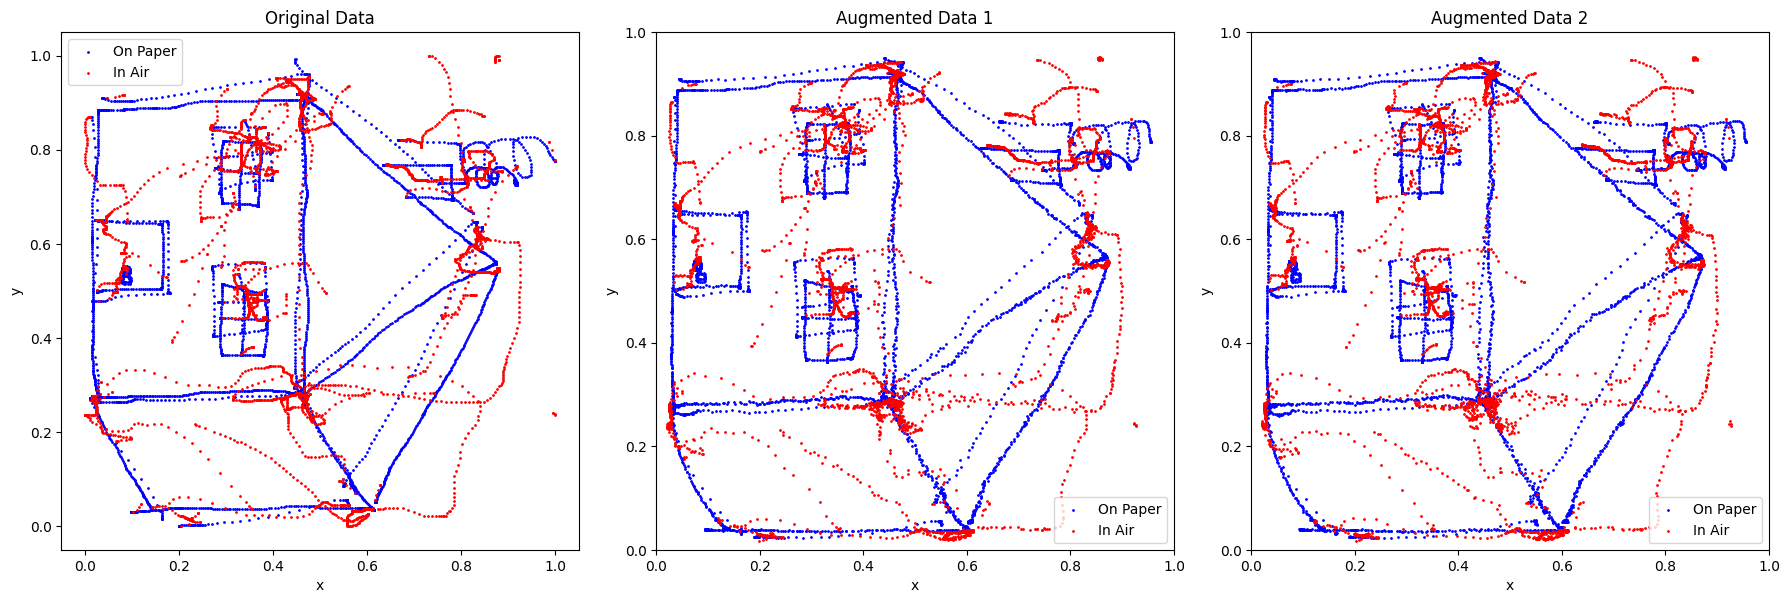

Epoch 261/300: 100%|██████████| 18/18 [00:04<00:00,  3.61batch/s, Total Loss=-0.139, Reconstruction Loss=0.000532, KL Loss=6.08]


LSTM training at epoch 261: Discriminator Loss = [1.2862425]
Epoch 261: Total Loss = -0.138339, Reconstruction Loss = 0.000840, KL Divergence Loss = 6.114160
MAE = 0.250818, MSE = 0.090189, NRMSE = 0.300315


Epoch 262/300: 100%|██████████| 18/18 [00:00<00:00, 63.65batch/s, Total Loss=0.000169, Reconstruction Loss=0.000163, KL Loss=5.88]


Epoch 262: Total Loss = 0.000475, Reconstruction Loss = 0.000469, KL Divergence Loss = 5.933560
MAE = 0.249444, MSE = 0.089758, NRMSE = 0.299597


Epoch 263/300: 100%|██████████| 18/18 [00:00<00:00, 65.38batch/s, Total Loss=0.000131, Reconstruction Loss=0.000125, KL Loss=5.76]


Epoch 263: Total Loss = 0.000167, Reconstruction Loss = 0.000161, KL Divergence Loss = 5.838200
MAE = 0.251129, MSE = 0.090779, NRMSE = 0.301296


Epoch 264/300: 100%|██████████| 18/18 [00:00<00:00, 53.01batch/s, Total Loss=8.22e-5, Reconstruction Loss=7.63e-5, KL Loss=5.82]


Epoch 264: Total Loss = 0.000083, Reconstruction Loss = 0.000077, KL Divergence Loss = 5.860427
MAE = 0.251568, MSE = 0.091119, NRMSE = 0.301859


Epoch 265/300: 100%|██████████| 18/18 [00:00<00:00, 63.69batch/s, Total Loss=6.71e-5, Reconstruction Loss=6.12e-5, KL Loss=5.94]


Epoch 265: Total Loss = 0.000070, Reconstruction Loss = 0.000065, KL Divergence Loss = 5.899065
MAE = 0.250750, MSE = 0.090447, NRMSE = 0.300744


Epoch 266/300: 100%|██████████| 18/18 [00:00<00:00, 54.32batch/s, Total Loss=6.44e-5, Reconstruction Loss=5.85e-5, KL Loss=5.91]


Epoch 266: Total Loss = 0.000067, Reconstruction Loss = 0.000061, KL Divergence Loss = 5.933256
MAE = 0.251819, MSE = 0.090922, NRMSE = 0.301533


Epoch 267/300: 100%|██████████| 18/18 [00:00<00:00, 67.44batch/s, Total Loss=6.28e-5, Reconstruction Loss=5.69e-5, KL Loss=5.88]


Epoch 267: Total Loss = 0.000069, Reconstruction Loss = 0.000063, KL Divergence Loss = 5.963575
MAE = 0.251407, MSE = 0.090742, NRMSE = 0.301234


Epoch 268/300: 100%|██████████| 18/18 [00:00<00:00, 45.39batch/s, Total Loss=6.02e-5, Reconstruction Loss=5.4e-5, KL Loss=6.16] 


Epoch 268: Total Loss = 0.000073, Reconstruction Loss = 0.000067, KL Divergence Loss = 5.989388
MAE = 0.249300, MSE = 0.089705, NRMSE = 0.299508


Epoch 269/300: 100%|██████████| 18/18 [00:00<00:00, 49.45batch/s, Total Loss=7.84e-5, Reconstruction Loss=7.25e-5, KL Loss=5.9] 


Epoch 269: Total Loss = 0.000067, Reconstruction Loss = 0.000061, KL Divergence Loss = 6.008461
MAE = 0.250998, MSE = 0.090617, NRMSE = 0.301027


Epoch 270/300: 100%|██████████| 18/18 [00:00<00:00, 67.48batch/s, Total Loss=6.89e-5, Reconstruction Loss=6.28e-5, KL Loss=6.1] 


Epoch 270: Total Loss = 0.000067, Reconstruction Loss = 0.000061, KL Divergence Loss = 6.029815
MAE = 0.251367, MSE = 0.090906, NRMSE = 0.301506


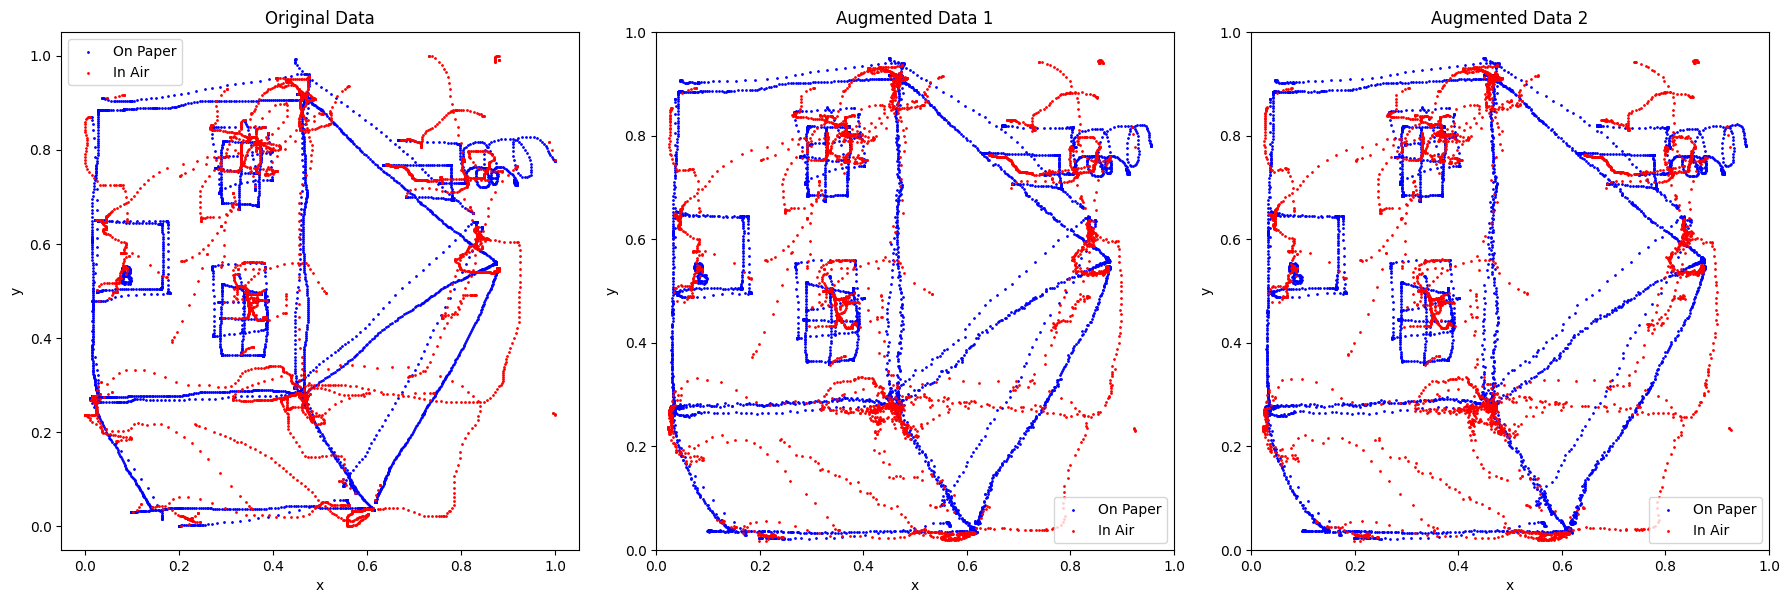

Epoch 271/300: 100%|██████████| 18/18 [00:00<00:00, 77.20batch/s, Total Loss=5.94e-5, Reconstruction Loss=5.35e-5, KL Loss=5.96]


Epoch 271: Total Loss = 0.000059, Reconstruction Loss = 0.000053, KL Divergence Loss = 6.046652
MAE = 0.251390, MSE = 0.091238, NRMSE = 0.302056


Epoch 272/300: 100%|██████████| 18/18 [00:00<00:00, 64.65batch/s, Total Loss=7.32e-5, Reconstruction Loss=6.72e-5, KL Loss=6.02]


Epoch 272: Total Loss = 0.000064, Reconstruction Loss = 0.000058, KL Divergence Loss = 6.065234
MAE = 0.251241, MSE = 0.090831, NRMSE = 0.301382


Epoch 273/300: 100%|██████████| 18/18 [00:00<00:00, 83.10batch/s, Total Loss=6.64e-5, Reconstruction Loss=6.04e-5, KL Loss=6.01]  


Epoch 273: Total Loss = 0.000088, Reconstruction Loss = 0.000081, KL Divergence Loss = 6.079694
MAE = 0.250221, MSE = 0.090212, NRMSE = 0.300353


Epoch 274/300: 100%|██████████| 18/18 [00:00<00:00, 50.37batch/s, Total Loss=7.18e-5, Reconstruction Loss=6.56e-5, KL Loss=6.19]


Epoch 274: Total Loss = 0.000068, Reconstruction Loss = 0.000062, KL Divergence Loss = 6.091136
MAE = 0.251068, MSE = 0.090949, NRMSE = 0.301577


Epoch 275/300: 100%|██████████| 18/18 [00:00<00:00, 76.64batch/s, Total Loss=0.000135, Reconstruction Loss=0.000129, KL Loss=6.1] 


Epoch 275: Total Loss = 0.000100, Reconstruction Loss = 0.000094, KL Divergence Loss = 6.100477
MAE = 0.252625, MSE = 0.091209, NRMSE = 0.302008


Epoch 276/300: 100%|██████████| 18/18 [00:00<00:00, 71.12batch/s, Total Loss=5.5e-5, Reconstruction Loss=4.89e-5, KL Loss=6.07]   


Epoch 276: Total Loss = 0.000092, Reconstruction Loss = 0.000086, KL Divergence Loss = 6.098500
MAE = 0.252445, MSE = 0.091415, NRMSE = 0.302349


Epoch 277/300: 100%|██████████| 18/18 [00:00<00:00, 57.26batch/s, Total Loss=0.000179, Reconstruction Loss=0.000173, KL Loss=6.04]


Epoch 277: Total Loss = 0.000088, Reconstruction Loss = 0.000082, KL Divergence Loss = 6.102712
MAE = 0.252904, MSE = 0.091789, NRMSE = 0.302967


Epoch 278/300: 100%|██████████| 18/18 [00:00<00:00, 52.13batch/s, Total Loss=8.84e-5, Reconstruction Loss=8.22e-5, KL Loss=6.13]  


Epoch 278: Total Loss = 0.000119, Reconstruction Loss = 0.000113, KL Divergence Loss = 6.099196
MAE = 0.250746, MSE = 0.090455, NRMSE = 0.300757


Epoch 279/300: 100%|██████████| 18/18 [00:00<00:00, 68.77batch/s, Total Loss=7.35e-5, Reconstruction Loss=6.74e-5, KL Loss=6.17]


Epoch 279: Total Loss = 0.000073, Reconstruction Loss = 0.000067, KL Divergence Loss = 6.097189
MAE = 0.250266, MSE = 0.090568, NRMSE = 0.300945


Epoch 280/300: 100%|██████████| 18/18 [00:00<00:00, 49.43batch/s, Total Loss=5.47e-5, Reconstruction Loss=4.86e-5, KL Loss=6.12]


Epoch 280: Total Loss = 0.000071, Reconstruction Loss = 0.000065, KL Divergence Loss = 6.106367
MAE = 0.251941, MSE = 0.091019, NRMSE = 0.301693


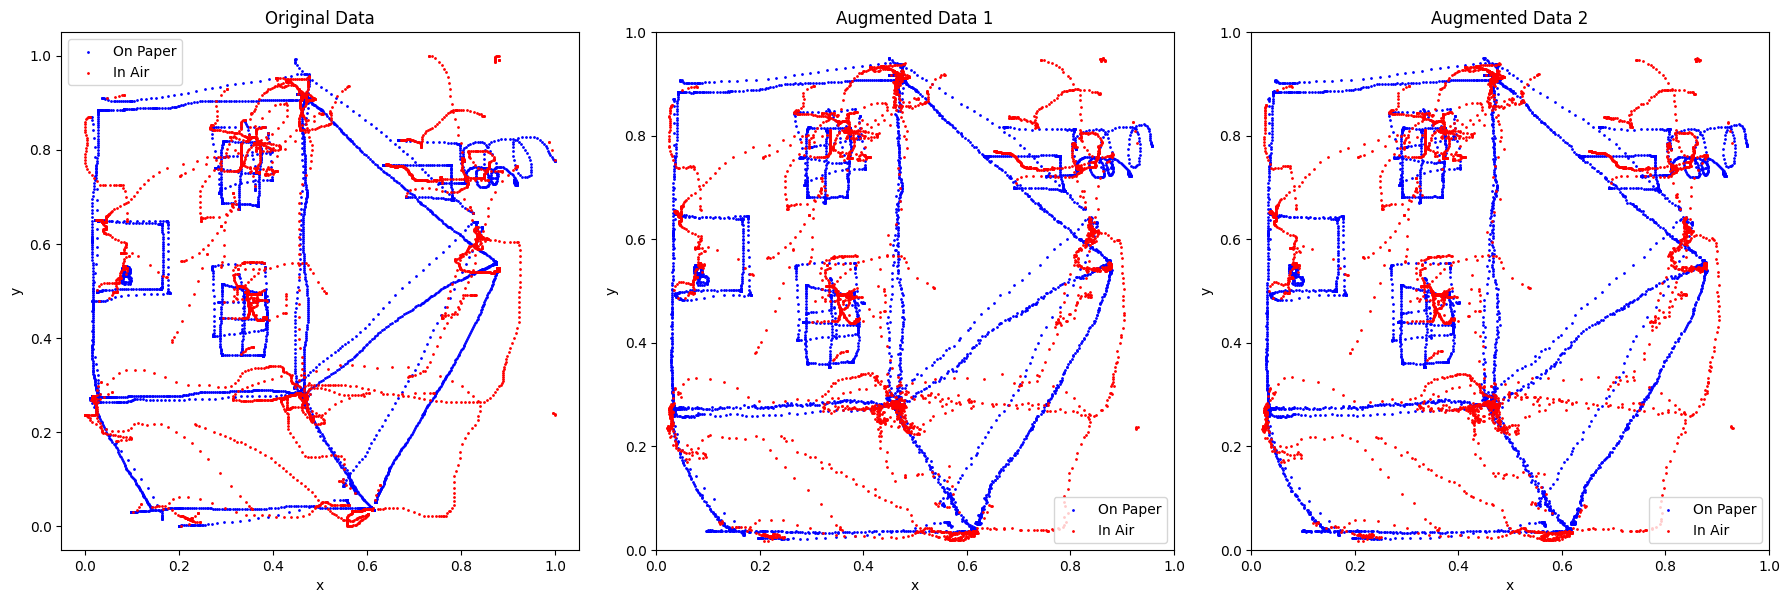

Epoch 281/300: 100%|██████████| 18/18 [00:05<00:00,  3.16batch/s, Total Loss=-0.139, Reconstruction Loss=0.00102, KL Loss=5.79] 


LSTM training at epoch 281: Discriminator Loss = [1.2373812]
Epoch 281: Total Loss = -0.138742, Reconstruction Loss = 0.001222, KL Divergence Loss = 6.043174
MAE = 0.250123, MSE = 0.089828, NRMSE = 0.299713


Epoch 282/300: 100%|██████████| 18/18 [00:00<00:00, 55.95batch/s, Total Loss=0.000388, Reconstruction Loss=0.000382, KL Loss=5.84]


Epoch 282: Total Loss = 0.000583, Reconstruction Loss = 0.000578, KL Divergence Loss = 5.808956
MAE = 0.251314, MSE = 0.090852, NRMSE = 0.301417


Epoch 283/300: 100%|██████████| 18/18 [00:00<00:00, 49.13batch/s, Total Loss=0.000151, Reconstruction Loss=0.000146, KL Loss=5.61]


Epoch 283: Total Loss = 0.000216, Reconstruction Loss = 0.000210, KL Divergence Loss = 5.719213
MAE = 0.250289, MSE = 0.090445, NRMSE = 0.300740


Epoch 284/300: 100%|██████████| 18/18 [00:00<00:00, 59.83batch/s, Total Loss=7.96e-5, Reconstruction Loss=7.37e-5, KL Loss=5.91] 


Epoch 284: Total Loss = 0.000094, Reconstruction Loss = 0.000088, KL Divergence Loss = 5.740439
MAE = 0.251507, MSE = 0.091489, NRMSE = 0.302471


Epoch 285/300: 100%|██████████| 18/18 [00:00<00:00, 48.80batch/s, Total Loss=6.44e-5, Reconstruction Loss=5.86e-5, KL Loss=5.76]


Epoch 285: Total Loss = 0.000070, Reconstruction Loss = 0.000065, KL Divergence Loss = 5.772892
MAE = 0.250451, MSE = 0.090494, NRMSE = 0.300823


Epoch 286/300: 100%|██████████| 18/18 [00:00<00:00, 59.73batch/s, Total Loss=6.57e-5, Reconstruction Loss=5.98e-5, KL Loss=5.94]


Epoch 286: Total Loss = 0.000064, Reconstruction Loss = 0.000059, KL Divergence Loss = 5.809737
MAE = 0.251975, MSE = 0.091388, NRMSE = 0.302305


Epoch 287/300: 100%|██████████| 18/18 [00:00<00:00, 57.26batch/s, Total Loss=6.08e-5, Reconstruction Loss=5.49e-5, KL Loss=5.9] 


Epoch 287: Total Loss = 0.000064, Reconstruction Loss = 0.000058, KL Divergence Loss = 5.844083
MAE = 0.251375, MSE = 0.091358, NRMSE = 0.302255


Epoch 288/300: 100%|██████████| 18/18 [00:00<00:00, 46.34batch/s, Total Loss=5.63e-5, Reconstruction Loss=5.03e-5, KL Loss=6.02]


Epoch 288: Total Loss = 0.000059, Reconstruction Loss = 0.000053, KL Divergence Loss = 5.875661
MAE = 0.251072, MSE = 0.090590, NRMSE = 0.300981


Epoch 289/300: 100%|██████████| 18/18 [00:00<00:00, 63.59batch/s, Total Loss=6.65e-5, Reconstruction Loss=6.06e-5, KL Loss=5.89]


Epoch 289: Total Loss = 0.000059, Reconstruction Loss = 0.000053, KL Divergence Loss = 5.900143
MAE = 0.251703, MSE = 0.091455, NRMSE = 0.302416


Epoch 290/300: 100%|██████████| 18/18 [00:00<00:00, 45.79batch/s, Total Loss=5.28e-5, Reconstruction Loss=4.68e-5, KL Loss=5.96]


Epoch 290: Total Loss = 0.000059, Reconstruction Loss = 0.000053, KL Divergence Loss = 5.923375
MAE = 0.251421, MSE = 0.091228, NRMSE = 0.302039


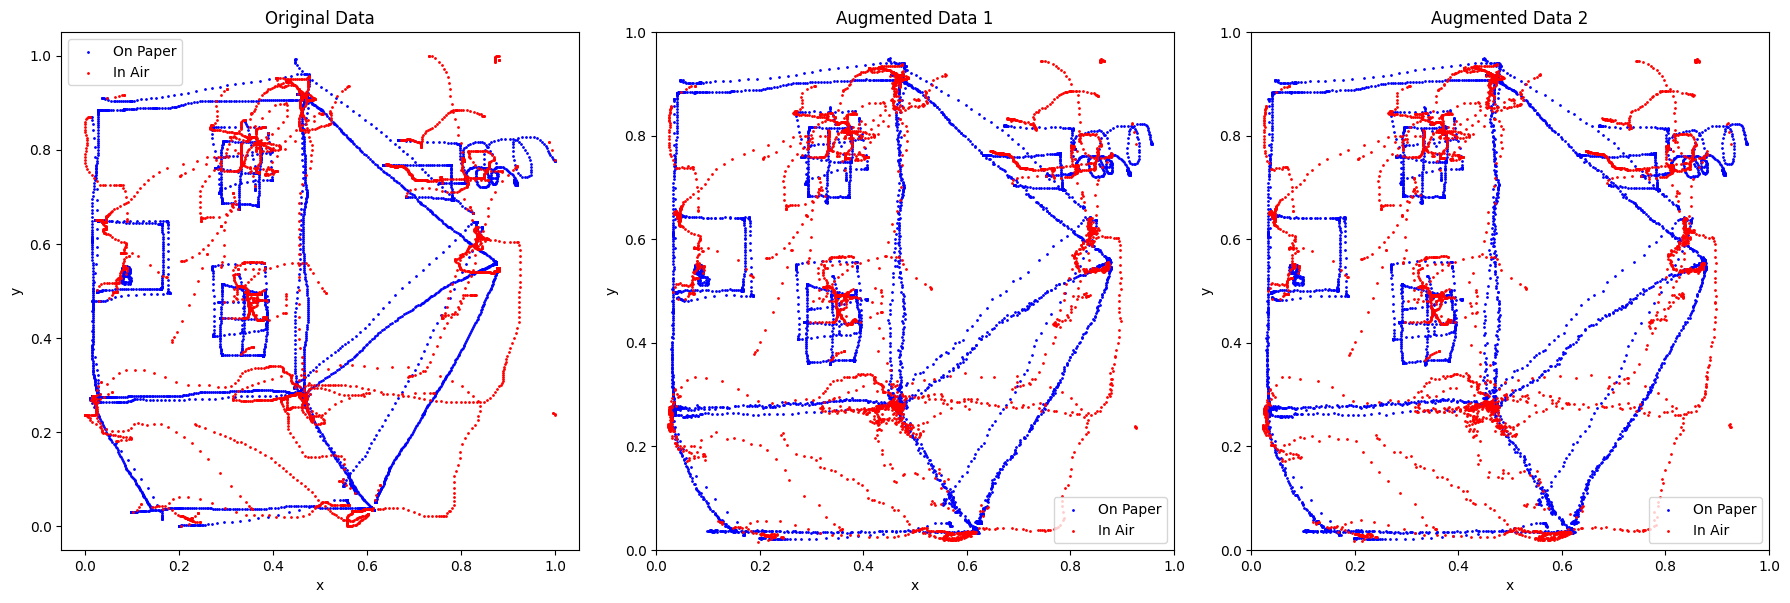

Epoch 291/300: 100%|██████████| 18/18 [00:00<00:00, 62.44batch/s, Total Loss=4.77e-5, Reconstruction Loss=4.16e-5, KL Loss=6.04]


Epoch 291: Total Loss = 0.000061, Reconstruction Loss = 0.000055, KL Divergence Loss = 5.945201
MAE = 0.251683, MSE = 0.090987, NRMSE = 0.301641


Epoch 292/300: 100%|██████████| 18/18 [00:00<00:00, 51.44batch/s, Total Loss=4.78e-5, Reconstruction Loss=4.17e-5, KL Loss=6.01]


Epoch 292: Total Loss = 0.000055, Reconstruction Loss = 0.000049, KL Divergence Loss = 5.964579
MAE = 0.251701, MSE = 0.091608, NRMSE = 0.302668


Epoch 293/300: 100%|██████████| 18/18 [00:00<00:00, 56.77batch/s, Total Loss=5.01e-5, Reconstruction Loss=4.42e-5, KL Loss=5.98]


Epoch 293: Total Loss = 0.000058, Reconstruction Loss = 0.000052, KL Divergence Loss = 5.982726
MAE = 0.252030, MSE = 0.091084, NRMSE = 0.301802


Epoch 294/300: 100%|██████████| 18/18 [00:00<00:00, 46.22batch/s, Total Loss=5.77e-5, Reconstruction Loss=5.18e-5, KL Loss=5.94]


Epoch 294: Total Loss = 0.000061, Reconstruction Loss = 0.000055, KL Divergence Loss = 5.998911
MAE = 0.252331, MSE = 0.091989, NRMSE = 0.303297


Epoch 295/300: 100%|██████████| 18/18 [00:00<00:00, 57.97batch/s, Total Loss=4.75e-5, Reconstruction Loss=4.15e-5, KL Loss=6]   


Epoch 295: Total Loss = 0.000051, Reconstruction Loss = 0.000045, KL Divergence Loss = 6.014528
MAE = 0.251992, MSE = 0.091544, NRMSE = 0.302563


Epoch 296/300: 100%|██████████| 18/18 [00:00<00:00, 63.12batch/s, Total Loss=8.41e-5, Reconstruction Loss=7.82e-5, KL Loss=5.96] 


Epoch 296: Total Loss = 0.000067, Reconstruction Loss = 0.000061, KL Divergence Loss = 6.030226
MAE = 0.251937, MSE = 0.091656, NRMSE = 0.302747


Epoch 297/300: 100%|██████████| 18/18 [00:00<00:00, 52.26batch/s, Total Loss=8.7e-5, Reconstruction Loss=8.08e-5, KL Loss=6.12] 


Epoch 297: Total Loss = 0.000072, Reconstruction Loss = 0.000066, KL Divergence Loss = 6.040175
MAE = 0.251631, MSE = 0.091091, NRMSE = 0.301813


Epoch 298/300: 100%|██████████| 18/18 [00:00<00:00, 60.08batch/s, Total Loss=7.57e-5, Reconstruction Loss=6.97e-5, KL Loss=5.95]  


Epoch 298: Total Loss = 0.000112, Reconstruction Loss = 0.000106, KL Divergence Loss = 6.041789
MAE = 0.252749, MSE = 0.091807, NRMSE = 0.302997


Epoch 299/300: 100%|██████████| 18/18 [00:00<00:00, 48.31batch/s, Total Loss=5.13e-5, Reconstruction Loss=4.52e-5, KL Loss=6.06]


Epoch 299: Total Loss = 0.000068, Reconstruction Loss = 0.000062, KL Divergence Loss = 6.037791
MAE = 0.252426, MSE = 0.091739, NRMSE = 0.302885


Epoch 300/300: 100%|██████████| 18/18 [00:00<00:00, 63.50batch/s, Total Loss=5.69e-5, Reconstruction Loss=5.09e-5, KL Loss=6.04]


Epoch 300: Total Loss = 0.000059, Reconstruction Loss = 0.000053, KL Divergence Loss = 6.046339
MAE = 0.252096, MSE = 0.091861, NRMSE = 0.303086


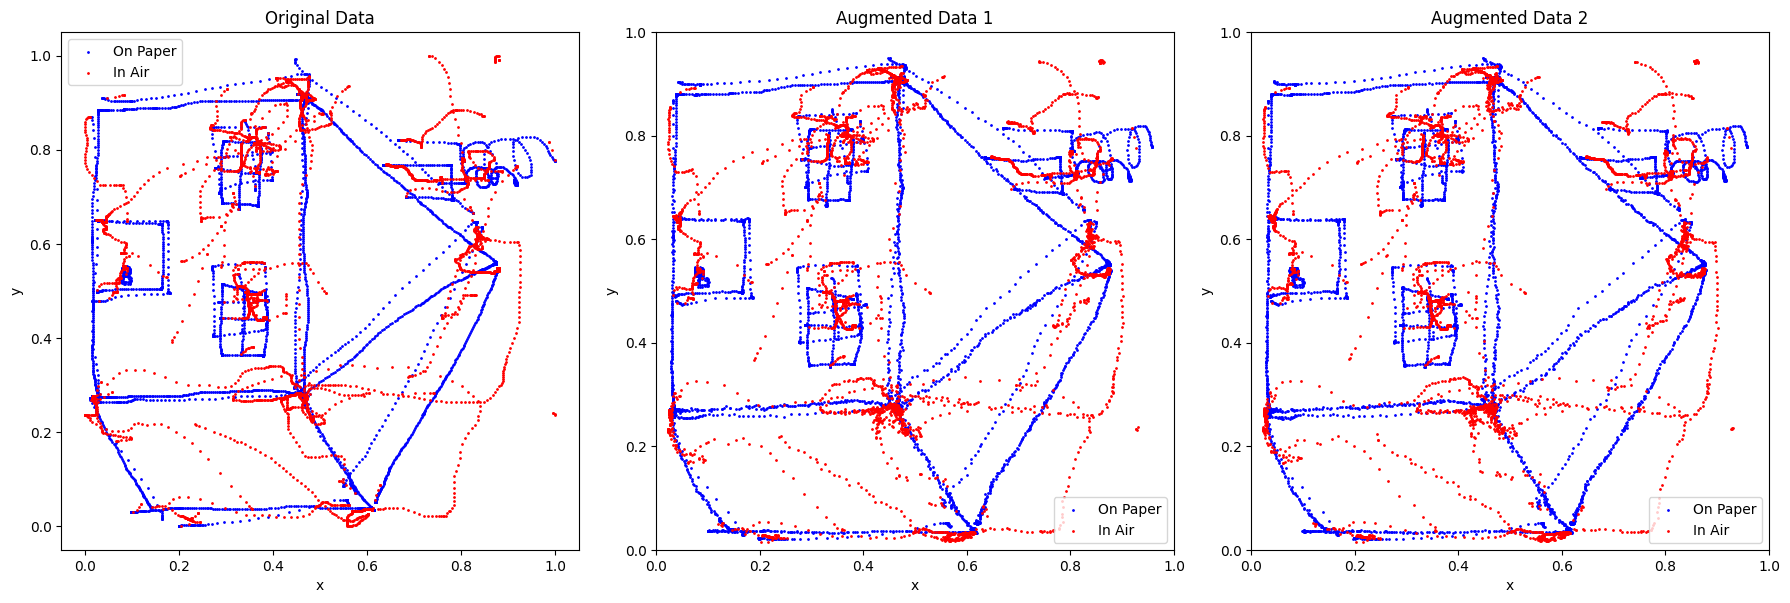

Final MAE: 0.252096
Final MSE: 0.091861
Final NRMSE: 0.303086
Training completed.


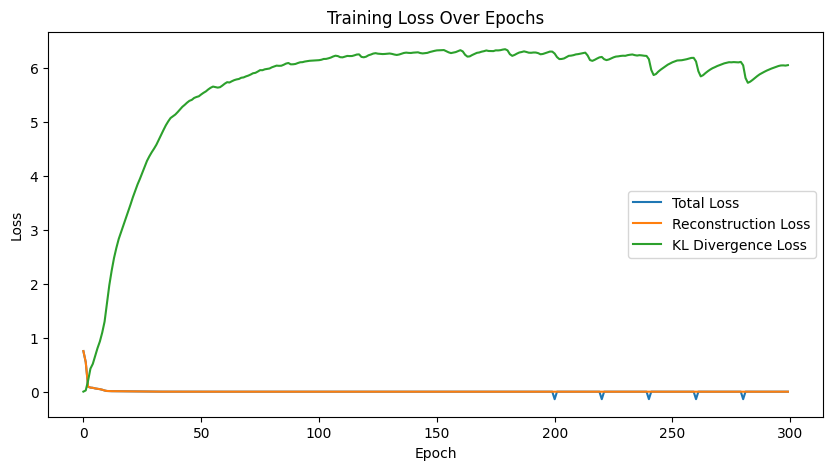

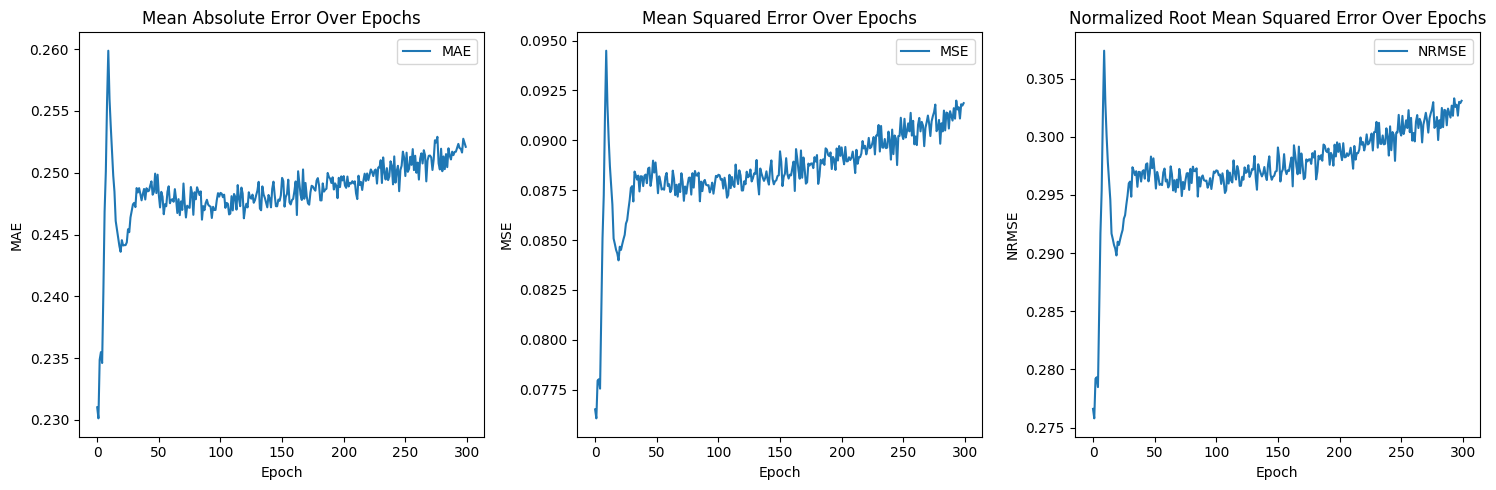

In [47]:
# Cell 5 (modified)
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            total_loss = reconstruction_loss + total_kl_loss - 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            total_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(10000).batch(batch_size)

# Set up alternating epochs
vae_epochs = 200
lstm_interval = 20
epochs = 300

total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
mae_history = []
mse_history = []
nrmse_history = []

for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            # Use LSTM discriminator after vae_epochs and every lstm_interval
            use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
            total_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            pbar.update(1)
            pbar.set_postfix({'Total Loss': float(total_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train the LSTM discriminator every lstm_interval epochs after vae_epochs
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        augmented_data = vae.decode(tf.random.normal(shape=(combined_data.shape[0], latent_dim))).numpy()
        real_data = tf.expand_dims(combined_data, axis=0)  # Reshape for LSTM input
        generated_data = tf.expand_dims(augmented_data, axis=0)

        lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')

    avg_total_loss = total_loss / num_batches
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    total_loss_history.append(avg_total_loss)
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate MAE, MSE, NRMSE
    augmented_data = vae.decode(tf.random.normal(shape=(combined_data.shape[0], latent_dim))).numpy()
    mae = mean_absolute_error(combined_data[:, :2], augmented_data[:, :2])
    mse = mean_squared_error(combined_data[:, :2], augmented_data[:, :2])
    rmse = np.sqrt(mse)
    nrmse = rmse / (combined_data[:, :2].max() - combined_data[:, :2].min())

    mae_history.append(mae)
    mse_history.append(mse)
    nrmse_history.append(nrmse)

    print(f"Epoch {epoch+1}: Total Loss = {avg_total_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"MAE = {mae:.6f}, MSE = {mse:.6f}, NRMSE = {nrmse:.6f}")

    if (epoch + 1) % 10 == 0:
        num_augmented_files = 2
        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points)

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6*(num_augmented_files + 1), 6))
        original_on_paper = combined_data[combined_data[:, 3] == 1]
        original_in_air = combined_data[combined_data[:, 3] == 0]
        axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
        axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
        axs[0].set_title('Original Data')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('y')
        axs[0].set_aspect('equal')
        axs[0].legend()

        # Set consistent axis limits for square aspect ratio
        x_min, x_max = combined_data[:, 0].min(), combined_data[:, 0].max()
        y_min, y_max = combined_data[:, 1].min(), combined_data[:, 1].max()

        for i, augmented_data in enumerate(augmented_datasets):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
            axs[i+1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i+1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i+1].set_title(f'Augmented Data {i+1}')
            axs[i+1].set_xlabel('x')
            axs[i+1].set_ylabel('y')
            axs[i+1].set_aspect('equal')
            axs[i+1].set_xlim(x_min, x_max)
            axs[i+1].set_ylim(y_min, y_max)
            axs[i+1].legend()

        plt.tight_layout()
        plt.show()

    # if patience_counter >= early_stopping_patience:
    #     print(f"Early stopping at epoch {epoch+1}")
    #     break

# Final output of metrics
print(f"Final MAE: {mae_history[-1]:.6f}")
print(f"Final MSE: {mse_history[-1]:.6f}")
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(total_loss_history, label='Total Loss')
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot MAE, MSE, and NRMSE history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(mae_history, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mse_history, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Cell 6
def download_augmented_data(augmented_datasets, scaler, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, augmented_data in enumerate(augmented_datasets):
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :3]),  # Inverse scale x, y, timestamp
            augmented_data[:, 3]  # Keep pen_status unchanged
        ))

        # Save each augmented dataset to a CSV file
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'timestamp', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

# Call the updated function with the same scaler for all augmented datasets
download_augmented_data(augmented_datasets, scalers[0])


Saved augmented_data\augmented_data_1.csv
Saved augmented_data\augmented_data_2.csv
